In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
python3 = True

# 0 - Intruduction: usefull actions

The goal of this work is to build model able to predict probability for a client to leave ENEL (Churn)

## 0.1- Import of useful packages and modules

In [2]:
import pandas as pd, os, sys
pd.set_option('max_colwidth', None)
import itertools
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

from gensim.models import Word2Vec
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
from sklearn.manifold import TSNE
from numpy import dot
from numpy.linalg import norm

import pickle
from keras.models import Input, Model
from keras.layers import Dense

Using TensorFlow backend.


## 0.2- Environment variables setting

In [3]:
# Setting environment variables
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")
if python3: os.environ['PYSPARK_PYTHON'] = "vsb/CI_conda_env_py3/bin/python"

## 0.2- Spark configuration 

In [4]:
# Importing the Spark Configurator and the Spark Session builder
from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as types
from pyspark.mllib.stat import Statistics
from pyspark.sql.window import Window

# Stopping the current session if exists
try:
    session.stop()
except:
    print()
   
# Setting up the spark configurator  
conf = SparkConf()
conf.set('spark.serializer', "org.apache.spark.serializer.KryoSerializer")       
conf.set('spark.executor.memory', '16g')
conf.set('spark.driver.memory', '16g')
conf.set('spark.executor.cores', '3')
conf.set('spark.driver.cores', '3')
conf.set('spark.dynamicAllocation.enabled', 'true')
conf.set('spark.executor.instances', '4')
conf.set('spark.dynamicAllocation.minExecutors', '4')
conf.set('spark.dynamicAllocation.maxExecutors', '12')
conf.set('spark.executor.memoryOverhead', '8096')
conf.set('spark.driver.memoryOverhead', '8096')
conf.set('spark.driver.maxResultSize', '20g')
conf.set('spark.kryoserializer.buffer.max', '2047')
conf.setAppName('DA_Data_Transformation')
if python3: conf.set("spark.yarn.dist.archives", "/home/anxadvuser/anx_adv_achurn/env_conda_py3.zip#vsb")

# Creating the spark session object
session = SparkSession.builder.config(conf=conf).enableHiveSupport().getOrCreate()

In [5]:
# Let's fetch the output of the first step of feature selection as input of the current step
input_data_small_medium = session.read.parquet("/bda/anx_adv_achurn/durand/input_data_small_medium_step1").cache()
input_data_micro = session.read.parquet("/bda/anx_adv_achurn/durand/input_data_micro_step1").cache()

#servizi = session.read.parquet("/bds/anx_adv_achurn/t_bds_anx_dt_aa_servizi")
#servizi_mercato_provenienza = session.read.parquet("/bds/anx_adv_achurn/t_bds_anx_dt_ach_SERVIZI_MERCATO_PROVENIENZA")
#clienti = session.read.parquet("/bds/anx_adv_achurn/t_bds_anx_dt_ach_cliente")
#geomarketing_arricchita = session.read.parquet("/bds/anx_adv_achurn/t_bds_anx_dt_ach_geomarketing_arricchita")
#marketing = session.read.parquet("/bds/anx_adv_achurn/t_bds_anx_dt_ach_MARKETING")
#cliente_cv = session.read.parquet("/bds/anx_adv_achurn/t_bds_anx_dt_ach_cliente_cv")
#servizio_fattura = session.read.parquet("/bds/anx_adv_achurn/t_bds_anx_dt_aa_servizio_fattura")
#tipologia_pagamento = session.read.parquet("/bds/anx_adv_achurn/t_bds_anx_dt_ach_FATTURATO_TIPOLOGIA_PAGAMENTO")
#fatturato_isu = session.read.parquet("/bds/anx_adv_achurn/t_bds_anx_dt_aa_fatturato_isu")
#mercato_provenienza = session.read.parquet("/bds/anx_adv_achurn/t_bds_anx_dt_ach_SERVIZI_MERCATO_PROVENIENZA")
#geomarketing_istat = session.read.parquet("/bds/anx_adv_achurn/t_bds_anx_dt_ach_geomarketing_istat")

# 1 - Data Tranformation

## 1.1 - Checking the imbalance of categorical target (class imbalance)

A dataset is said to be “highly class imbalanced” if a sample from one target class is significantly higher in number than others. This can be treated as a special case of the previous “low entropy of categorical attributes.” In an imbalanced dataset, the class with a higher number of instances is called a major class, while those with relatively fewer instances are called minor classes.

In this case, most of the classifiers are biased towards the major classes and, hence, display poor classification rates on minor classes. It is also possible that the classifier predicts everything as a major class and ignores the minor class.

In [6]:
input_data_small_medium.groupBy('val_churn_2_months').count().show()

+------------------+-------+
|val_churn_2_months|  count|
+------------------+-------+
|               0.0|5110374|
|               1.0| 154251|
+------------------+-------+



In [7]:
input_data_micro.groupBy('val_churn_2_months').count().show()

+------------------+--------+
|val_churn_2_months|   count|
+------------------+--------+
|               0.0|19743291|
|               1.0|  480623|
+------------------+--------+



In [8]:
input_data_small_medium.groupBy('val_t0_year', 'val_t0_month', 'val_churn_2_months').count().orderBy('val_t0_year', 'val_t0_month', 'val_churn_2_months').show()

+-----------+------------+------------------+------+
|val_t0_year|val_t0_month|val_churn_2_months| count|
+-----------+------------+------------------+------+
|       2019|           1|               0.0|330120|
|       2019|           1|               1.0|  7924|
|       2019|           2|               0.0|332180|
|       2019|           2|               1.0| 10249|
|       2019|           3|               0.0|334322|
|       2019|           3|               1.0| 10762|
|       2019|           4|               0.0|335611|
|       2019|           4|               1.0| 10580|
|       2019|           5|               0.0|335394|
|       2019|           5|               1.0| 10979|
|       2019|           6|               0.0|337403|
|       2019|           6|               1.0| 10859|
|       2019|           7|               0.0|340563|
|       2019|           7|               1.0|  9226|
|       2019|           8|               0.0|344134|
|       2019|           8|               1.0| 

In [9]:
input_data_micro.groupBy('val_t0_year', 'val_t0_month', 'val_churn_2_months').count().orderBy('val_t0_year', 'val_t0_month', 'val_churn_2_months').show()

+-----------+------------+------------------+-------+
|val_t0_year|val_t0_month|val_churn_2_months|  count|
+-----------+------------+------------------+-------+
|       2019|           1|               0.0|1249666|
|       2019|           1|               1.0|  25444|
|       2019|           2|               0.0|1262272|
|       2019|           2|               1.0|  32028|
|       2019|           3|               0.0|1277190|
|       2019|           3|               1.0|  32526|
|       2019|           4|               0.0|1286187|
|       2019|           4|               1.0|  31027|
|       2019|           5|               0.0|1290866|
|       2019|           5|               1.0|  31831|
|       2019|           6|               0.0|1299009|
|       2019|           6|               1.0|  33271|
|       2019|           7|               0.0|1317724|
|       2019|           7|               1.0|  27470|
|       2019|           8|               0.0|1333085|
|       2019|           8|  

## 1.2- Train set and Test set: Smal-Medium and Micro

First of all, let's split the data into train set (80%) and test set (20%). The splitting will be stratified over the following columns:
* val_t0_year
* val_t0_month
* val_churn_2_months

In [6]:
# add the column to be used to sample the data
input_data_small_medium_sample_by = input_data_small_medium.withColumn('sample_by_column',
                                                                       F.concat(
                                                                           F.col('val_t0_year'),
                                                                           F.col('val_t0_month'),
                                                                           F.col('val_churn_2_months')
                                                                       )
                                                                      )
input_data_micro_sample_by = input_data_micro.withColumn('sample_by_column',
                                                         F.concat(
                                                             F.col('val_t0_year'),
                                                             F.col('val_t0_month'),
                                                             F.col('val_churn_2_months')
                                                         )
                                                        )


# add the column to be used as the join key to get the test set
input_data_small_medium_sample_by = input_data_small_medium_sample_by.withColumn("row_id", F.monotonically_increasing_id())
input_data_micro_sample_by = input_data_micro_sample_by.withColumn("row_id", F.monotonically_increasing_id())

In [7]:
fractions_small_medium = input_data_small_medium_sample_by.select("sample_by_column").distinct().withColumn("fraction", F.lit(0.8)).rdd.collectAsMap()
print("Fractions Small Medium:", fractions_small_medium)
fractions_micro = input_data_micro_sample_by.select("sample_by_column").distinct().withColumn("fraction", F.lit(0.8)).rdd.collectAsMap()
print("Fractions Micro:", fractions_micro)

Fractions Small Medium: {'2019111.0': 0.8, '201910.0': 0.8, '201961.0': 0.8, '201920.0': 0.8, '202030.0': 0.8, '202031.0': 0.8, '201951.0': 0.8, '2019101.0': 0.8, '202021.0': 0.8, '201971.0': 0.8, '202020.0': 0.8, '201960.0': 0.8, '201921.0': 0.8, '201931.0': 0.8, '201990.0': 0.8, '201950.0': 0.8, '201911.0': 0.8, '2019120.0': 0.8, '202010.0': 0.8, '201981.0': 0.8, '201930.0': 0.8, '2019121.0': 0.8, '201941.0': 0.8, '202011.0': 0.8, '2019100.0': 0.8, '201940.0': 0.8, '2019110.0': 0.8, '201970.0': 0.8, '201991.0': 0.8, '201980.0': 0.8}
Fractions Micro: {'2019111.0': 0.8, '201910.0': 0.8, '201961.0': 0.8, '201920.0': 0.8, '202030.0': 0.8, '202031.0': 0.8, '201951.0': 0.8, '2019101.0': 0.8, '202021.0': 0.8, '201971.0': 0.8, '202020.0': 0.8, '201960.0': 0.8, '201921.0': 0.8, '201931.0': 0.8, '201990.0': 0.8, '201950.0': 0.8, '201911.0': 0.8, '2019120.0': 0.8, '202010.0': 0.8, '201981.0': 0.8, '201930.0': 0.8, '2019121.0': 0.8, '201941.0': 0.8, '202011.0': 0.8, '2019100.0': 0.8, '201940.0':

In [8]:
seed = 10
train_set_small_medium = input_data_small_medium_sample_by.stat.sampleBy("sample_by_column", fractions_small_medium, seed)
train_set_small_medium = train_set_small_medium.dropDuplicates(['row_id'])
test_set_small_medium = input_data_small_medium_sample_by.join(train_set_small_medium.select('row_id'), on = 'row_id', how = 'leftanti')

train_set_small_medium = train_set_small_medium.drop('sample_by_column')
train_set_small_medium = train_set_small_medium.drop('row_id').cache()
test_set_small_medium = test_set_small_medium.drop('sample_by_column')
test_set_small_medium = test_set_small_medium.drop('row_id').cache()


train_set_micro = input_data_micro_sample_by.stat.sampleBy("sample_by_column", fractions_micro, seed)
train_set_micro = train_set_micro.dropDuplicates(['row_id'])
test_set_micro = input_data_micro_sample_by.join(train_set_micro.select('row_id'), on = 'row_id', how = 'leftanti')

train_set_micro = train_set_micro.drop('sample_by_column')
train_set_micro = train_set_micro.drop('row_id').cache()
test_set_micro = test_set_micro.drop('sample_by_column')
test_set_micro = test_set_micro.drop('row_id').cache()

Let's have a look at the different sampled data sets:

In [9]:
train_set_small_medium.groupBy('val_t0_year', 'val_t0_month', 'val_churn_2_months').count().orderBy('val_t0_year', 'val_t0_month', 'val_churn_2_months').show(50, False)

+-----------+------------+------------------+------+
|val_t0_year|val_t0_month|val_churn_2_months|count |
+-----------+------------+------------------+------+
|2019       |1           |0.0               |264409|
|2019       |1           |1.0               |6328  |
|2019       |2           |0.0               |265789|
|2019       |2           |1.0               |8149  |
|2019       |3           |0.0               |268035|
|2019       |3           |1.0               |8634  |
|2019       |4           |0.0               |268708|
|2019       |4           |1.0               |8542  |
|2019       |5           |0.0               |268459|
|2019       |5           |1.0               |8801  |
|2019       |6           |0.0               |269974|
|2019       |6           |1.0               |8677  |
|2019       |7           |0.0               |272454|
|2019       |7           |1.0               |7407  |
|2019       |8           |0.0               |275258|
|2019       |8           |1.0               |6

In [10]:
train_set_small_medium.groupBy('val_churn_2_months').count().show()

+------------------+-------+
|val_churn_2_months|  count|
+------------------+-------+
|               0.0|4091921|
|               1.0| 123473|
+------------------+-------+



In [11]:
train_set_micro.groupBy('val_t0_year', 'val_t0_month', 'val_churn_2_months').count().orderBy('val_t0_year', 'val_t0_month', 'val_churn_2_months').show(50, False)

+-----------+------------+------------------+-------+
|val_t0_year|val_t0_month|val_churn_2_months|count  |
+-----------+------------+------------------+-------+
|2019       |1           |0.0               |1000215|
|2019       |1           |1.0               |20393  |
|2019       |2           |0.0               |1010652|
|2019       |2           |1.0               |25640  |
|2019       |3           |0.0               |1022606|
|2019       |3           |1.0               |26024  |
|2019       |4           |0.0               |1030303|
|2019       |4           |1.0               |24912  |
|2019       |5           |0.0               |1034386|
|2019       |5           |1.0               |25399  |
|2019       |6           |0.0               |1040455|
|2019       |6           |1.0               |26739  |
|2019       |7           |0.0               |1054545|
|2019       |7           |1.0               |22045  |
|2019       |8           |0.0               |1067479|
|2019       |8           |1.

In [12]:
train_set_micro.groupBy('val_churn_2_months').count().show()

+------------------+--------+
|val_churn_2_months|   count|
+------------------+--------+
|               0.0|15807513|
|               1.0|  384706|
+------------------+--------+



In [16]:
test_set_small_medium.groupBy('val_t0_year', 'val_t0_month', 'val_churn_2_months').count().orderBy('val_t0_year', 'val_t0_month', 'val_churn_2_months').show()

+-----------+------------+------------------+-----+
|val_t0_year|val_t0_month|val_churn_2_months|count|
+-----------+------------+------------------+-----+
|       2019|           1|               0.0|65875|
|       2019|           1|               1.0| 1576|
|       2019|           2|               0.0|66367|
|       2019|           2|               1.0| 2062|
|       2019|           3|               0.0|66792|
|       2019|           3|               1.0| 2129|
|       2019|           4|               0.0|67218|
|       2019|           4|               1.0| 2121|
|       2019|           5|               0.0|67266|
|       2019|           5|               1.0| 2193|
|       2019|           6|               0.0|67413|
|       2019|           6|               1.0| 2166|
|       2019|           7|               0.0|68097|
|       2019|           7|               1.0| 1866|
|       2019|           8|               0.0|69004|
|       2019|           8|               1.0| 1650|
|       2019

In [17]:
test_set_micro.groupBy('val_t0_year', 'val_t0_month', 'val_churn_2_months').count().orderBy('val_t0_year', 'val_t0_month', 'val_churn_2_months').show()

+-----------+------------+------------------+------+
|val_t0_year|val_t0_month|val_churn_2_months| count|
+-----------+------------+------------------+------+
|       2019|           1|               0.0|249530|
|       2019|           1|               1.0|  5040|
|       2019|           2|               0.0|251886|
|       2019|           2|               1.0|  6423|
|       2019|           3|               0.0|254874|
|       2019|           3|               1.0|  6700|
|       2019|           4|               0.0|256532|
|       2019|           4|               1.0|  6336|
|       2019|           5|               0.0|257664|
|       2019|           5|               1.0|  6498|
|       2019|           6|               0.0|259455|
|       2019|           6|               1.0|  6678|
|       2019|           7|               0.0|263509|
|       2019|           7|               1.0|  5501|
|       2019|           8|               0.0|266571|
|       2019|           8|               1.0| 

## 1.3- Handling the imbalace class

Now let us handle the imbalace situation on the training set.

In [39]:
train_set_small_medium.groupBy('val_churn_2_months').count().show()

+------------------+-------+
|val_churn_2_months|  count|
+------------------+-------+
|               0.0|4091921|
|               1.0| 123473|
+------------------+-------+



In [40]:
train_set_micro.groupBy('val_churn_2_months').count().show()

+------------------+--------+
|val_churn_2_months|   count|
+------------------+--------+
|               0.0|15807513|
|               1.0|  384706|
+------------------+--------+



### 1.3.1 - Reducing the records of the over-represented class from 20 000 000 to 5 000 000 observations - micro

As we can see, the number of zeros is extremely higher with respect to the number of ones. We have arround 16 000 000 observations for the 0 class which is huge. we are going to sample around 5 000 000 observations from this class and then oversample the 1 class to obtain in total around 10 000 000 observations. The idea of oversampling, is to duplicate the samples from under-represented (1 in this case) class, to inflate the numbers till it reaches the same level as the dominant class (0 in this case).

In [9]:
# add the column to be used to sample the data
train_set_micro_sample_by = train_set_micro.withColumn('sample_by_column',
                                                       F.concat(
                                                           F.col('val_t0_year'),
                                                           F.col('val_t0_month'),
                                                           F.col('val_churn_2_months')
                                                       )
                                                      )

# add the column to be used as the join key to get the test set
train_set_micro_sample_by = train_set_micro_sample_by.withColumn("row_id", F.monotonically_increasing_id())

In [10]:
fractions_micro = train_set_micro_sample_by.select("sample_by_column").distinct()\
.withColumn("fraction", 
            F.when(train_set_micro_sample_by.sample_by_column.like('%1.0'), 1).otherwise(0.35)
           ).rdd.collectAsMap()

print("Fractions Micro: ", fractions_micro)

Fractions Micro:  {'2019111.0': 1.0, '201910.0': 0.35, '201961.0': 1.0, '201920.0': 0.35, '202030.0': 0.35, '202031.0': 1.0, '201951.0': 1.0, '2019101.0': 1.0, '202021.0': 1.0, '201971.0': 1.0, '202020.0': 0.35, '201960.0': 0.35, '201921.0': 1.0, '201931.0': 1.0, '201990.0': 0.35, '201950.0': 0.35, '201911.0': 1.0, '2019120.0': 0.35, '202010.0': 0.35, '201981.0': 1.0, '201930.0': 0.35, '2019121.0': 1.0, '201941.0': 1.0, '202011.0': 1.0, '2019100.0': 0.35, '201940.0': 0.35, '2019110.0': 0.35, '201970.0': 0.35, '201991.0': 1.0, '201980.0': 0.35}


In [11]:
seed = 10
train_set_micro = train_set_micro_sample_by.stat.sampleBy("sample_by_column", fractions_micro, seed)
train_set_micro = train_set_micro.dropDuplicates(['row_id'])

train_set_micro = train_set_micro.drop('sample_by_column')
train_set_micro = train_set_micro.drop('row_id').cache()

In [16]:
train_set_micro.groupBy('val_churn_2_months').count().show()

+------------------+-------+
|val_churn_2_months|  count|
+------------------+-------+
|               0.0|5590948|
|               1.0| 384706|
+------------------+-------+



In [17]:
train_set_micro.groupBy('val_t0_year', 'val_t0_month', 'val_churn_2_months').count().orderBy('val_t0_year', 'val_t0_month', 'val_churn_2_months').show(50, False)

+-----------+------------+------------------+------+
|val_t0_year|val_t0_month|val_churn_2_months|count |
+-----------+------------+------------------+------+
|2019       |1           |0.0               |350510|
|2019       |1           |1.0               |20393 |
|2019       |2           |0.0               |353989|
|2019       |2           |1.0               |25640 |
|2019       |3           |0.0               |360729|
|2019       |3           |1.0               |26024 |
|2019       |4           |0.0               |361376|
|2019       |4           |1.0               |24912 |
|2019       |5           |0.0               |366163|
|2019       |5           |1.0               |25399 |
|2019       |6           |0.0               |368042|
|2019       |6           |1.0               |26739 |
|2019       |7           |0.0               |370615|
|2019       |7           |1.0               |22045 |
|2019       |8           |0.0               |374095|
|2019       |8           |1.0               |1

### 1.3.2 - Oversampling the under-represented class to around 5 000 000 observations: Small-Medium and Micro 

In [12]:
major_df_small_medium = train_set_small_medium.filter(F.col("val_churn_2_months") == 0)
minor_df_small_medium = train_set_small_medium.filter(F.col("val_churn_2_months") == 1)
ratio = int(major_df_small_medium.count()/minor_df_small_medium.count())

a = range(ratio)
# duplicate the minority rows
oversampled_train_set_small_medium = minor_df_small_medium.withColumn("dummy", F.explode(F.array([F.lit(x) for x in a]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows 
train_set_small_medium_balanced = major_df_small_medium.unionAll(oversampled_train_set_small_medium).cache()

In [62]:
train_set_small_medium_balanced.groupBy('val_churn_2_months').count().show()

+------------------+-------+
|val_churn_2_months|  count|
+------------------+-------+
|               0.0|4091921|
|               1.0|4074609|
+------------------+-------+



In [14]:
train_set_small_medium_balanced.groupBy('val_t0_year', 'val_t0_month', 'val_churn_2_months').count().orderBy('val_t0_year', 'val_t0_month', 'val_churn_2_months').show(50, False)

+-----------+------------+------------------+------+
|val_t0_year|val_t0_month|val_churn_2_months|count |
+-----------+------------+------------------+------+
|2019       |1           |0.0               |264409|
|2019       |1           |1.0               |208824|
|2019       |2           |0.0               |265789|
|2019       |2           |1.0               |268917|
|2019       |3           |0.0               |268035|
|2019       |3           |1.0               |284922|
|2019       |4           |0.0               |268708|
|2019       |4           |1.0               |281886|
|2019       |5           |0.0               |268459|
|2019       |5           |1.0               |290433|
|2019       |6           |0.0               |269974|
|2019       |6           |1.0               |286341|
|2019       |7           |0.0               |272454|
|2019       |7           |1.0               |244431|
|2019       |8           |0.0               |275258|
|2019       |8           |1.0               |2

In [13]:
major_df_micro = train_set_micro.filter(F.col("val_churn_2_months") == 0)
minor_df_micro = train_set_micro.filter(F.col("val_churn_2_months") == 1)
ratio = int(major_df_micro.count()/minor_df_micro.count())

a = range(ratio)
# duplicate the minority rows
oversampled_train_set_micro = minor_df_micro.withColumn("dummy", F.explode(F.array([F.lit(x) for x in a]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows 
train_set_micro_balanced = major_df_micro.unionAll(oversampled_train_set_micro)

In [64]:
train_set_micro_balanced.groupBy('val_churn_2_months').count().show()

+------------------+-------+
|val_churn_2_months|  count|
+------------------+-------+
|               0.0|5590948|
|               1.0|5385884|
+------------------+-------+



In [15]:
train_set_micro_balanced.groupBy('val_t0_year', 'val_t0_month', 'val_churn_2_months').count().orderBy('val_t0_year', 'val_t0_month', 'val_churn_2_months').show(50, False)

+-----------+------------+------------------+------+
|val_t0_year|val_t0_month|val_churn_2_months|count |
+-----------+------------+------------------+------+
|2019       |1           |0.0               |350510|
|2019       |1           |1.0               |285502|
|2019       |2           |0.0               |353989|
|2019       |2           |1.0               |358960|
|2019       |3           |0.0               |360729|
|2019       |3           |1.0               |364336|
|2019       |4           |0.0               |361376|
|2019       |4           |1.0               |348768|
|2019       |5           |0.0               |366163|
|2019       |5           |1.0               |355586|
|2019       |6           |0.0               |368042|
|2019       |6           |1.0               |374346|
|2019       |7           |0.0               |370615|
|2019       |7           |1.0               |308630|
|2019       |8           |0.0               |374095|
|2019       |8           |1.0               |2

In [65]:
train_set_small_medium_balanced.write.mode("overwrite").parquet("/bda/anx_adv_achurn/durand/train_set_small_medium_balanced")
train_set_micro_balanced.write.mode("overwrite").parquet("/bda/anx_adv_achurn/durand/train_set_micro_balanced")

In [67]:
test_set_small_medium.write.mode("overwrite").parquet("/bda/anx_adv_achurn/durand/test_set_small_medium")
test_set_micro.write.mode("overwrite").parquet("/bda/anx_adv_achurn/durand/test_set_micro")

## 1.4 - Converting categorical columns to numerical

In [445]:
train_set_small_medium_balanced = session.read.parquet("/bda/anx_adv_achurn/durand/train_set_small_medium_balanced").cache()
train_set_micro_balanced = session.read.parquet("/bda/anx_adv_achurn/durand/train_set_micro_balanced").cache()

test_set_small_medium = session.read.parquet("/bda/anx_adv_achurn/durand/test_set_small_medium").cache()
test_set_micro = session.read.parquet("/bda/anx_adv_achurn/durand/test_set_micro").cache()

In [446]:
# This is the list of the 34 categorical features to be handled
categorical_features_small_medium = [
    'lds_prodotto_listino_2', 'sds_segmento_new', 'mds_canale_acquisizione', 
    'cdc_cap_nrm', 'lds_tipo_uso', 'sds_macro_categoria_ateco', 'sds_categoria_ateco_intermedia', 
    'cdc_residente', 'mds_tipologia_pagamento', 'cdc_id_mercato', 'sds_provincia_fatturazione', 
    'sds_regione_fatturazione', 'sds_mat_fatturazione', 'sds_provincia', 'sds_regione', 'sds_mat', 
    'lds_societa_vendita', 'cdc_win_back_m3', 'mds_sottocanale', 'flc_vas', 'mds_land_type', 
    'cdc_cd_censimento', 'cdc_istat', 'cdc_Zona_altimetrica', 'cdc_Comune_Montano', 
    'sds_cluster_ele', 'sds_cluster_gas', 'cdc_causale_attivazione', 'lds_comune_fornitura', 
    'cdc_bolletta_web', 'cdc_cluster_fattura_last', 'mds_nome_campagna_last_response_marketing_cli', 
    'xds_canale_last_response_marketing_cli', 'xds_tipo_azione_campagna_last_response_marketing_cli', 
    'xds_tipologia_azione_last_response_marketing_cli', 'lds_RETE_GAS', 'lds_Cluster_Polis_11_gruppi', 
    'sds_segmento_organizzativo_cliente', 'cdc_tenure_bucket', 'cdc_cv_fasce_servizio', 
    'cdc_cv_fasce_cliente', 'cdc_tenure_bucket_cliente'
]

categorical_features_micro = [
    'lds_prodotto_listino_2', 'sds_segmento_new', 'mds_canale_acquisizione', 'cdc_cap_nrm', 
    'lds_tipo_uso', 'cdc_residente', 'mds_tipologia_pagamento', 'cdc_id_mercato', 'sds_provincia_fatturazione', 
    'sds_regione_fatturazione', 'sds_mat_fatturazione', 'sds_provincia', 'sds_regione', 'sds_mat', 
    'lds_societa_vendita', 'cdc_win_back_m3', 'mds_sottocanale', 'flc_vas', 'mds_land_type', 
    'cdc_cd_censimento', 'cdc_istat', 'cdc_Zona_altimetrica', 'cdc_Comune_Montano', 'sds_cluster_ele', 
    'sds_cluster_gas', 'cdc_causale_attivazione', 'lds_comune_fornitura', 'cdc_bolletta_web', 
    'cdc_cluster_fattura_last', 'mds_nome_campagna_last_response_marketing_cli', 
    'xds_canale_last_response_marketing_cli', 'xds_tipo_azione_campagna_last_response_marketing_cli', 
    'xds_tipologia_azione_last_response_marketing_cli', 'lds_RETE_GAS', 'lds_Cluster_Polis_11_gruppi', 
    'sds_segmento_organizzativo_cliente', 'cdc_tenure_bucket', 'cdc_cv_fasce_servizio', 'cdc_cv_fasce_cliente', 
    'cdc_tenure_bucket_cliente'
]

print("Number of categorical variables SMALL/MEDIUM: ", len(categorical_features_small_medium))
print("Number of categorical variables SMALL/MEDIUM: ", len(categorical_features_micro))

Number of categorical variables SMALL/MEDIUM:  42
Number of categorical variables SMALL/MEDIUM:  40


In [447]:
def count_missings(spark_df,sort=True):
    """
    Counts number of nulls and nans in each column
    """
    df = spark_df.select([F.count(F.when(F.isnan(c) | F.isnull(c), c)).alias(c) for (c,c_type) in spark_df.dtypes if c_type not in ('timestamp', 'string', 'date')]).toPandas()

    if len(df) == 0:
        print("There are no any missing values!")
        return None

    if sort:
        return df.rename(index={0: 'count'}).T.sort_values("count",ascending=False)

    return df

### 1.4.1 - One Hot Encoding

In [448]:
def one_hot_encoder(df, column, categories):
    # for each categorie, create a new column with name "column_category"
    for category in categories:
        df = df.withColumn(column+'_'+'_'.join(category.replace('.', '').split(' ')), F.when(F.col(column) == category, 1).otherwise(0))
    return df

#### 1.4.1.1- Small and Medium (12 features)

One hot encoding was used in this case because of the small amount of distinct values which is going to limit the number of new features. This method was applied when the feature was thought not to be further exploitable. The following is the list of those columns:

In [1]:
columns_one_hot_small_medium = ['lds_tipo_uso', 'mds_tipologia_pagamento', 'cdc_id_mercato', 'sds_mat_fatturazione', 'sds_mat', 'lds_societa_vendita', 'flc_vas', 
                                'mds_land_type', 'cdc_cluster_fattura_last', 'xds_tipo_azione_campagna_last_response_marketing_cli','lds_RETE_GAS']

In [450]:
for column in tqdm(columns_one_hot_small_medium):
    categories = list(train_set_small_medium_balanced.select(column).distinct().toPandas()[column])
    train_set_small_medium_balanced = one_hot_encoder(df = train_set_small_medium_balanced, 
                                                      column = column, 
                                                      categories = categories
                                                     )
    train_set_small_medium_balanced = train_set_small_medium_balanced.drop(column)
    
    test_set_small_medium = one_hot_encoder(df = test_set_small_medium, 
                                            column = column, 
                                            categories = categories
                                           )
    test_set_small_medium = test_set_small_medium.drop(column)

100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


#### 1.4.1.2- Micro (12 features)

In [451]:
columns_one_hot_micro = ['lds_tipo_uso', 'mds_tipologia_pagamento', 'cdc_id_mercato', 'sds_mat_fatturazione', 'sds_mat', 'lds_societa_vendita', 
                         'flc_vas', 'mds_land_type', 'cdc_cluster_fattura_last', 'xds_tipo_azione_campagna_last_response_marketing_cli', 'lds_RETE_GAS']

In [452]:
for column in tqdm(columns_one_hot_micro):
    categories = list(train_set_micro_balanced.select(column).distinct().toPandas()[column])
    train_set_micro_balanced = one_hot_encoder(df = train_set_micro_balanced, 
                                               column = column, 
                                               categories = categories
                                              )
    train_set_micro_balanced = train_set_micro_balanced.drop(column)
    
    test_set_micro = one_hot_encoder(df = test_set_micro, 
                                     column = column, 
                                     categories = categories
                                    )
    test_set_micro = test_set_micro.drop(column)

100%|██████████| 11/11 [00:14<00:00,  1.32s/it]


In [453]:
train_set_small_medium_balanced = train_set_small_medium_balanced.cache()
test_set_small_medium = test_set_small_medium.cache()

train_set_micro_balanced = train_set_micro_balanced.cache()
test_set_micro = test_set_micro.cache()

### 1.4.2 - Boolean Encoding

In [454]:
def boolean_encoder(df, column, categories):
    df = df.withColumn(column, F.when(F.col(column) == categories[0], 0).otherwise(1))
    return df

#### 1.4.2.1- Small and Medium (3 features)

This method has been used for features presenting boolean properties. Those features are the following:
* cdc_residente
* cdc_win_back_m3
* cdc_bolletta_web

In [455]:
train_set_small_medium_balanced = boolean_encoder(train_set_small_medium_balanced, "cdc_residente", {0:"NO", 1:"SI"})
test_set_small_medium = boolean_encoder(test_set_small_medium, "cdc_residente", {0:"NO", 1:"SI"})

train_set_small_medium_balanced = boolean_encoder(train_set_small_medium_balanced, "cdc_win_back_m3", {0:"NO-WB", 1:"WB"})
test_set_small_medium = boolean_encoder(test_set_small_medium, "cdc_win_back_m3", {0:"NO-WB", 1:"WB"})

train_set_small_medium_balanced = boolean_encoder(train_set_small_medium_balanced, "cdc_bolletta_web", {0:"NO", 1:"SI"})
test_set_small_medium = boolean_encoder(test_set_small_medium, "cdc_bolletta_web", {0:"NO", 1:"SI"})

#### 1.4.2.2- Micro (3 features)

In [456]:
train_set_micro_balanced = boolean_encoder(train_set_micro_balanced, "cdc_residente", {0:"NO", 1:"SI"})
test_set_micro = boolean_encoder(test_set_micro, "cdc_residente", {0:"NO", 1:"SI"})

train_set_micro_balanced = boolean_encoder(train_set_micro_balanced, "cdc_win_back_m3", {0:"NO-WB", 1:"WB"})
test_set_micro = boolean_encoder(test_set_micro, "cdc_win_back_m3", {0:"NO-WB", 1:"WB"})

train_set_micro_balanced = boolean_encoder(train_set_micro_balanced, "cdc_bolletta_web", {0:"NO", 1:"SI"})
test_set_micro = boolean_encoder(test_set_micro, "cdc_bolletta_web", {0:"NO", 1:"SI"})

In [457]:
train_set_small_medium_balanced = train_set_small_medium_balanced.cache()
test_set_small_medium = test_set_small_medium.cache()

train_set_micro_balanced = train_set_micro_balanced.cache()
test_set_micro = test_set_micro.cache()

### 1.4.3 - Ordinal Encoding

In [458]:
from pyspark.sql.types import DoubleType, IntegerType

In [459]:
def ordinal_encoder(df, column, categories):
    # for each category, use the replacement value to edit the column
    for category in categories.keys():
        df = df.withColumn(column, F.when(F.col(column) == category, categories[category]).otherwise(F.col(column)))
    
    df = df.withColumn(column, df[column].cast(IntegerType()))
    return df

#### 1.4.3.1- Small and Medium (9 features)

This approach was adopted in order to deal with features presenting a possibility to naturally order their different values. The following are the 9 features on which we used this approach:
* sds_segmento_new
* cdc_Comune_Montano
* sds_cluster_ele
* sds_cluster_gas
* sds_segmento_organizzativo_cliente
* cdc_tenure_bucket
* cdc_cv_fasce_servizio
* cdc_cv_fasce_cliente
* cdc_tenure_bucket_cliente

In [460]:
#sds_segmento_new
train_set_small_medium_balanced = ordinal_encoder(train_set_small_medium_balanced, "sds_segmento_new", {"SMALL":1, "MEDIUM":2})
test_set_small_medium = ordinal_encoder(test_set_small_medium, "sds_segmento_new", {"SMALL":1, "MEDIUM":2})

#cdc_Comune_Montano
train_set_small_medium_balanced = ordinal_encoder(train_set_small_medium_balanced, "cdc_Comune_Montano", {"***":-1, "NM":0, "P":1, "T":2})
test_set_small_medium = ordinal_encoder(test_set_small_medium, "cdc_Comune_Montano", {"***":-1, "NM":0, "P":1, "T":2})

#sds_cluster_ele
train_set_small_medium_balanced = ordinal_encoder(train_set_small_medium_balanced, "sds_cluster_ele", 
                                                  {"A <4 kW":1, "B 4<=kW<12":2, "C 12<=kW<25":3, 
                                                   "D 25<=kW<50":4, "E 50<=kW<100":5, 
                                                   "F 100<=kW<200":6, "G 200<=kW<400":7, 
                                                   "H >=400 kW":8}
                                                 )
test_set_small_medium = ordinal_encoder(test_set_small_medium, "sds_cluster_ele", 
                                        {"A <4 kW":1, "B 4<=kW<12":2, "C 12<=kW<25":3, 
                                         "D 25<=kW<50":4, "E 50<=kW<100":5, 
                                         "F 100<=kW<200":6, "G 200<=kW<400":7, 
                                         "H >=400 kW":8}
                                       )

#sds_cluster_gas
train_set_small_medium_balanced = ordinal_encoder(train_set_small_medium_balanced, "sds_cluster_gas", 
                                                  {"ESCLUDI":1, "A G4":2, "B G4 < CC <= G10":3, 
                                                   "C G10 < CC <= G40":4, "D G40 < CC <= G100":5, 
                                                   "E G100 < CC <= G250":6, "F G> G250":7}
                                                 )
test_set_small_medium = ordinal_encoder(test_set_small_medium, "sds_cluster_gas", 
                                        {"ESCLUDI":1, "A G4":2, "B G4 < CC <= G10":3, 
                                         "C G10 < CC <= G40":4, "D G40 < CC <= G100":5, 
                                         "E G100 < CC <= G250":6, "F G> G250":7}
                                       )

#sds_segmento_organizzativo_cliente
train_set_small_medium_balanced = ordinal_encoder(train_set_small_medium_balanced, "sds_segmento_organizzativo_cliente", 
                                                  {"RESIDENZIALE": 0, "MICRO": 1, "SMALL":2, "MEDIUM":3}
                                                 )
test_set_small_medium = ordinal_encoder(test_set_small_medium, "sds_segmento_organizzativo_cliente", 
                                        {"RESIDENZIALE": 0, "MICRO": 1, "SMALL":2, "MEDIUM":3}
                                       )

#cdc_tenure_bucket
train_set_small_medium_balanced = ordinal_encoder(train_set_small_medium_balanced, "cdc_tenure_bucket", {"0-12":1, "12-24":2, "24-36":3, "36+":4})
test_set_small_medium = ordinal_encoder(test_set_small_medium, "cdc_tenure_bucket", {"0-12":1, "12-24":2, "24-36":3, "36+":4})

#cdc_cv_fasce_servizio
train_set_small_medium_balanced = ordinal_encoder(train_set_small_medium_balanced, "cdc_cv_fasce_servizio", 
                                                  {"negativo":-2, "basso":-1, "***":0, "medio":1, "alto":2, "molto-alto":3}
                                                 )
test_set_small_medium = ordinal_encoder(test_set_small_medium, "cdc_cv_fasce_servizio", 
                                        {"negativo":-2, "basso":-1, "***":0, "medio":1, "alto":2, "molto-alto":3}
                                       )

#cdc_cv_fasce_cliente
train_set_small_medium_balanced = ordinal_encoder(train_set_small_medium_balanced, "cdc_cv_fasce_cliente", 
                                                  {"negativo":-2, "basso":-1, "***":0, "medio":1, "alto":2, "molto-alto":3}
                                                 )
test_set_small_medium = ordinal_encoder(test_set_small_medium, "cdc_cv_fasce_cliente", 
                                        {"negativo":-2, "basso":-1, "***":0, "medio":1, "alto":2, "molto-alto":3}
                                       )

#cdc_tenure_bucket_cliente
train_set_small_medium_balanced = ordinal_encoder(train_set_small_medium_balanced, "cdc_tenure_bucket_cliente", {"0-12":1, "12-24":2, "24-36":3, "36+":4})
test_set_small_medium = ordinal_encoder(test_set_small_medium, "cdc_tenure_bucket_cliente", {"0-12":1, "12-24":2, "24-36":3, "36+":4})

#### 1.4.3.2- Micro (8 features)

* cdc_Comune_Montano
* sds_cluster_ele
* sds_cluster_gas
* sds_segmento_organizzativo_cliente
* cdc_tenure_bucket
* cdc_cv_fasce_servizio
* cdc_cv_fasce_cliente
* cdc_tenure_bucket_cliente

In [461]:
# drop sds_segmento_new because it contains only one distinct value which is "MICRO"
train_set_micro_balanced = train_set_micro_balanced.drop('sds_segmento_new')
test_set_micro = test_set_micro.drop('sds_segmento_new')

In [462]:
#cdc_Comune_Montano
train_set_micro_balanced = ordinal_encoder(train_set_micro_balanced, "cdc_Comune_Montano", {"***":-1, "NM":0, "P":1, "T":2})
test_set_micro = ordinal_encoder(test_set_micro, "cdc_Comune_Montano", {"***":-1, "NM":0, "P":1, "T":2})

#sds_cluster_ele
train_set_micro_balanced = ordinal_encoder(train_set_micro_balanced, "sds_cluster_ele", 
                                                  {"A <4 kW":1, "B 4<=kW<12":2, "C 12<=kW<25":3, 
                                                   "D 25<=kW<50":4, "E 50<=kW<100":5, 
                                                   "F 100<=kW<200":6, "G 200<=kW<400":7, 
                                                   "H >=400 kW":8}
                                                 )
test_set_micro = ordinal_encoder(test_set_micro, "sds_cluster_ele", 
                                        {"A <4 kW":1, "B 4<=kW<12":2, "C 12<=kW<25":3, 
                                         "D 25<=kW<50":4, "E 50<=kW<100":5, 
                                         "F 100<=kW<200":6, "G 200<=kW<400":7, 
                                         "H >=400 kW":8}
                                       )

#sds_cluster_gas
train_set_micro_balanced = ordinal_encoder(train_set_micro_balanced, "sds_cluster_gas", 
                                                  {"ESCLUDI":1, "A G4":2, "B G4 < CC <= G10":3, 
                                                   "C G10 < CC <= G40":4, "D G40 < CC <= G100":5, 
                                                   "E G100 < CC <= G250":6, "F G> G250":7}
                                                 )
test_set_micro = ordinal_encoder(test_set_micro, "sds_cluster_gas", 
                                        {"ESCLUDI":1, "A G4":2, "B G4 < CC <= G10":3, 
                                         "C G10 < CC <= G40":4, "D G40 < CC <= G100":5, 
                                         "E G100 < CC <= G250":6, "F G> G250":7}
                                       )

#sds_segmento_organizzativo_cliente
train_set_micro_balanced = ordinal_encoder(train_set_micro_balanced, "sds_segmento_organizzativo_cliente", 
                                                  {"RESIDENZIALE": 0, "MICRO": 1, "SMALL":2, "MEDIUM":3}
                                                 )
test_set_micro = ordinal_encoder(test_set_micro, "sds_segmento_organizzativo_cliente", 
                                        {"RESIDENZIALE": 0, "MICRO": 1, "SMALL":2, "MEDIUM":3}
                                       )

#cdc_tenure_bucket
train_set_micro_balanced = ordinal_encoder(train_set_micro_balanced, "cdc_tenure_bucket", {"0-12":1, "12-24":2, "24-36":3, "36+":4})
test_set_micro = ordinal_encoder(test_set_micro, "cdc_tenure_bucket", {"0-12":1, "12-24":2, "24-36":3, "36+":4})

#cdc_cv_fasce_servizio
train_set_micro_balanced = ordinal_encoder(train_set_micro_balanced, "cdc_cv_fasce_servizio", 
                                                  {"negativo":-2, "basso":-1, "***":0, "medio":1, "alto":2, "molto-alto":3}
                                                 )
test_set_micro = ordinal_encoder(test_set_micro, "cdc_cv_fasce_servizio", 
                                        {"negativo":-2, "basso":-1, "***":0, "medio":1, "alto":2, "molto-alto":3}
                                       )

#cdc_cv_fasce_cliente
train_set_micro_balanced = ordinal_encoder(train_set_micro_balanced, "cdc_cv_fasce_cliente", 
                                                  {"negativo":-2, "basso":-1, "***":0, "medio":1, "alto":2, "molto-alto":3}
                                                 )
test_set_micro = ordinal_encoder(test_set_micro, "cdc_cv_fasce_cliente", 
                                        {"negativo":-2, "basso":-1, "***":0, "medio":1, "alto":2, "molto-alto":3}
                                       )

#cdc_tenure_bucket_cliente
train_set_micro_balanced = ordinal_encoder(train_set_micro_balanced, "cdc_tenure_bucket_cliente", {"0-12":1, "12-24":2, "24-36":3, "36+":4})
test_set_micro = ordinal_encoder(test_set_micro, "cdc_tenure_bucket_cliente", {"0-12":1, "12-24":2, "24-36":3, "36+":4})

In [463]:
train_set_small_medium_balanced = train_set_small_medium_balanced.cache()
test_set_small_medium = test_set_small_medium.cache()

train_set_micro_balanced = train_set_micro_balanced.cache()
test_set_micro = test_set_micro.cache()

### 1.4.4 - Concat 1 at the begining and/or Replace '***' with -1 and cast as double (3 feature)

The features on which we applied this method are for both Small/Medium and Micro:
* cdc_cd_censimento
* cdc_istat
* cdc_Zona_altimetrica
* cdc_cap_nrm

In [466]:
### SMALL and MEDIUM
#cdc_cd_censimento
train_set_small_medium_balanced = train_set_small_medium_balanced.withColumn('cdc_cd_censimento',
                                           F.when(F.col('cdc_cd_censimento') == '***', -1)\
                                           .otherwise(
                                               F.concat(F.lit('1'), train_set_small_medium_balanced['cdc_cd_censimento']).cast('double')
                                           )
                                          )
test_set_small_medium = test_set_small_medium.withColumn('cdc_cd_censimento',
                                 F.when(F.col('cdc_cd_censimento') == '***', -1)\
                                 .otherwise(
                                     F.concat(F.lit('1'), test_set_small_medium['cdc_cd_censimento']).cast('double')
                                 )
                                )
                                           

#cdc_istat
train_set_small_medium_balanced = train_set_small_medium_balanced.withColumn('cdc_istat',
                                           F.when(F.col('cdc_istat') == '***', -1)\
                                           .otherwise(
                                               F.concat(F.lit('1'), train_set_small_medium_balanced['cdc_istat']).cast('double')
                                           )
                                          )
test_set_small_medium = test_set_small_medium.withColumn('cdc_istat',
                                 F.when(F.col('cdc_istat') == '***', -1)\
                                 .otherwise(
                                     F.concat(F.lit('1'), test_set_small_medium['cdc_istat']).cast('double')
                                 )
                                )
                                           

#cdc_Zona_altimetrica
train_set_small_medium_balanced = train_set_small_medium_balanced = train_set_small_medium_balanced.withColumn('cdc_Zona_altimetrica', 
                                                                             F.when(F.col('cdc_Zona_altimetrica') == '***', -1)\
                                                                             .otherwise(train_set_small_medium_balanced['cdc_Zona_altimetrica'].cast('double')))
test_set_small_medium = test_set_small_medium = test_set_small_medium.withColumn('cdc_Zona_altimetrica', 
                                                         F.when(F.col('cdc_Zona_altimetrica') == '***', -1)\
                                                         .otherwise(test_set_small_medium['cdc_Zona_altimetrica'].cast('double')))


#cdc_cap_nrm
train_set_small_medium_balanced = train_set_small_medium_balanced.withColumn('cdc_cap_nrm',
                                           F.when((F.col('cdc_cap_nrm') == '***') | 
                                                  (F.col('cdc_cap_nrm') == 'X') | 
                                                  (F.col('cdc_cap_nrm') == 'XX')| 
                                                  (F.col('cdc_cap_nrm') == 'XXX')| 
                                                  (F.col('cdc_cap_nrm') == 'XXXX')| 
                                                  (F.col('cdc_cap_nrm') == 'XXXXX')| 
                                                  (F.col('cdc_cap_nrm') == 'XXXXXX'), -1)\
                                           .otherwise(
                                               F.concat(F.lit('1'), F.translate('cdc_cap_nrm', '?', '')).cast('double')
                                           )
                                          )
test_set_small_medium = test_set_small_medium.withColumn('cdc_cap_nrm',
                                           F.when((F.col('cdc_cap_nrm') == '***') | 
                                                  (F.col('cdc_cap_nrm') == 'X') | 
                                                  (F.col('cdc_cap_nrm') == 'XX')| 
                                                  (F.col('cdc_cap_nrm') == 'XXX')| 
                                                  (F.col('cdc_cap_nrm') == 'XXXX')| 
                                                  (F.col('cdc_cap_nrm') == 'XXXXX')| 
                                                  (F.col('cdc_cap_nrm') == 'XXXXXX'), -1)\
                                           .otherwise(
                                               F.concat(F.lit('1'), F.translate('cdc_cap_nrm', '?', '')).cast('double')
                                           )
                                          )

In [467]:
### MICRO
#cdc_cd_censimento
train_set_micro_balanced = train_set_micro_balanced.withColumn('cdc_cd_censimento',
                                           F.when(F.col('cdc_cd_censimento') == '***', -1)\
                                           .otherwise(
                                               F.concat(F.lit('1'), train_set_micro_balanced['cdc_cd_censimento']).cast('double')
                                           )
                                          )
test_set_micro = test_set_micro.withColumn('cdc_cd_censimento',
                                 F.when(F.col('cdc_cd_censimento') == '***', -1)\
                                 .otherwise(
                                     F.concat(F.lit('1'), test_set_micro['cdc_cd_censimento']).cast('double')
                                 )
                                )
                                           

#cdc_istat
train_set_micro_balanced = train_set_micro_balanced.withColumn('cdc_istat',
                                           F.when(F.col('cdc_istat') == '***', -1)\
                                           .otherwise(
                                               F.concat(F.lit('1'), train_set_micro_balanced['cdc_istat']).cast('double')
                                           )
                                          )
test_set_micro = test_set_micro.withColumn('cdc_istat',
                                 F.when(F.col('cdc_istat') == '***', -1)\
                                 .otherwise(
                                     F.concat(F.lit('1'), test_set_micro['cdc_istat']).cast('double')
                                 )
                                )
                                           

#cdc_Zona_altimetrica
train_set_micro_balanced = train_set_micro_balanced.withColumn('cdc_Zona_altimetrica', 
                                                                             F.when(F.col('cdc_Zona_altimetrica') == '***', -1)\
                                                                             .otherwise(train_set_micro_balanced['cdc_Zona_altimetrica'].cast('double')))
test_set_micro = test_set_micro.withColumn('cdc_Zona_altimetrica', 
                                                         F.when(F.col('cdc_Zona_altimetrica') == '***', -1)\
                                                         .otherwise(test_set_micro['cdc_Zona_altimetrica'].cast('double')))

#cdc_cap_nrm
train_set_micro_balanced = train_set_micro_balanced.withColumn('cdc_cap_nrm',
                                           F.when((F.col('cdc_cap_nrm') == '***') | 
                                                  (F.col('cdc_cap_nrm') == 'X') | 
                                                  (F.col('cdc_cap_nrm') == 'XX')| 
                                                  (F.col('cdc_cap_nrm') == 'XXX')| 
                                                  (F.col('cdc_cap_nrm') == 'XXXX')| 
                                                  (F.col('cdc_cap_nrm') == 'XXXXX')| 
                                                  (F.col('cdc_cap_nrm') == 'XXXXXX'), -1)\
                                           .otherwise(
                                               F.concat(F.lit('1'), F.translate('cdc_cap_nrm', '?', '')).cast('double')
                                           )
                                          )
test_set_micro = test_set_micro.withColumn('cdc_cap_nrm',
                                           F.when((F.col('cdc_cap_nrm') == '***') | 
                                                  (F.col('cdc_cap_nrm') == 'X') | 
                                                  (F.col('cdc_cap_nrm') == 'XX')| 
                                                  (F.col('cdc_cap_nrm') == 'XXX')| 
                                                  (F.col('cdc_cap_nrm') == 'XXXX')| 
                                                  (F.col('cdc_cap_nrm') == 'XXXXX')| 
                                                  (F.col('cdc_cap_nrm') == 'XXXXXX'), -1)\
                                           .otherwise(
                                               F.concat(F.lit('1'), F.translate('cdc_cap_nrm', '?', '')).cast('double')
                                           )
                                          )

In [473]:
train_set_small_medium_balanced = train_set_small_medium_balanced.cache()
test_set_small_medium = test_set_small_medium.cache()

train_set_micro_balanced = train_set_micro_balanced.cache()
test_set_micro = test_set_micro.cache()

### 1.4.5 - Word Embedding Encoding (15 features SM and 13 M)

This method was borrowed from the NLP world because of its capability to embed in a M dimensional vector information about the lexical meaning of words learned from various contexts. The following are the features on which we applied this method

-> SMALL and MEDIUM
* lds_prodotto_listino_2
* mds_canale_acquisizione
* lds_tipo_uso
* sds_provincia_fatturazione
* sds_regione_fatturazione
* sds_provincia
* sds_regione
* lds_societa_vendita
* mds_sottocanale
* cdc_istat
* cdc_causale_attivazione
* lds_comune_fornitura
* mds_nome_campagna_last_response_marketing_cli
* xds_canale_last_response_marketing_cli
* xds_tipologia_azione_last_response_marketing_cli

-> MICRO
* lds_prodotto_listino_2
* mds_canale_acquisizione
* sds_provincia_fatturazione
* sds_regione_fatturazione
* sds_provincia
* sds_regione
* mds_sottocanale
* cdc_causale_attivazione
* lds_comune_fornitura
* mds_nome_campagna_last_response_marketing_cli
* xds_canale_last_response_marketing_cli
* xds_tipologia_azione_last_response_marketing_cli
* lds_Cluster_Polis_11_gruppi

In [474]:
def create_unique_words_dict(df, column):
    """
    A method that creates a dictionary where the keys are unique categories
    and values are indices
    """
    # Getting all the unique cotegories from the column and sorting them alphabetically
    categories = list(df.select(column).distinct().toPandas()[column].values)
    categories.sort()

    # Creating the dictionary for the unique categories
    unique_categories_dict = {}
    for i, category in enumerate(categories):
        unique_categories_dict.update({
            category: i
        })

    return unique_categories_dict

def generate_sentences_list(df, column):
    """
    A method that generates a list of "sentences". A sentence in this context
    is the list of all elements (column) owned by the same client (idn_cliente_sk)
    we consider only client owning at least 2 elements
    """
    # "sentences" creation
    print("Generating the list of sentences...")
    sentences = list(df.groupBy('idn_cliente_sk').agg(\
                                      spark_functions.concat_ws('"|"', spark_functions.collect_list(column)).alias('sentences')\
                                     ).select('sentences').distinct().toPandas()['sentences'].values)
    sentences = [list(set(element.split('"|"'))) for element in sentences]
    #sentences.sort()
    #sentences = list(sentences for sentences, _ in itertools.groupby(sentences))
    
    print("Done.")
    return sentences

def generate_contexts_list(sentences, window):
    """
    A method that generates a list of contexts. A context being a couple of
    words slected from a sentence following a paticular window
    """
    # Creating a placeholder for the list of contexts
    contexts_list = []

    for sentence in tqdm(sentences):

        # Creating a context dictionary
        for i, word in enumerate(sentence):
            contexts_list.append([word] + [word])
            for wind in range(window):
                # Getting the context that is ahead by *window* words
                if i + 1 + wind < len(sentence): 
                    contexts_list.append([word] + [sentence[(i + 1 + wind)]])
                # Getting the context that is behind by *window* words    
                if i - wind - 1 >= 0:
                    contexts_list.append([word] + [sentence[(i - wind - 1)]])
    
    #contexts_list.sort()
    #contexts_list = list(contexts_list for contexts_list, _ in itertools.groupby(contexts_list))
    return contexts_list

def generate_data_set(contexts_list, unique_words_dict):
    """
    This method generate the X and Y matrices to be used respectively as
    input and output of the neural netword that will generate the embeddings
    """
    # Creating the X and Y matrices using one hot encoding
    X = []
    Y = []
    
    # Defining the number of unique words
    n_words = len(unique_words_dict)

    for i, context in tqdm(enumerate(contexts_list)):
        # Getting the indices
        main_word_index = unique_words_dict.get(context[0])
        context_word_index = unique_words_dict.get(context[1])

        # Creating the placeholders
        X_row = np.zeros(n_words)
        Y_row = np.zeros(n_words)

        # One hot encoding the main word
        X_row[main_word_index] = 1

        # One hot encoding the Y matrix words 
        Y_row[context_word_index] = 1

        # Appending to the main matrices
        X.append(X_row)
        Y.append(Y_row)
        
    return np.array(X), np.array(Y)

def generate_embeddings_dict(epochs, embed_size, unique_words_dict):
    """
    This function train a neural netword to learn embeddings of size *embed_size*
    and return a dictionary of those embeddings
    """
    
    # Defining the neural network
    inp = Input(shape=(X.shape[1],), sparse=True)
    hidden = Dense(units=embed_size, activation='linear')(inp)
    outp = Dense(units=Y.shape[1], activation='softmax')(hidden)
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

    # Optimizing the network weights
    model.fit(x=X, y=Y, batch_size=256, epochs=epochs)
    
    # Getting all the unique words 
    words = list(unique_words_dict.keys())
    
    # Obtaining the weights from the neural network. 
    # These are the so called word embeddings

    # The input layer 
    weights = model.get_weights()[0]

    # Creating a dictionary to store the embeddings. The key is a unique word and 
    # the value is the numeric vector
    embeddings_dict = {}
    for word in words: 
        embeddings_dict.update({
            word: weights[unique_words_dict.get(word)]
            })
    
    return embeddings_dict

def plot_embeddings(w, h, embeddings_dict, unique_words_dict, labels):

    # Ploting the embeddings
    plt.figure(figsize=(w, h))
    for word in list(unique_words_dict.keys()):
        coord = embeddings_dict.get(word)
        plt.scatter(coord[0], coord[1])
        if labels: plt.annotate(word, (coord[0], coord[1]))       
    plt.show()

In [475]:
embeding_columns_small_medium = ['lds_prodotto_listino_2', 'mds_canale_acquisizione', 'cdc_cap_nrm', 'lds_tipo_uso', 'sds_macro_categoria_ateco', 
                                 'sds_categoria_ateco_intermedia', 'mds_tipologia_pagamento', 'cdc_id_mercato', 'sds_provincia_fatturazione', 
                                 'sds_regione_fatturazione', 'sds_provincia', 'sds_regione', 'mds_sottocanale', 'sds_mat_fatturazione', 'lds_societa_vendita', 
                                 'cdc_win_back_m3', 'mds_sottocanale', 'mds_land_type', 'cdc_causale_attivazione', 'lds_comune_fornitura', 
                                 'cdc_cluster_fattura_last', 'mds_nome_campagna_last_response_marketing_cli', 'xds_canale_last_response_marketing_cli', 
                                 'xds_tipo_azione_campagna_last_response_marketing_cli', 'xds_tipologia_azione_last_response_marketing_cli', 
                                 'lds_Cluster_Polis_11_gruppi', 'sds_segmento_organizzativo_cliente', 'cdc_cv_fasce_servizio', 'cdc_cv_fasce_cliente']

embeding_columns_micro = ['lds_prodotto_listino_2', 'mds_canale_acquisizione', 'cdc_cap_nrm', 'lds_tipo_uso', 
                         'mds_tipologia_pagamento', 'cdc_id_mercato', 'sds_provincia_fatturazione', 
                         'sds_regione_fatturazione', 'sds_provincia', 'sds_regione', 'mds_sottocanale', 'sds_mat_fatturazione', 'lds_societa_vendita', 
                         'cdc_win_back_m3', 'mds_sottocanale', 'mds_land_type', 'cdc_causale_attivazione', 'lds_comune_fornitura', 
                         'cdc_cluster_fattura_last', 'mds_nome_campagna_last_response_marketing_cli', 'xds_canale_last_response_marketing_cli', 
                         'xds_tipo_azione_campagna_last_response_marketing_cli', 'xds_tipologia_azione_last_response_marketing_cli', 
                         'lds_Cluster_Polis_11_gruppi', 'sds_segmento_organizzativo_cliente', 'cdc_cv_fasce_servizio', 'cdc_cv_fasce_cliente']

word_embedding_data_small_medium = input_data_small_medium.select(embeding_columns_small_medium).cache()
word_embedding_data_micro = input_data_micro.select(embeding_columns_micro).cache()

In [59]:
word_embedding_data_small_medium.limit(10).toPandas().head()

,lds_prodotto_listino_2,mds_canale_acquisizione,cdc_cap_nrm,lds_tipo_uso,sds_macro_categoria_ateco,sds_categoria_ateco_intermedia,mds_tipologia_pagamento,cdc_id_mercato,sds_provincia_fatturazione,sds_regione_fatturazione,...,lds_comune_fornitura,cdc_cluster_fattura_last,mds_nome_campagna_last_response_marketing_cli,xds_canale_last_response_marketing_cli,xds_tipo_azione_campagna_last_response_marketing_cli,xds_tipologia_azione_last_response_marketing_cli,lds_Cluster_Polis_11_gruppi,sds_segmento_organizzativo_cliente,cdc_cv_fasce_servizio,cdc_cv_fasce_cliente
0,TREND SICURO ENERGIA IMPRESA NEW,AGCOR,***,USO DIVERSO DA ABITAZIONE,COMMERCIO ALLINGROSSO E AL DETTAGLIO RIPARAZIONE DI AUTOVEICOLI E MOTOCICLI,COMMERCIO ALLINGROSSO E AL DETTAGLIO E RIPARAZIONE DI AUTOVEICOLI E MOTOCICLI,NON DEFINITO,***,***,***,...,***,OTHER,WELCOME CALL BUS SFDC,CS,ALTRO,CARING,***,SMALL,basso,basso
1,ANNO SICURO GAS,SERVICE TELEFONICO,43041,USO DIVERSO DA ABITAZIONE,***,***,NO RID,LIBERO,PARMA,EMILIA ROMAGNA,...,BEDONIA,CICLO,INFOENERGIA AUTOLETTURA,SMS,INFORMATIVA,CARING,***,SMALL,alto,molto-alto
2,ANNO SICURO,SERVICE TELEFONICO,12100,USO DIVERSO DA ABITAZIONE,COMMERCIO ALLINGROSSO E AL DETTAGLIO RIPARAZIONE DI AUTOVEICOLI E MOTOCICLI,COMMERCIO ALLINGROSSO ESCLUSO QUELLO DI AUTOVEICOLI E DI MOTOCICLI,RID,LIBERO,CUNEO,PIEMONTE,...,CUNEO,CICLO,CROSSSELLING DISPOSITIVA BUSINESSGAS,FATTURA,DISPOSITIVA,CROSS SELLING,N Poco Abitate,SMALL,alto,alto
3,ANNO SICURO,SPAZIO ENEL,30033,USO DIVERSO DA ABITAZIONE,***,***,RID,LIBERO,VENEZIA,VENETO,...,NOALE,OTHER,ISTITUZIONALE INFORMATIVA AGGIORNAMENTOANAGRAFICA BUS,FATTURA,INFORMATIVA,ALTRO,D In Carriera,SMALL,basso,basso
4,SENZA ORARI LUCE,SERVICE TELEFONICO,16126,USO DIVERSO DA ABITAZIONE,ATTIVIT DEI SERVIZI DI ALLOGGIO E DI RISTORAZIONE,ATTIVIT DEI SERVIZI DI RISTORAZIONE,NO RID,LIBERO,GENOVA,LIGURIA,...,GENOVA,CICLO,CROSSSELLING DISPOSITIVA BUSINESSGAS,FATTURA,DISPOSITIVA,CROSS SELLING,N Poco Abitate,SMALL,alto,alto


Genism word2Vec requires that a format of list of list for training where every document is contained in a list and every list contains list of tokens of that document. At first, we need to generate a format of list of list for training the make model word embedding. Let's preprocess the data to put it in that form.

In [26]:
# For each row, combine all the columns into one column 
word_embedding_data_small_medium_combined = word_embedding_data_small_medium.withColumn('concat',
                                                                                          F.concat(
                                                                                            F.col('lds_prodotto_listino_2'), F.lit('"|"'),
                                                                                            F.col('mds_canale_acquisizione'), F.lit('"|"'),
                                                                                            F.col('cdc_cap_nrm'), F.lit('"|"'),
                                                                                            F.col('lds_tipo_uso'), F.lit('"|"'),
                                                                                            F.col('sds_macro_categoria_ateco'), F.lit('"|"'),
                                                                                            F.col('sds_categoria_ateco_intermedia'), F.lit('"|"'),
                                                                                            F.col('mds_tipologia_pagamento'), F.lit('"|"'),
                                                                                            F.col('cdc_id_mercato'), F.lit('"|"'),
                                                                                            F.col('sds_provincia_fatturazione'), F.lit('"|"'),
                                                                                            F.col('sds_regione_fatturazione'), F.lit('"|"'),
                                                                                            F.col('sds_provincia'), F.lit('"|"'),
                                                                                            F.col('sds_regione'), F.lit('"|"'),
                                                                                            F.col('mds_sottocanale'), F.lit('"|"'),
                                                                                            F.col('sds_mat_fatturazione'), F.lit('"|"'),
                                                                                            F.col('lds_societa_vendita'), F.lit('"|"'),
                                                                                            F.col('cdc_win_back_m3'), F.lit('"|"'),
                                                                                            F.col('mds_sottocanale'), F.lit('"|"'),
                                                                                            F.col('mds_land_type'), F.lit('"|"'),
                                                                                            F.col('cdc_causale_attivazione'), F.lit('"|"'),
                                                                                            F.col('lds_comune_fornitura'), F.lit('"|"'),
                                                                                            F.col('cdc_cluster_fattura_last'), F.lit('"|"'),
                                                                                            F.col('mds_nome_campagna_last_response_marketing_cli'), F.lit('"|"'),
                                                                                            F.col('xds_canale_last_response_marketing_cli'), F.lit('"|"'),
                                                                                            F.col('xds_tipo_azione_campagna_last_response_marketing_cli'), F.lit('"|"'),
                                                                                            F.col('xds_tipologia_azione_last_response_marketing_cli'), F.lit('"|"'),
                                                                                            F.col('lds_Cluster_Polis_11_gruppi'), F.lit('"|"'),
                                                                                            F.col('sds_segmento_organizzativo_cliente'), F.lit('"|"'),
                                                                                            F.col('cdc_cv_fasce_servizio'), F.lit('"|"'),
                                                                                            F.col('cdc_cv_fasce_cliente')
                                                                                          )
                                                                                         )

word_embedding_data_small_medium_combined = word_embedding_data_small_medium_combined.select('concat')

In [27]:
# For each row, combine all the columns into one column 
word_embedding_data_micro_combined = word_embedding_data_micro.withColumn('concat',
                                                                              F.concat(
                                                                                F.col('lds_prodotto_listino_2'), F.lit('"|"'),
                                                                                F.col('mds_canale_acquisizione'), F.lit('"|"'),
                                                                                F.col('cdc_cap_nrm'), F.lit('"|"'),
                                                                                F.col('lds_tipo_uso'), F.lit('"|"'),
                                                                                F.col('mds_tipologia_pagamento'), F.lit('"|"'),
                                                                                F.col('cdc_id_mercato'), F.lit('"|"'),
                                                                                F.col('sds_provincia_fatturazione'), F.lit('"|"'),
                                                                                F.col('sds_regione_fatturazione'), F.lit('"|"'),
                                                                                F.col('sds_provincia'), F.lit('"|"'),
                                                                                F.col('sds_regione'), F.lit('"|"'),
                                                                                F.col('mds_sottocanale'), F.lit('"|"'),
                                                                                F.col('sds_mat_fatturazione'), F.lit('"|"'),
                                                                                F.col('lds_societa_vendita'), F.lit('"|"'),
                                                                                F.col('cdc_win_back_m3'), F.lit('"|"'),
                                                                                F.col('mds_sottocanale'), F.lit('"|"'),
                                                                                F.col('mds_land_type'), F.lit('"|"'),
                                                                                F.col('cdc_causale_attivazione'), F.lit('"|"'),
                                                                                F.col('lds_comune_fornitura'), F.lit('"|"'),
                                                                                F.col('cdc_cluster_fattura_last'), F.lit('"|"'),
                                                                                F.col('mds_nome_campagna_last_response_marketing_cli'), F.lit('"|"'),
                                                                                F.col('xds_canale_last_response_marketing_cli'), F.lit('"|"'),
                                                                                F.col('xds_tipo_azione_campagna_last_response_marketing_cli'), F.lit('"|"'),
                                                                                F.col('xds_tipologia_azione_last_response_marketing_cli'), F.lit('"|"'),
                                                                                F.col('lds_Cluster_Polis_11_gruppi'), F.lit('"|"'),
                                                                                F.col('sds_segmento_organizzativo_cliente'), F.lit('"|"'),
                                                                                F.col('cdc_cv_fasce_servizio'), F.lit('"|"'),
                                                                                F.col('cdc_cv_fasce_cliente')
                                                                              )
                                                                             )

word_embedding_data_micro_combined = word_embedding_data_micro_combined.select('concat')

In [28]:
sentences_small_medium = list(word_embedding_data_small_medium_combined.select('concat').distinct().toPandas()['concat'].values)
sentences_small_medium = [list(set(element.split('"|"'))) for element in sentences_small_medium]

In [29]:
sentences_micro = list(word_embedding_data_micro_combined.select('concat').distinct().toPandas()['concat'].values)
sentences_micro = [list(set(element.split('"|"'))) for element in sentences_micro]

In [30]:
len(sentences_small_medium)

3060765

In [31]:
sentences_small_medium[:10]

[['VINCOLATO',
  'ANNO SICURO',
  'LOMBARDIA',
  'NO-WB',
  'ISTITUZIONALE INFORMATIVA AGGIORNAMENTOANAGRAFICA BUS',
  'ALTRO',
  'MILANO',
  'USO DIVERSO DA ABITAZIONE',
  'INFORMATIVA',
  'alto',
  'JMMJ GROUP S.R.L.',
  'RID',
  'CICLO',
  '20097',
  '***',
  'A Benessere',
  'medio',
  'SMALL',
  'FATTURA',
  'SWITCH ATTIVO',
  'Altro',
  'NORD OVEST',
  'SAN DONATO MILANESE',
  'URBAN',
  'AGENZIA'],
 ['VINCOLATO',
  'TRAPANI',
  'ACQUISITION',
  'NO-WB',
  'ENEL SERVIZIO ELETTRICO',
  'DISPOSITIVA',
  'SUD',
  'USO DIVERSO DA ABITAZIONE',
  'CICLO',
  'RID',
  'WINGOO SRL',
  'MARSALA',
  'C000004061 RINNOVI LISTAESTERNASEREM ELE DICEMBRE2019',
  '***',
  'basso',
  'A Benessere',
  'SICILIA',
  'SMALL',
  'GMC',
  'SWITCH ATTIVO',
  'AGENZIA',
  'URBAN',
  '91025',
  'ENERGIA FLESSIBILE'],
 ['VOLTURA SENZA ACCOLLO',
  'RURAL',
  'ATTIVIT DEI SERVIZI DI RISTORAZIONE',
  'ANNO SICURO',
  'G Provincia Anziana',
  'NO-WB',
  'DISPOSITIVA',
  'USO DIVERSO DA ABITAZIONE',
  'CUNEO',
 

In [32]:
len(sentences_micro)

10502278

In [33]:
sentences_micro[:10]

[['RURAL',
  'ANNO SICURO',
  'BARDONECCHIA',
  'MICRO',
  'TORINO',
  'NO-WB',
  'ISTITUZIONALE INFORMATIVA AGGIORNAMENTOANAGRAFICA BUS',
  '10052',
  'ALTRO',
  'USO DIVERSO DA ABITAZIONE',
  'INFORMATIVA',
  'CICLO',
  'RID',
  'WINGOO SRL',
  'basso',
  'D In Carriera',
  'LIBERO',
  'FATTURA',
  'SWITCH ATTIVO',
  'PIEMONTE',
  'Altro',
  'NORD OVEST',
  'AGENZIA'],
 ['RURAL',
  'MICRO',
  'NO-WB',
  'LAZIO',
  'ISTITUZIONALE INFORMATIVA AGGIORNAMENTOANAGRAFICA BUS',
  'ALTRO',
  'ENERGIAXOGGI GAS BMB',
  'USO DIVERSO DA ABITAZIONE',
  'INFORMATIVA',
  'CICLO',
  'RID',
  'SANTA MARINELLA',
  'ENI GAS & POWER S.P.A.',
  'medio',
  'ROMA',
  'M2F SRL',
  'D In Carriera',
  'LIBERO',
  'CENTRO',
  'FATTURA',
  'SWITCH ATTIVO',
  '00058',
  'AGENZIA'],
 ['VINCOLATO',
  'MICRO',
  'VENETO',
  'NO-WB',
  'ENEL SERVIZIO ELETTRICO',
  'DISPOSITIVA',
  'USO DIVERSO DA ABITAZIONE',
  'CICLO',
  'CS',
  'CARING AUTOLETTURA SFDC',
  '***',
  'basso',
  'VICENZA',
  'medio',
  'PREVENTION',
 

Gensim library will enable us to develop word embedding by training our own word2vec model on a custom corpus either with CBOW or skip grams algorithms.

In [34]:
## Train the genisim word2vec model with our own custom corpus SMALL and MEDIUM
gensim_word2vec_model_small_medium = Word2Vec(sentences_small_medium, min_count = 1, size = 8, workers = 3, window = 25, sg = 1)

INFO - 13:12:01: collecting all words and their counts
INFO - 13:12:01: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 13:12:01: PROGRESS: at sentence #10000, processed 242715 words, keeping 8314 word types
INFO - 13:12:01: PROGRESS: at sentence #20000, processed 486023 words, keeping 10560 word types
INFO - 13:12:01: PROGRESS: at sentence #30000, processed 729326 words, keeping 11816 word types
INFO - 13:12:01: PROGRESS: at sentence #40000, processed 972346 words, keeping 12642 word types
INFO - 13:12:01: PROGRESS: at sentence #50000, processed 1215522 words, keeping 13249 word types
INFO - 13:12:01: PROGRESS: at sentence #60000, processed 1458700 words, keeping 13715 word types
INFO - 13:12:01: PROGRESS: at sentence #70000, processed 1701692 words, keeping 14048 word types
INFO - 13:12:01: PROGRESS: at sentence #80000, processed 1944743 words, keeping 14373 word types
INFO - 13:12:01: PROGRESS: at sentence #90000, processed 2188134 words, keeping 14627 word 

INFO - 13:12:05: PROGRESS: at sentence #830000, processed 20181260 words, keeping 17401 word types
INFO - 13:12:05: PROGRESS: at sentence #840000, processed 20424519 words, keeping 17404 word types
INFO - 13:12:05: PROGRESS: at sentence #850000, processed 20667487 words, keeping 17409 word types
INFO - 13:12:05: PROGRESS: at sentence #860000, processed 20910898 words, keeping 17416 word types
INFO - 13:12:05: PROGRESS: at sentence #870000, processed 21154101 words, keeping 17422 word types
INFO - 13:12:06: PROGRESS: at sentence #880000, processed 21397082 words, keeping 17425 word types
INFO - 13:12:06: PROGRESS: at sentence #890000, processed 21640413 words, keeping 17429 word types
INFO - 13:12:06: PROGRESS: at sentence #900000, processed 21883536 words, keeping 17436 word types
INFO - 13:12:06: PROGRESS: at sentence #910000, processed 22126867 words, keeping 17439 word types
INFO - 13:12:06: PROGRESS: at sentence #920000, processed 22369985 words, keeping 17444 word types
INFO - 13:

INFO - 13:12:10: PROGRESS: at sentence #1660000, processed 40360933 words, keeping 17657 word types
INFO - 13:12:10: PROGRESS: at sentence #1670000, processed 40604097 words, keeping 17659 word types
INFO - 13:12:10: PROGRESS: at sentence #1680000, processed 40847181 words, keeping 17660 word types
INFO - 13:12:10: PROGRESS: at sentence #1690000, processed 41090481 words, keeping 17664 word types
INFO - 13:12:10: PROGRESS: at sentence #1700000, processed 41333514 words, keeping 17664 word types
INFO - 13:12:10: PROGRESS: at sentence #1710000, processed 41576783 words, keeping 17666 word types
INFO - 13:12:10: PROGRESS: at sentence #1720000, processed 41820097 words, keeping 17667 word types
INFO - 13:12:10: PROGRESS: at sentence #1730000, processed 42063419 words, keeping 17668 word types
INFO - 13:12:10: PROGRESS: at sentence #1740000, processed 42306499 words, keeping 17669 word types
INFO - 13:12:10: PROGRESS: at sentence #1750000, processed 42549532 words, keeping 17670 word types


INFO - 13:12:15: PROGRESS: at sentence #2480000, processed 60298764 words, keeping 17730 word types
INFO - 13:12:15: PROGRESS: at sentence #2490000, processed 60541940 words, keeping 17730 word types
INFO - 13:12:15: PROGRESS: at sentence #2500000, processed 60784977 words, keeping 17731 word types
INFO - 13:12:15: PROGRESS: at sentence #2510000, processed 61028404 words, keeping 17732 word types
INFO - 13:12:15: PROGRESS: at sentence #2520000, processed 61271341 words, keeping 17732 word types
INFO - 13:12:15: PROGRESS: at sentence #2530000, processed 61514518 words, keeping 17732 word types
INFO - 13:12:15: PROGRESS: at sentence #2540000, processed 61757784 words, keeping 17732 word types
INFO - 13:12:15: PROGRESS: at sentence #2550000, processed 62000703 words, keeping 17732 word types
INFO - 13:12:15: PROGRESS: at sentence #2560000, processed 62243970 words, keeping 17734 word types
INFO - 13:12:15: PROGRESS: at sentence #2570000, processed 62487279 words, keeping 17735 word types


INFO - 13:12:40: EPOCH 1 - PROGRESS: at 6.68% examples, 158266 words/s, in_qsize 5, out_qsize 0
INFO - 13:12:41: EPOCH 1 - PROGRESS: at 7.06% examples, 158084 words/s, in_qsize 5, out_qsize 0
INFO - 13:12:42: EPOCH 1 - PROGRESS: at 7.46% examples, 158133 words/s, in_qsize 5, out_qsize 0
INFO - 13:12:43: EPOCH 1 - PROGRESS: at 7.86% examples, 158355 words/s, in_qsize 5, out_qsize 0
INFO - 13:12:44: EPOCH 1 - PROGRESS: at 8.25% examples, 158405 words/s, in_qsize 5, out_qsize 0
INFO - 13:12:45: EPOCH 1 - PROGRESS: at 8.64% examples, 158361 words/s, in_qsize 5, out_qsize 0
INFO - 13:12:46: EPOCH 1 - PROGRESS: at 9.05% examples, 158551 words/s, in_qsize 5, out_qsize 0
INFO - 13:12:47: EPOCH 1 - PROGRESS: at 9.45% examples, 158849 words/s, in_qsize 5, out_qsize 0
INFO - 13:12:48: EPOCH 1 - PROGRESS: at 9.86% examples, 159239 words/s, in_qsize 5, out_qsize 0
INFO - 13:12:49: EPOCH 1 - PROGRESS: at 10.28% examples, 159320 words/s, in_qsize 5, out_qsize 0
INFO - 13:12:51: EPOCH 1 - PROGRESS: at

INFO - 13:14:07: EPOCH 1 - PROGRESS: at 40.39% examples, 159891 words/s, in_qsize 5, out_qsize 0
INFO - 13:14:09: EPOCH 1 - PROGRESS: at 40.80% examples, 159892 words/s, in_qsize 6, out_qsize 0
INFO - 13:14:10: EPOCH 1 - PROGRESS: at 41.22% examples, 159954 words/s, in_qsize 5, out_qsize 0
INFO - 13:14:11: EPOCH 1 - PROGRESS: at 41.57% examples, 159803 words/s, in_qsize 5, out_qsize 0
INFO - 13:14:12: EPOCH 1 - PROGRESS: at 41.97% examples, 159827 words/s, in_qsize 5, out_qsize 0
INFO - 13:14:13: EPOCH 1 - PROGRESS: at 42.37% examples, 159852 words/s, in_qsize 5, out_qsize 0
INFO - 13:14:14: EPOCH 1 - PROGRESS: at 42.77% examples, 159901 words/s, in_qsize 5, out_qsize 0
INFO - 13:14:15: EPOCH 1 - PROGRESS: at 43.16% examples, 159910 words/s, in_qsize 5, out_qsize 0
INFO - 13:14:16: EPOCH 1 - PROGRESS: at 43.55% examples, 159900 words/s, in_qsize 5, out_qsize 0
INFO - 13:14:17: EPOCH 1 - PROGRESS: at 43.97% examples, 160005 words/s, in_qsize 5, out_qsize 0
INFO - 13:14:18: EPOCH 1 - PRO

INFO - 13:15:36: EPOCH 1 - PROGRESS: at 72.05% examples, 154596 words/s, in_qsize 5, out_qsize 0
INFO - 13:15:37: EPOCH 1 - PROGRESS: at 72.47% examples, 154672 words/s, in_qsize 5, out_qsize 0
INFO - 13:15:38: EPOCH 1 - PROGRESS: at 72.87% examples, 154724 words/s, in_qsize 5, out_qsize 0
INFO - 13:15:39: EPOCH 1 - PROGRESS: at 73.27% examples, 154768 words/s, in_qsize 5, out_qsize 0
INFO - 13:15:40: EPOCH 1 - PROGRESS: at 73.67% examples, 154822 words/s, in_qsize 5, out_qsize 0
INFO - 13:15:41: EPOCH 1 - PROGRESS: at 74.08% examples, 154868 words/s, in_qsize 5, out_qsize 0
INFO - 13:15:42: EPOCH 1 - PROGRESS: at 74.46% examples, 154896 words/s, in_qsize 5, out_qsize 0
INFO - 13:15:43: EPOCH 1 - PROGRESS: at 74.87% examples, 154938 words/s, in_qsize 5, out_qsize 0
INFO - 13:15:44: EPOCH 1 - PROGRESS: at 75.27% examples, 154964 words/s, in_qsize 5, out_qsize 0
INFO - 13:15:45: EPOCH 1 - PROGRESS: at 75.67% examples, 155015 words/s, in_qsize 5, out_qsize 0
INFO - 13:15:46: EPOCH 1 - PRO

INFO - 13:16:59: EPOCH 2 - PROGRESS: at 4.63% examples, 157105 words/s, in_qsize 5, out_qsize 0
INFO - 13:17:00: EPOCH 2 - PROGRESS: at 4.99% examples, 155932 words/s, in_qsize 5, out_qsize 0
INFO - 13:17:01: EPOCH 2 - PROGRESS: at 5.35% examples, 155191 words/s, in_qsize 5, out_qsize 0
INFO - 13:17:02: EPOCH 2 - PROGRESS: at 5.74% examples, 155472 words/s, in_qsize 5, out_qsize 0
INFO - 13:17:03: EPOCH 2 - PROGRESS: at 6.11% examples, 154664 words/s, in_qsize 5, out_qsize 0
INFO - 13:17:04: EPOCH 2 - PROGRESS: at 6.48% examples, 154711 words/s, in_qsize 5, out_qsize 0
INFO - 13:17:05: EPOCH 2 - PROGRESS: at 6.84% examples, 154416 words/s, in_qsize 5, out_qsize 0
INFO - 13:17:06: EPOCH 2 - PROGRESS: at 7.19% examples, 153871 words/s, in_qsize 5, out_qsize 0
INFO - 13:17:07: EPOCH 2 - PROGRESS: at 7.56% examples, 153725 words/s, in_qsize 5, out_qsize 0
INFO - 13:17:08: EPOCH 2 - PROGRESS: at 7.95% examples, 153733 words/s, in_qsize 5, out_qsize 0
INFO - 13:17:09: EPOCH 2 - PROGRESS: at 

INFO - 13:18:26: EPOCH 2 - PROGRESS: at 37.85% examples, 157743 words/s, in_qsize 5, out_qsize 0
INFO - 13:18:27: EPOCH 2 - PROGRESS: at 38.26% examples, 157846 words/s, in_qsize 5, out_qsize 0
INFO - 13:18:28: EPOCH 2 - PROGRESS: at 38.67% examples, 157920 words/s, in_qsize 5, out_qsize 0
INFO - 13:18:29: EPOCH 2 - PROGRESS: at 39.07% examples, 158009 words/s, in_qsize 5, out_qsize 0
INFO - 13:18:31: EPOCH 2 - PROGRESS: at 39.49% examples, 158123 words/s, in_qsize 5, out_qsize 0
INFO - 13:18:32: EPOCH 2 - PROGRESS: at 39.90% examples, 158233 words/s, in_qsize 5, out_qsize 0
INFO - 13:18:33: EPOCH 2 - PROGRESS: at 40.32% examples, 158338 words/s, in_qsize 5, out_qsize 0
INFO - 13:18:34: EPOCH 2 - PROGRESS: at 40.73% examples, 158431 words/s, in_qsize 5, out_qsize 0
INFO - 13:18:35: EPOCH 2 - PROGRESS: at 41.15% examples, 158545 words/s, in_qsize 5, out_qsize 0
INFO - 13:18:36: EPOCH 2 - PROGRESS: at 41.57% examples, 158569 words/s, in_qsize 5, out_qsize 0
INFO - 13:18:37: EPOCH 2 - PRO

INFO - 13:19:56: EPOCH 2 - PROGRESS: at 71.43% examples, 156364 words/s, in_qsize 5, out_qsize 0
INFO - 13:19:58: EPOCH 2 - PROGRESS: at 71.78% examples, 156274 words/s, in_qsize 5, out_qsize 0
INFO - 13:19:59: EPOCH 2 - PROGRESS: at 72.12% examples, 156178 words/s, in_qsize 5, out_qsize 0
INFO - 13:20:00: EPOCH 2 - PROGRESS: at 72.41% examples, 155981 words/s, in_qsize 5, out_qsize 0
INFO - 13:20:01: EPOCH 2 - PROGRESS: at 72.73% examples, 155823 words/s, in_qsize 5, out_qsize 0
INFO - 13:20:02: EPOCH 2 - PROGRESS: at 73.10% examples, 155739 words/s, in_qsize 5, out_qsize 0
INFO - 13:20:03: EPOCH 2 - PROGRESS: at 73.48% examples, 155736 words/s, in_qsize 5, out_qsize 0
INFO - 13:20:04: EPOCH 2 - PROGRESS: at 73.86% examples, 155715 words/s, in_qsize 5, out_qsize 0
INFO - 13:20:05: EPOCH 2 - PROGRESS: at 74.24% examples, 155705 words/s, in_qsize 5, out_qsize 0
INFO - 13:20:06: EPOCH 2 - PROGRESS: at 74.57% examples, 155606 words/s, in_qsize 5, out_qsize 0
INFO - 13:20:07: EPOCH 2 - PRO

INFO - 13:21:20: EPOCH 3 - PROGRESS: at 1.87% examples, 153470 words/s, in_qsize 5, out_qsize 0
INFO - 13:21:21: EPOCH 3 - PROGRESS: at 2.26% examples, 154086 words/s, in_qsize 5, out_qsize 0
INFO - 13:21:22: EPOCH 3 - PROGRESS: at 2.59% examples, 151946 words/s, in_qsize 5, out_qsize 0
INFO - 13:21:23: EPOCH 3 - PROGRESS: at 2.98% examples, 152243 words/s, in_qsize 5, out_qsize 0
INFO - 13:21:24: EPOCH 3 - PROGRESS: at 3.34% examples, 151908 words/s, in_qsize 5, out_qsize 2
INFO - 13:21:25: EPOCH 3 - PROGRESS: at 3.72% examples, 151961 words/s, in_qsize 5, out_qsize 0
INFO - 13:21:26: EPOCH 3 - PROGRESS: at 4.12% examples, 152497 words/s, in_qsize 5, out_qsize 0
INFO - 13:21:27: EPOCH 3 - PROGRESS: at 4.44% examples, 150777 words/s, in_qsize 6, out_qsize 0
INFO - 13:21:28: EPOCH 3 - PROGRESS: at 4.74% examples, 148485 words/s, in_qsize 5, out_qsize 0
INFO - 13:21:29: EPOCH 3 - PROGRESS: at 5.06% examples, 147356 words/s, in_qsize 5, out_qsize 0
INFO - 13:21:30: EPOCH 3 - PROGRESS: at 

INFO - 13:22:47: EPOCH 3 - PROGRESS: at 34.01% examples, 152310 words/s, in_qsize 6, out_qsize 0
INFO - 13:22:48: EPOCH 3 - PROGRESS: at 34.36% examples, 152194 words/s, in_qsize 5, out_qsize 0
INFO - 13:22:49: EPOCH 3 - PROGRESS: at 34.71% examples, 152095 words/s, in_qsize 5, out_qsize 0
INFO - 13:22:50: EPOCH 3 - PROGRESS: at 35.10% examples, 152164 words/s, in_qsize 5, out_qsize 0
INFO - 13:22:51: EPOCH 3 - PROGRESS: at 35.43% examples, 152035 words/s, in_qsize 5, out_qsize 0
INFO - 13:22:52: EPOCH 3 - PROGRESS: at 35.78% examples, 151949 words/s, in_qsize 5, out_qsize 0
INFO - 13:22:54: EPOCH 3 - PROGRESS: at 36.18% examples, 151978 words/s, in_qsize 5, out_qsize 0
INFO - 13:22:55: EPOCH 3 - PROGRESS: at 36.53% examples, 151899 words/s, in_qsize 5, out_qsize 0
INFO - 13:22:56: EPOCH 3 - PROGRESS: at 36.90% examples, 151810 words/s, in_qsize 5, out_qsize 0
INFO - 13:22:57: EPOCH 3 - PROGRESS: at 37.30% examples, 151932 words/s, in_qsize 5, out_qsize 0
INFO - 13:22:58: EPOCH 3 - PRO

INFO - 13:24:14: EPOCH 3 - PROGRESS: at 67.81% examples, 156574 words/s, in_qsize 5, out_qsize 0
INFO - 13:24:15: EPOCH 3 - PROGRESS: at 68.21% examples, 156622 words/s, in_qsize 5, out_qsize 0
INFO - 13:24:16: EPOCH 3 - PROGRESS: at 68.60% examples, 156638 words/s, in_qsize 5, out_qsize 0
INFO - 13:24:17: EPOCH 3 - PROGRESS: at 69.01% examples, 156711 words/s, in_qsize 5, out_qsize 0
INFO - 13:24:18: EPOCH 3 - PROGRESS: at 69.43% examples, 156790 words/s, in_qsize 5, out_qsize 0
INFO - 13:24:19: EPOCH 3 - PROGRESS: at 69.82% examples, 156810 words/s, in_qsize 5, out_qsize 0
INFO - 13:24:21: EPOCH 3 - PROGRESS: at 70.24% examples, 156879 words/s, in_qsize 5, out_qsize 0
INFO - 13:24:22: EPOCH 3 - PROGRESS: at 70.65% examples, 156964 words/s, in_qsize 5, out_qsize 0
INFO - 13:24:23: EPOCH 3 - PROGRESS: at 71.06% examples, 157013 words/s, in_qsize 5, out_qsize 0
INFO - 13:24:24: EPOCH 3 - PROGRESS: at 71.44% examples, 157027 words/s, in_qsize 5, out_qsize 0
INFO - 13:24:25: EPOCH 3 - PRO

INFO - 13:25:40: worker thread finished; awaiting finish of 1 more threads
INFO - 13:25:40: worker thread finished; awaiting finish of 0 more threads
INFO - 13:25:40: EPOCH - 3 : training on 74418523 raw words (41514290 effective words) took 265.8s, 156202 effective words/s
INFO - 13:25:41: EPOCH 4 - PROGRESS: at 0.39% examples, 155479 words/s, in_qsize 5, out_qsize 0
INFO - 13:25:43: EPOCH 4 - PROGRESS: at 0.79% examples, 158258 words/s, in_qsize 5, out_qsize 0
INFO - 13:25:44: EPOCH 4 - PROGRESS: at 1.18% examples, 158615 words/s, in_qsize 5, out_qsize 0
INFO - 13:25:45: EPOCH 4 - PROGRESS: at 1.57% examples, 158670 words/s, in_qsize 5, out_qsize 0
INFO - 13:25:46: EPOCH 4 - PROGRESS: at 1.97% examples, 159102 words/s, in_qsize 5, out_qsize 0
INFO - 13:25:47: EPOCH 4 - PROGRESS: at 2.38% examples, 160270 words/s, in_qsize 5, out_qsize 0
INFO - 13:25:48: EPOCH 4 - PROGRESS: at 2.81% examples, 162476 words/s, in_qsize 5, out_qsize 0
INFO - 13:25:49: EPOCH 4 - PROGRESS: at 3.22% example

INFO - 13:27:06: EPOCH 4 - PROGRESS: at 33.94% examples, 165025 words/s, in_qsize 5, out_qsize 0
INFO - 13:27:07: EPOCH 4 - PROGRESS: at 34.36% examples, 165082 words/s, in_qsize 5, out_qsize 0
INFO - 13:27:08: EPOCH 4 - PROGRESS: at 34.72% examples, 164857 words/s, in_qsize 5, out_qsize 0
INFO - 13:27:09: EPOCH 4 - PROGRESS: at 35.10% examples, 164715 words/s, in_qsize 5, out_qsize 0
INFO - 13:27:10: EPOCH 4 - PROGRESS: at 35.47% examples, 164555 words/s, in_qsize 5, out_qsize 0
INFO - 13:27:11: EPOCH 4 - PROGRESS: at 35.83% examples, 164337 words/s, in_qsize 5, out_qsize 0
INFO - 13:27:12: EPOCH 4 - PROGRESS: at 36.18% examples, 164065 words/s, in_qsize 5, out_qsize 0
INFO - 13:27:13: EPOCH 4 - PROGRESS: at 36.49% examples, 163678 words/s, in_qsize 5, out_qsize 0
INFO - 13:27:14: EPOCH 4 - PROGRESS: at 36.85% examples, 163502 words/s, in_qsize 6, out_qsize 0
INFO - 13:27:15: EPOCH 4 - PROGRESS: at 37.24% examples, 163407 words/s, in_qsize 5, out_qsize 0
INFO - 13:27:16: EPOCH 4 - PRO

INFO - 13:28:33: EPOCH 4 - PROGRESS: at 68.02% examples, 163681 words/s, in_qsize 5, out_qsize 0
INFO - 13:28:34: EPOCH 4 - PROGRESS: at 68.45% examples, 163759 words/s, in_qsize 5, out_qsize 0
INFO - 13:28:35: EPOCH 4 - PROGRESS: at 68.87% examples, 163773 words/s, in_qsize 5, out_qsize 0
INFO - 13:28:36: EPOCH 4 - PROGRESS: at 69.28% examples, 163820 words/s, in_qsize 5, out_qsize 0
INFO - 13:28:37: EPOCH 4 - PROGRESS: at 69.70% examples, 163830 words/s, in_qsize 5, out_qsize 0
INFO - 13:28:38: EPOCH 4 - PROGRESS: at 70.10% examples, 163849 words/s, in_qsize 5, out_qsize 0
INFO - 13:28:39: EPOCH 4 - PROGRESS: at 70.50% examples, 163857 words/s, in_qsize 5, out_qsize 0
INFO - 13:28:40: EPOCH 4 - PROGRESS: at 70.91% examples, 163863 words/s, in_qsize 5, out_qsize 0
INFO - 13:28:41: EPOCH 4 - PROGRESS: at 71.31% examples, 163874 words/s, in_qsize 5, out_qsize 0
INFO - 13:28:42: EPOCH 4 - PROGRESS: at 71.70% examples, 163852 words/s, in_qsize 5, out_qsize 0
INFO - 13:28:43: EPOCH 4 - PRO

INFO - 13:29:56: EPOCH 5 - PROGRESS: at 1.22% examples, 166046 words/s, in_qsize 5, out_qsize 0
INFO - 13:29:57: EPOCH 5 - PROGRESS: at 1.65% examples, 168025 words/s, in_qsize 5, out_qsize 0
INFO - 13:29:58: EPOCH 5 - PROGRESS: at 2.07% examples, 168304 words/s, in_qsize 5, out_qsize 0
INFO - 13:29:59: EPOCH 5 - PROGRESS: at 2.48% examples, 169038 words/s, in_qsize 5, out_qsize 0
INFO - 13:30:01: EPOCH 5 - PROGRESS: at 2.90% examples, 167956 words/s, in_qsize 5, out_qsize 0
INFO - 13:30:02: EPOCH 5 - PROGRESS: at 3.32% examples, 168301 words/s, in_qsize 5, out_qsize 0
INFO - 13:30:03: EPOCH 5 - PROGRESS: at 3.73% examples, 168641 words/s, in_qsize 5, out_qsize 0
INFO - 13:30:04: EPOCH 5 - PROGRESS: at 4.15% examples, 168078 words/s, in_qsize 5, out_qsize 0
INFO - 13:30:05: EPOCH 5 - PROGRESS: at 4.56% examples, 168226 words/s, in_qsize 6, out_qsize 0
INFO - 13:30:06: EPOCH 5 - PROGRESS: at 4.95% examples, 167588 words/s, in_qsize 5, out_qsize 0
INFO - 13:30:07: EPOCH 5 - PROGRESS: at 

INFO - 13:31:23: EPOCH 5 - PROGRESS: at 35.31% examples, 162999 words/s, in_qsize 5, out_qsize 0
INFO - 13:31:24: EPOCH 5 - PROGRESS: at 35.69% examples, 162886 words/s, in_qsize 5, out_qsize 0
INFO - 13:31:25: EPOCH 5 - PROGRESS: at 36.10% examples, 162980 words/s, in_qsize 5, out_qsize 0
INFO - 13:31:26: EPOCH 5 - PROGRESS: at 36.52% examples, 163029 words/s, in_qsize 5, out_qsize 0
INFO - 13:31:27: EPOCH 5 - PROGRESS: at 36.94% examples, 163090 words/s, in_qsize 5, out_qsize 0
INFO - 13:31:28: EPOCH 5 - PROGRESS: at 37.37% examples, 163123 words/s, in_qsize 5, out_qsize 0
INFO - 13:31:29: EPOCH 5 - PROGRESS: at 37.75% examples, 163093 words/s, in_qsize 5, out_qsize 0
INFO - 13:31:30: EPOCH 5 - PROGRESS: at 38.16% examples, 163126 words/s, in_qsize 5, out_qsize 0
INFO - 13:31:32: EPOCH 5 - PROGRESS: at 38.57% examples, 163175 words/s, in_qsize 5, out_qsize 0
INFO - 13:31:33: EPOCH 5 - PROGRESS: at 38.98% examples, 163201 words/s, in_qsize 5, out_qsize 0
INFO - 13:31:34: EPOCH 5 - PRO

INFO - 13:32:50: EPOCH 5 - PROGRESS: at 69.16% examples, 162134 words/s, in_qsize 5, out_qsize 0
INFO - 13:32:51: EPOCH 5 - PROGRESS: at 69.52% examples, 162068 words/s, in_qsize 5, out_qsize 0
INFO - 13:32:52: EPOCH 5 - PROGRESS: at 69.91% examples, 162038 words/s, in_qsize 5, out_qsize 0
INFO - 13:32:53: EPOCH 5 - PROGRESS: at 70.28% examples, 161970 words/s, in_qsize 5, out_qsize 0
INFO - 13:32:55: EPOCH 5 - PROGRESS: at 70.65% examples, 161908 words/s, in_qsize 5, out_qsize 0
INFO - 13:32:56: EPOCH 5 - PROGRESS: at 71.06% examples, 161918 words/s, in_qsize 5, out_qsize 0
INFO - 13:32:57: EPOCH 5 - PROGRESS: at 71.44% examples, 161899 words/s, in_qsize 5, out_qsize 0
INFO - 13:32:58: EPOCH 5 - PROGRESS: at 71.86% examples, 161922 words/s, in_qsize 5, out_qsize 0
INFO - 13:32:59: EPOCH 5 - PROGRESS: at 72.26% examples, 161931 words/s, in_qsize 5, out_qsize 0
INFO - 13:33:00: EPOCH 5 - PROGRESS: at 72.67% examples, 161958 words/s, in_qsize 5, out_qsize 0
INFO - 13:33:01: EPOCH 5 - PRO

In [35]:
## Train the genisim word2vec model with our own custom corpus MICRO
gensim_word2vec_model_micro = Word2Vec(sentences_micro, min_count = 1, size = 8, workers = 3, window = 23, sg = 1)

INFO - 13:34:07: collecting all words and their counts
INFO - 13:34:07: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 13:34:07: PROGRESS: at sentence #10000, processed 225928 words, keeping 8211 word types
INFO - 13:34:08: PROGRESS: at sentence #20000, processed 451791 words, keeping 10507 word types
INFO - 13:34:08: PROGRESS: at sentence #30000, processed 678035 words, keeping 11893 word types
INFO - 13:34:08: PROGRESS: at sentence #40000, processed 904506 words, keeping 12832 word types
INFO - 13:34:08: PROGRESS: at sentence #50000, processed 1130931 words, keeping 13483 word types
INFO - 13:34:08: PROGRESS: at sentence #60000, processed 1357345 words, keeping 14049 word types
INFO - 13:34:08: PROGRESS: at sentence #70000, processed 1583633 words, keeping 14455 word types
INFO - 13:34:08: PROGRESS: at sentence #80000, processed 1809688 words, keeping 14807 word types
INFO - 13:34:08: PROGRESS: at sentence #90000, processed 2035840 words, keeping 15077 word 

INFO - 13:34:12: PROGRESS: at sentence #830000, processed 18776641 words, keeping 18276 word types
INFO - 13:34:12: PROGRESS: at sentence #840000, processed 19002973 words, keeping 18284 word types
INFO - 13:34:12: PROGRESS: at sentence #850000, processed 19229233 words, keeping 18292 word types
INFO - 13:34:12: PROGRESS: at sentence #860000, processed 19455554 words, keeping 18301 word types
INFO - 13:34:12: PROGRESS: at sentence #870000, processed 19681843 words, keeping 18312 word types
INFO - 13:34:12: PROGRESS: at sentence #880000, processed 19907935 words, keeping 18318 word types
INFO - 13:34:12: PROGRESS: at sentence #890000, processed 20134088 words, keeping 18327 word types
INFO - 13:34:12: PROGRESS: at sentence #900000, processed 20359898 words, keeping 18337 word types
INFO - 13:34:12: PROGRESS: at sentence #910000, processed 20586083 words, keeping 18344 word types
INFO - 13:34:12: PROGRESS: at sentence #920000, processed 20812292 words, keeping 18351 word types
INFO - 13:

INFO - 13:34:16: PROGRESS: at sentence #1660000, processed 37552410 words, keeping 18691 word types
INFO - 13:34:16: PROGRESS: at sentence #1670000, processed 37778909 words, keeping 18696 word types
INFO - 13:34:16: PROGRESS: at sentence #1680000, processed 38005325 words, keeping 18698 word types
INFO - 13:34:16: PROGRESS: at sentence #1690000, processed 38231182 words, keeping 18698 word types
INFO - 13:34:16: PROGRESS: at sentence #1700000, processed 38457294 words, keeping 18700 word types
INFO - 13:34:16: PROGRESS: at sentence #1710000, processed 38683855 words, keeping 18702 word types
INFO - 13:34:16: PROGRESS: at sentence #1720000, processed 38909992 words, keeping 18710 word types
INFO - 13:34:16: PROGRESS: at sentence #1730000, processed 39136498 words, keeping 18712 word types
INFO - 13:34:16: PROGRESS: at sentence #1740000, processed 39362682 words, keeping 18716 word types
INFO - 13:34:16: PROGRESS: at sentence #1750000, processed 39588917 words, keeping 18717 word types


INFO - 13:34:20: PROGRESS: at sentence #2480000, processed 56102861 words, keeping 18879 word types
INFO - 13:34:20: PROGRESS: at sentence #2490000, processed 56328842 words, keeping 18880 word types
INFO - 13:34:20: PROGRESS: at sentence #2500000, processed 56555072 words, keeping 18881 word types
INFO - 13:34:20: PROGRESS: at sentence #2510000, processed 56781473 words, keeping 18881 word types
INFO - 13:34:20: PROGRESS: at sentence #2520000, processed 57007878 words, keeping 18883 word types
INFO - 13:34:20: PROGRESS: at sentence #2530000, processed 57233613 words, keeping 18883 word types
INFO - 13:34:20: PROGRESS: at sentence #2540000, processed 57459673 words, keeping 18883 word types
INFO - 13:34:21: PROGRESS: at sentence #2550000, processed 57685924 words, keeping 18886 word types
INFO - 13:34:21: PROGRESS: at sentence #2560000, processed 57912132 words, keeping 18889 word types
INFO - 13:34:21: PROGRESS: at sentence #2570000, processed 58138647 words, keeping 18894 word types


INFO - 13:34:24: PROGRESS: at sentence #3300000, processed 74650979 words, keeping 18971 word types
INFO - 13:34:24: PROGRESS: at sentence #3310000, processed 74877236 words, keeping 18973 word types
INFO - 13:34:25: PROGRESS: at sentence #3320000, processed 75103113 words, keeping 18974 word types
INFO - 13:34:25: PROGRESS: at sentence #3330000, processed 75329360 words, keeping 18977 word types
INFO - 13:34:25: PROGRESS: at sentence #3340000, processed 75555745 words, keeping 18977 word types
INFO - 13:34:25: PROGRESS: at sentence #3350000, processed 75782242 words, keeping 18977 word types
INFO - 13:34:25: PROGRESS: at sentence #3360000, processed 76008676 words, keeping 18977 word types
INFO - 13:34:25: PROGRESS: at sentence #3370000, processed 76234737 words, keeping 18977 word types
INFO - 13:34:25: PROGRESS: at sentence #3380000, processed 76460907 words, keeping 18977 word types
INFO - 13:34:25: PROGRESS: at sentence #3390000, processed 76686823 words, keeping 18978 word types


INFO - 13:34:29: PROGRESS: at sentence #4120000, processed 93201918 words, keeping 19019 word types
INFO - 13:34:29: PROGRESS: at sentence #4130000, processed 93427968 words, keeping 19019 word types
INFO - 13:34:29: PROGRESS: at sentence #4140000, processed 93654135 words, keeping 19019 word types
INFO - 13:34:29: PROGRESS: at sentence #4150000, processed 93880579 words, keeping 19019 word types
INFO - 13:34:29: PROGRESS: at sentence #4160000, processed 94106556 words, keeping 19021 word types
INFO - 13:34:29: PROGRESS: at sentence #4170000, processed 94332716 words, keeping 19021 word types
INFO - 13:34:29: PROGRESS: at sentence #4180000, processed 94558715 words, keeping 19021 word types
INFO - 13:34:29: PROGRESS: at sentence #4190000, processed 94784980 words, keeping 19021 word types
INFO - 13:34:29: PROGRESS: at sentence #4200000, processed 95011320 words, keeping 19022 word types
INFO - 13:34:29: PROGRESS: at sentence #4210000, processed 95237550 words, keeping 19022 word types


INFO - 13:34:33: PROGRESS: at sentence #4940000, processed 111750838 words, keeping 19051 word types
INFO - 13:34:33: PROGRESS: at sentence #4950000, processed 111976897 words, keeping 19051 word types
INFO - 13:34:33: PROGRESS: at sentence #4960000, processed 112202924 words, keeping 19051 word types
INFO - 13:34:33: PROGRESS: at sentence #4970000, processed 112429239 words, keeping 19051 word types
INFO - 13:34:33: PROGRESS: at sentence #4980000, processed 112655804 words, keeping 19051 word types
INFO - 13:34:33: PROGRESS: at sentence #4990000, processed 112882280 words, keeping 19052 word types
INFO - 13:34:33: PROGRESS: at sentence #5000000, processed 113108116 words, keeping 19053 word types
INFO - 13:34:33: PROGRESS: at sentence #5010000, processed 113334317 words, keeping 19053 word types
INFO - 13:34:33: PROGRESS: at sentence #5020000, processed 113560642 words, keeping 19053 word types
INFO - 13:34:33: PROGRESS: at sentence #5030000, processed 113786745 words, keeping 19054 w

INFO - 13:34:37: PROGRESS: at sentence #5760000, processed 130299571 words, keeping 19077 word types
INFO - 13:34:37: PROGRESS: at sentence #5770000, processed 130525792 words, keeping 19077 word types
INFO - 13:34:37: PROGRESS: at sentence #5780000, processed 130751946 words, keeping 19077 word types
INFO - 13:34:37: PROGRESS: at sentence #5790000, processed 130977974 words, keeping 19077 word types
INFO - 13:34:37: PROGRESS: at sentence #5800000, processed 131204074 words, keeping 19077 word types
INFO - 13:34:37: PROGRESS: at sentence #5810000, processed 131430436 words, keeping 19077 word types
INFO - 13:34:37: PROGRESS: at sentence #5820000, processed 131656520 words, keeping 19077 word types
INFO - 13:34:37: PROGRESS: at sentence #5830000, processed 131882858 words, keeping 19077 word types
INFO - 13:34:38: PROGRESS: at sentence #5840000, processed 132108982 words, keeping 19077 word types
INFO - 13:34:38: PROGRESS: at sentence #5850000, processed 132335413 words, keeping 19077 w

INFO - 13:34:41: PROGRESS: at sentence #6580000, processed 148846551 words, keeping 19086 word types
INFO - 13:34:42: PROGRESS: at sentence #6590000, processed 149072838 words, keeping 19086 word types
INFO - 13:34:42: PROGRESS: at sentence #6600000, processed 149299157 words, keeping 19086 word types
INFO - 13:34:42: PROGRESS: at sentence #6610000, processed 149525339 words, keeping 19086 word types
INFO - 13:34:42: PROGRESS: at sentence #6620000, processed 149751551 words, keeping 19086 word types
INFO - 13:34:42: PROGRESS: at sentence #6630000, processed 149977791 words, keeping 19086 word types
INFO - 13:34:42: PROGRESS: at sentence #6640000, processed 150204080 words, keeping 19086 word types
INFO - 13:34:42: PROGRESS: at sentence #6650000, processed 150430210 words, keeping 19086 word types
INFO - 13:34:42: PROGRESS: at sentence #6660000, processed 150656533 words, keeping 19086 word types
INFO - 13:34:42: PROGRESS: at sentence #6670000, processed 150883190 words, keeping 19086 w

INFO - 13:34:46: PROGRESS: at sentence #7400000, processed 167396772 words, keeping 19093 word types
INFO - 13:34:46: PROGRESS: at sentence #7410000, processed 167622918 words, keeping 19093 word types
INFO - 13:34:46: PROGRESS: at sentence #7420000, processed 167848824 words, keeping 19093 word types
INFO - 13:34:46: PROGRESS: at sentence #7430000, processed 168075008 words, keeping 19093 word types
INFO - 13:34:46: PROGRESS: at sentence #7440000, processed 168301436 words, keeping 19093 word types
INFO - 13:34:46: PROGRESS: at sentence #7450000, processed 168527868 words, keeping 19093 word types
INFO - 13:34:46: PROGRESS: at sentence #7460000, processed 168754222 words, keeping 19093 word types
INFO - 13:34:46: PROGRESS: at sentence #7470000, processed 168980176 words, keeping 19093 word types
INFO - 13:34:46: PROGRESS: at sentence #7480000, processed 169206391 words, keeping 19093 word types
INFO - 13:34:46: PROGRESS: at sentence #7490000, processed 169432558 words, keeping 19093 w

INFO - 13:34:50: PROGRESS: at sentence #8220000, processed 185945978 words, keeping 19101 word types
INFO - 13:34:50: PROGRESS: at sentence #8230000, processed 186172312 words, keeping 19101 word types
INFO - 13:34:50: PROGRESS: at sentence #8240000, processed 186398636 words, keeping 19101 word types
INFO - 13:34:50: PROGRESS: at sentence #8250000, processed 186624587 words, keeping 19101 word types
INFO - 13:34:50: PROGRESS: at sentence #8260000, processed 186850669 words, keeping 19101 word types
INFO - 13:34:50: PROGRESS: at sentence #8270000, processed 187076917 words, keeping 19101 word types
INFO - 13:34:50: PROGRESS: at sentence #8280000, processed 187303414 words, keeping 19101 word types
INFO - 13:34:50: PROGRESS: at sentence #8290000, processed 187529773 words, keeping 19101 word types
INFO - 13:34:50: PROGRESS: at sentence #8300000, processed 187755752 words, keeping 19101 word types
INFO - 13:34:51: PROGRESS: at sentence #8310000, processed 187981801 words, keeping 19101 w

INFO - 13:34:54: PROGRESS: at sentence #9040000, processed 204495180 words, keeping 19105 word types
INFO - 13:34:54: PROGRESS: at sentence #9050000, processed 204720772 words, keeping 19105 word types
INFO - 13:34:54: PROGRESS: at sentence #9060000, processed 204946944 words, keeping 19106 word types
INFO - 13:34:54: PROGRESS: at sentence #9070000, processed 205173386 words, keeping 19106 word types
INFO - 13:34:55: PROGRESS: at sentence #9080000, processed 205399662 words, keeping 19106 word types
INFO - 13:34:55: PROGRESS: at sentence #9090000, processed 205625817 words, keeping 19106 word types
INFO - 13:34:55: PROGRESS: at sentence #9100000, processed 205851919 words, keeping 19106 word types
INFO - 13:34:55: PROGRESS: at sentence #9110000, processed 206078156 words, keeping 19106 word types
INFO - 13:34:55: PROGRESS: at sentence #9120000, processed 206304168 words, keeping 19106 word types
INFO - 13:34:55: PROGRESS: at sentence #9130000, processed 206530326 words, keeping 19107 w

INFO - 13:34:59: PROGRESS: at sentence #9860000, processed 223041801 words, keeping 19111 word types
INFO - 13:34:59: PROGRESS: at sentence #9870000, processed 223268331 words, keeping 19111 word types
INFO - 13:34:59: PROGRESS: at sentence #9880000, processed 223494460 words, keeping 19111 word types
INFO - 13:34:59: PROGRESS: at sentence #9890000, processed 223720583 words, keeping 19111 word types
INFO - 13:34:59: PROGRESS: at sentence #9900000, processed 223946724 words, keeping 19111 word types
INFO - 13:34:59: PROGRESS: at sentence #9910000, processed 224173048 words, keeping 19111 word types
INFO - 13:34:59: PROGRESS: at sentence #9920000, processed 224399224 words, keeping 19111 word types
INFO - 13:34:59: PROGRESS: at sentence #9930000, processed 224625267 words, keeping 19111 word types
INFO - 13:34:59: PROGRESS: at sentence #9940000, processed 224851474 words, keeping 19111 word types
INFO - 13:34:59: PROGRESS: at sentence #9950000, processed 225077571 words, keeping 19111 w

INFO - 13:35:16: EPOCH 1 - PROGRESS: at 1.16% examples, 159220 words/s, in_qsize 5, out_qsize 0
INFO - 13:35:17: EPOCH 1 - PROGRESS: at 1.29% examples, 159939 words/s, in_qsize 5, out_qsize 0
INFO - 13:35:18: EPOCH 1 - PROGRESS: at 1.42% examples, 159863 words/s, in_qsize 5, out_qsize 0
INFO - 13:35:19: EPOCH 1 - PROGRESS: at 1.54% examples, 159325 words/s, in_qsize 5, out_qsize 0
INFO - 13:35:20: EPOCH 1 - PROGRESS: at 1.65% examples, 157255 words/s, in_qsize 5, out_qsize 0
INFO - 13:35:21: EPOCH 1 - PROGRESS: at 1.77% examples, 155820 words/s, in_qsize 5, out_qsize 0
INFO - 13:35:22: EPOCH 1 - PROGRESS: at 1.90% examples, 155362 words/s, in_qsize 5, out_qsize 0
INFO - 13:35:23: EPOCH 1 - PROGRESS: at 2.00% examples, 153689 words/s, in_qsize 5, out_qsize 0
INFO - 13:35:24: EPOCH 1 - PROGRESS: at 2.12% examples, 152694 words/s, in_qsize 5, out_qsize 0
INFO - 13:35:25: EPOCH 1 - PROGRESS: at 2.24% examples, 152513 words/s, in_qsize 5, out_qsize 0
INFO - 13:35:26: EPOCH 1 - PROGRESS: at 

INFO - 13:36:45: EPOCH 1 - PROGRESS: at 10.67% examples, 137151 words/s, in_qsize 5, out_qsize 0
INFO - 13:36:46: EPOCH 1 - PROGRESS: at 10.79% examples, 137366 words/s, in_qsize 5, out_qsize 0
INFO - 13:36:47: EPOCH 1 - PROGRESS: at 10.92% examples, 137565 words/s, in_qsize 5, out_qsize 0
INFO - 13:36:48: EPOCH 1 - PROGRESS: at 11.04% examples, 137604 words/s, in_qsize 5, out_qsize 0
INFO - 13:36:49: EPOCH 1 - PROGRESS: at 11.13% examples, 137402 words/s, in_qsize 5, out_qsize 0
INFO - 13:36:50: EPOCH 1 - PROGRESS: at 11.22% examples, 137005 words/s, in_qsize 5, out_qsize 0
INFO - 13:36:51: EPOCH 1 - PROGRESS: at 11.32% examples, 136888 words/s, in_qsize 5, out_qsize 0
INFO - 13:36:52: EPOCH 1 - PROGRESS: at 11.41% examples, 136697 words/s, in_qsize 5, out_qsize 0
INFO - 13:36:53: EPOCH 1 - PROGRESS: at 11.51% examples, 136531 words/s, in_qsize 5, out_qsize 0
INFO - 13:36:54: EPOCH 1 - PROGRESS: at 11.60% examples, 136374 words/s, in_qsize 5, out_qsize 0
INFO - 13:36:55: EPOCH 1 - PRO

INFO - 13:38:12: EPOCH 1 - PROGRESS: at 19.84% examples, 134564 words/s, in_qsize 5, out_qsize 0
INFO - 13:38:13: EPOCH 1 - PROGRESS: at 19.98% examples, 134729 words/s, in_qsize 5, out_qsize 0
INFO - 13:38:14: EPOCH 1 - PROGRESS: at 20.11% examples, 134879 words/s, in_qsize 5, out_qsize 0
INFO - 13:38:15: EPOCH 1 - PROGRESS: at 20.24% examples, 135055 words/s, in_qsize 5, out_qsize 0
INFO - 13:38:16: EPOCH 1 - PROGRESS: at 20.37% examples, 135183 words/s, in_qsize 5, out_qsize 0
INFO - 13:38:17: EPOCH 1 - PROGRESS: at 20.51% examples, 135346 words/s, in_qsize 5, out_qsize 0
INFO - 13:38:18: EPOCH 1 - PROGRESS: at 20.65% examples, 135522 words/s, in_qsize 5, out_qsize 0
INFO - 13:38:20: EPOCH 1 - PROGRESS: at 20.78% examples, 135695 words/s, in_qsize 5, out_qsize 0
INFO - 13:38:21: EPOCH 1 - PROGRESS: at 20.91% examples, 135830 words/s, in_qsize 5, out_qsize 0
INFO - 13:38:22: EPOCH 1 - PROGRESS: at 21.05% examples, 135977 words/s, in_qsize 5, out_qsize 0
INFO - 13:38:23: EPOCH 1 - PRO

INFO - 13:39:40: EPOCH 1 - PROGRESS: at 30.38% examples, 140141 words/s, in_qsize 5, out_qsize 0
INFO - 13:39:41: EPOCH 1 - PROGRESS: at 30.48% examples, 140103 words/s, in_qsize 5, out_qsize 0
INFO - 13:39:42: EPOCH 1 - PROGRESS: at 30.60% examples, 140116 words/s, in_qsize 5, out_qsize 0
INFO - 13:39:43: EPOCH 1 - PROGRESS: at 30.69% examples, 140005 words/s, in_qsize 5, out_qsize 0
INFO - 13:39:44: EPOCH 1 - PROGRESS: at 30.79% examples, 139964 words/s, in_qsize 5, out_qsize 0
INFO - 13:39:45: EPOCH 1 - PROGRESS: at 30.90% examples, 139953 words/s, in_qsize 5, out_qsize 0
INFO - 13:39:46: EPOCH 1 - PROGRESS: at 31.03% examples, 139983 words/s, in_qsize 5, out_qsize 0
INFO - 13:39:47: EPOCH 1 - PROGRESS: at 31.16% examples, 140081 words/s, in_qsize 5, out_qsize 0
INFO - 13:39:48: EPOCH 1 - PROGRESS: at 31.29% examples, 140159 words/s, in_qsize 5, out_qsize 0
INFO - 13:39:49: EPOCH 1 - PROGRESS: at 31.43% examples, 140262 words/s, in_qsize 5, out_qsize 0
INFO - 13:39:50: EPOCH 1 - PRO

INFO - 13:41:07: EPOCH 1 - PROGRESS: at 41.51% examples, 145030 words/s, in_qsize 6, out_qsize 0
INFO - 13:41:08: EPOCH 1 - PROGRESS: at 41.65% examples, 145084 words/s, in_qsize 5, out_qsize 0
INFO - 13:41:09: EPOCH 1 - PROGRESS: at 41.79% examples, 145153 words/s, in_qsize 5, out_qsize 0
INFO - 13:41:10: EPOCH 1 - PROGRESS: at 41.92% examples, 145195 words/s, in_qsize 5, out_qsize 0
INFO - 13:41:11: EPOCH 1 - PROGRESS: at 42.06% examples, 145255 words/s, in_qsize 5, out_qsize 0
INFO - 13:41:12: EPOCH 1 - PROGRESS: at 42.20% examples, 145315 words/s, in_qsize 5, out_qsize 0
INFO - 13:41:13: EPOCH 1 - PROGRESS: at 42.34% examples, 145372 words/s, in_qsize 5, out_qsize 0
INFO - 13:41:14: EPOCH 1 - PROGRESS: at 42.47% examples, 145438 words/s, in_qsize 5, out_qsize 0
INFO - 13:41:15: EPOCH 1 - PROGRESS: at 42.60% examples, 145485 words/s, in_qsize 5, out_qsize 0
INFO - 13:41:16: EPOCH 1 - PROGRESS: at 42.73% examples, 145523 words/s, in_qsize 5, out_qsize 0
INFO - 13:41:17: EPOCH 1 - PRO

INFO - 13:42:34: EPOCH 1 - PROGRESS: at 52.41% examples, 147354 words/s, in_qsize 5, out_qsize 0
INFO - 13:42:35: EPOCH 1 - PROGRESS: at 52.55% examples, 147395 words/s, in_qsize 5, out_qsize 0
INFO - 13:42:37: EPOCH 1 - PROGRESS: at 52.68% examples, 147450 words/s, in_qsize 5, out_qsize 0
INFO - 13:42:38: EPOCH 1 - PROGRESS: at 52.82% examples, 147476 words/s, in_qsize 5, out_qsize 0
INFO - 13:42:39: EPOCH 1 - PROGRESS: at 52.95% examples, 147523 words/s, in_qsize 5, out_qsize 0
INFO - 13:42:40: EPOCH 1 - PROGRESS: at 53.09% examples, 147547 words/s, in_qsize 5, out_qsize 0
INFO - 13:42:41: EPOCH 1 - PROGRESS: at 53.22% examples, 147577 words/s, in_qsize 5, out_qsize 0
INFO - 13:42:42: EPOCH 1 - PROGRESS: at 53.35% examples, 147612 words/s, in_qsize 5, out_qsize 0
INFO - 13:42:43: EPOCH 1 - PROGRESS: at 53.48% examples, 147638 words/s, in_qsize 5, out_qsize 0
INFO - 13:42:44: EPOCH 1 - PROGRESS: at 53.62% examples, 147678 words/s, in_qsize 5, out_qsize 0
INFO - 13:42:45: EPOCH 1 - PRO

INFO - 13:44:02: EPOCH 1 - PROGRESS: at 63.64% examples, 149694 words/s, in_qsize 5, out_qsize 0
INFO - 13:44:03: EPOCH 1 - PROGRESS: at 63.77% examples, 149714 words/s, in_qsize 5, out_qsize 0
INFO - 13:44:04: EPOCH 1 - PROGRESS: at 63.90% examples, 149741 words/s, in_qsize 5, out_qsize 0
INFO - 13:44:05: EPOCH 1 - PROGRESS: at 64.03% examples, 149759 words/s, in_qsize 4, out_qsize 0
INFO - 13:44:06: EPOCH 1 - PROGRESS: at 64.15% examples, 149754 words/s, in_qsize 5, out_qsize 0
INFO - 13:44:07: EPOCH 1 - PROGRESS: at 64.28% examples, 149770 words/s, in_qsize 5, out_qsize 0
INFO - 13:44:08: EPOCH 1 - PROGRESS: at 64.42% examples, 149793 words/s, in_qsize 5, out_qsize 0
INFO - 13:44:09: EPOCH 1 - PROGRESS: at 64.55% examples, 149813 words/s, in_qsize 5, out_qsize 0
INFO - 13:44:10: EPOCH 1 - PROGRESS: at 64.68% examples, 149822 words/s, in_qsize 5, out_qsize 0
INFO - 13:44:11: EPOCH 1 - PROGRESS: at 64.81% examples, 149840 words/s, in_qsize 5, out_qsize 0
INFO - 13:44:12: EPOCH 1 - PRO

INFO - 13:45:29: EPOCH 1 - PROGRESS: at 74.81% examples, 151237 words/s, in_qsize 5, out_qsize 0
INFO - 13:45:30: EPOCH 1 - PROGRESS: at 74.94% examples, 151249 words/s, in_qsize 5, out_qsize 0
INFO - 13:45:31: EPOCH 1 - PROGRESS: at 75.07% examples, 151257 words/s, in_qsize 5, out_qsize 0
INFO - 13:45:32: EPOCH 1 - PROGRESS: at 75.20% examples, 151270 words/s, in_qsize 5, out_qsize 0
INFO - 13:45:34: EPOCH 1 - PROGRESS: at 75.32% examples, 151270 words/s, in_qsize 5, out_qsize 0
INFO - 13:45:35: EPOCH 1 - PROGRESS: at 75.45% examples, 151291 words/s, in_qsize 5, out_qsize 0
INFO - 13:45:36: EPOCH 1 - PROGRESS: at 75.58% examples, 151317 words/s, in_qsize 5, out_qsize 0
INFO - 13:45:37: EPOCH 1 - PROGRESS: at 75.72% examples, 151336 words/s, in_qsize 5, out_qsize 0
INFO - 13:45:38: EPOCH 1 - PROGRESS: at 75.86% examples, 151365 words/s, in_qsize 5, out_qsize 0
INFO - 13:45:39: EPOCH 1 - PROGRESS: at 75.99% examples, 151373 words/s, in_qsize 5, out_qsize 0
INFO - 13:45:40: EPOCH 1 - PRO

INFO - 13:46:57: EPOCH 1 - PROGRESS: at 85.97% examples, 152464 words/s, in_qsize 5, out_qsize 0
INFO - 13:46:58: EPOCH 1 - PROGRESS: at 86.11% examples, 152480 words/s, in_qsize 5, out_qsize 0
INFO - 13:46:59: EPOCH 1 - PROGRESS: at 86.25% examples, 152498 words/s, in_qsize 5, out_qsize 0
INFO - 13:47:00: EPOCH 1 - PROGRESS: at 86.38% examples, 152515 words/s, in_qsize 5, out_qsize 0
INFO - 13:47:01: EPOCH 1 - PROGRESS: at 86.52% examples, 152534 words/s, in_qsize 5, out_qsize 0
INFO - 13:47:02: EPOCH 1 - PROGRESS: at 86.66% examples, 152552 words/s, in_qsize 5, out_qsize 0
INFO - 13:47:03: EPOCH 1 - PROGRESS: at 86.80% examples, 152574 words/s, in_qsize 5, out_qsize 0
INFO - 13:47:04: EPOCH 1 - PROGRESS: at 86.93% examples, 152587 words/s, in_qsize 5, out_qsize 0
INFO - 13:47:05: EPOCH 1 - PROGRESS: at 87.06% examples, 152606 words/s, in_qsize 5, out_qsize 0
INFO - 13:47:06: EPOCH 1 - PROGRESS: at 87.20% examples, 152624 words/s, in_qsize 5, out_qsize 0
INFO - 13:47:07: EPOCH 1 - PRO

INFO - 13:48:24: EPOCH 1 - PROGRESS: at 97.02% examples, 153156 words/s, in_qsize 5, out_qsize 0
INFO - 13:48:25: EPOCH 1 - PROGRESS: at 97.13% examples, 153142 words/s, in_qsize 5, out_qsize 0
INFO - 13:48:26: EPOCH 1 - PROGRESS: at 97.25% examples, 153125 words/s, in_qsize 5, out_qsize 0
INFO - 13:48:27: EPOCH 1 - PROGRESS: at 97.37% examples, 153128 words/s, in_qsize 5, out_qsize 0
INFO - 13:48:28: EPOCH 1 - PROGRESS: at 97.49% examples, 153116 words/s, in_qsize 5, out_qsize 0
INFO - 13:48:29: EPOCH 1 - PROGRESS: at 97.58% examples, 153060 words/s, in_qsize 5, out_qsize 0
INFO - 13:48:30: EPOCH 1 - PROGRESS: at 97.63% examples, 152939 words/s, in_qsize 6, out_qsize 1
INFO - 13:48:31: EPOCH 1 - PROGRESS: at 97.71% examples, 152873 words/s, in_qsize 5, out_qsize 0
INFO - 13:48:32: EPOCH 1 - PROGRESS: at 97.79% examples, 152785 words/s, in_qsize 5, out_qsize 0
INFO - 13:48:33: EPOCH 1 - PROGRESS: at 97.85% examples, 152696 words/s, in_qsize 5, out_qsize 0
INFO - 13:48:34: EPOCH 1 - PRO

INFO - 13:49:50: EPOCH 2 - PROGRESS: at 4.73% examples, 134081 words/s, in_qsize 5, out_qsize 0
INFO - 13:49:51: EPOCH 2 - PROGRESS: at 4.81% examples, 133265 words/s, in_qsize 5, out_qsize 0
INFO - 13:49:52: EPOCH 2 - PROGRESS: at 4.90% examples, 132545 words/s, in_qsize 5, out_qsize 0
INFO - 13:49:53: EPOCH 2 - PROGRESS: at 4.99% examples, 132195 words/s, in_qsize 5, out_qsize 0
INFO - 13:49:54: EPOCH 2 - PROGRESS: at 5.11% examples, 132538 words/s, in_qsize 5, out_qsize 0
INFO - 13:49:55: EPOCH 2 - PROGRESS: at 5.20% examples, 131986 words/s, in_qsize 5, out_qsize 0
INFO - 13:49:56: EPOCH 2 - PROGRESS: at 5.27% examples, 131169 words/s, in_qsize 6, out_qsize 0
INFO - 13:49:57: EPOCH 2 - PROGRESS: at 5.35% examples, 130456 words/s, in_qsize 6, out_qsize 0
INFO - 13:49:59: EPOCH 2 - PROGRESS: at 5.43% examples, 129803 words/s, in_qsize 5, out_qsize 0
INFO - 13:50:00: EPOCH 2 - PROGRESS: at 5.54% examples, 129841 words/s, in_qsize 5, out_qsize 0
INFO - 13:50:01: EPOCH 2 - PROGRESS: at 

INFO - 13:51:19: EPOCH 2 - PROGRESS: at 14.29% examples, 134618 words/s, in_qsize 5, out_qsize 0
INFO - 13:51:21: EPOCH 2 - PROGRESS: at 14.41% examples, 134743 words/s, in_qsize 5, out_qsize 0
INFO - 13:51:22: EPOCH 2 - PROGRESS: at 14.54% examples, 134916 words/s, in_qsize 5, out_qsize 0
INFO - 13:51:23: EPOCH 2 - PROGRESS: at 14.67% examples, 135004 words/s, in_qsize 5, out_qsize 0
INFO - 13:51:24: EPOCH 2 - PROGRESS: at 14.78% examples, 135079 words/s, in_qsize 5, out_qsize 0
INFO - 13:51:25: EPOCH 2 - PROGRESS: at 14.90% examples, 135161 words/s, in_qsize 5, out_qsize 0
INFO - 13:51:26: EPOCH 2 - PROGRESS: at 15.03% examples, 135295 words/s, in_qsize 5, out_qsize 0
INFO - 13:51:27: EPOCH 2 - PROGRESS: at 15.15% examples, 135449 words/s, in_qsize 5, out_qsize 0
INFO - 13:51:28: EPOCH 2 - PROGRESS: at 15.28% examples, 135532 words/s, in_qsize 5, out_qsize 0
INFO - 13:51:29: EPOCH 2 - PROGRESS: at 15.40% examples, 135642 words/s, in_qsize 5, out_qsize 0
INFO - 13:51:30: EPOCH 2 - PRO

INFO - 13:52:47: EPOCH 2 - PROGRESS: at 23.44% examples, 133565 words/s, in_qsize 6, out_qsize 0
INFO - 13:52:48: EPOCH 2 - PROGRESS: at 23.55% examples, 133564 words/s, in_qsize 6, out_qsize 0
INFO - 13:52:49: EPOCH 2 - PROGRESS: at 23.66% examples, 133624 words/s, in_qsize 6, out_qsize 0
INFO - 13:52:50: EPOCH 2 - PROGRESS: at 23.77% examples, 133630 words/s, in_qsize 5, out_qsize 0
INFO - 13:52:51: EPOCH 2 - PROGRESS: at 23.88% examples, 133605 words/s, in_qsize 5, out_qsize 0
INFO - 13:52:52: EPOCH 2 - PROGRESS: at 23.99% examples, 133643 words/s, in_qsize 5, out_qsize 0
INFO - 13:52:53: EPOCH 2 - PROGRESS: at 24.12% examples, 133765 words/s, in_qsize 5, out_qsize 0
INFO - 13:52:54: EPOCH 2 - PROGRESS: at 24.26% examples, 133903 words/s, in_qsize 6, out_qsize 0
INFO - 13:52:55: EPOCH 2 - PROGRESS: at 24.39% examples, 134051 words/s, in_qsize 5, out_qsize 0
INFO - 13:52:56: EPOCH 2 - PROGRESS: at 24.53% examples, 134200 words/s, in_qsize 5, out_qsize 0
INFO - 13:52:57: EPOCH 2 - PRO

INFO - 13:54:14: EPOCH 2 - PROGRESS: at 34.84% examples, 142133 words/s, in_qsize 5, out_qsize 0
INFO - 13:54:15: EPOCH 2 - PROGRESS: at 34.97% examples, 142188 words/s, in_qsize 5, out_qsize 0
INFO - 13:54:16: EPOCH 2 - PROGRESS: at 35.11% examples, 142267 words/s, in_qsize 5, out_qsize 0
INFO - 13:54:17: EPOCH 2 - PROGRESS: at 35.25% examples, 142363 words/s, in_qsize 5, out_qsize 0
INFO - 13:54:18: EPOCH 2 - PROGRESS: at 35.38% examples, 142440 words/s, in_qsize 5, out_qsize 0
INFO - 13:54:20: EPOCH 2 - PROGRESS: at 35.52% examples, 142525 words/s, in_qsize 5, out_qsize 0
INFO - 13:54:21: EPOCH 2 - PROGRESS: at 35.65% examples, 142605 words/s, in_qsize 5, out_qsize 0
INFO - 13:54:22: EPOCH 2 - PROGRESS: at 35.79% examples, 142686 words/s, in_qsize 5, out_qsize 0
INFO - 13:54:23: EPOCH 2 - PROGRESS: at 35.93% examples, 142765 words/s, in_qsize 5, out_qsize 0
INFO - 13:54:24: EPOCH 2 - PROGRESS: at 36.06% examples, 142820 words/s, in_qsize 5, out_qsize 0
INFO - 13:54:25: EPOCH 2 - PRO

INFO - 13:55:42: EPOCH 2 - PROGRESS: at 46.11% examples, 146677 words/s, in_qsize 5, out_qsize 0
INFO - 13:55:43: EPOCH 2 - PROGRESS: at 46.25% examples, 146709 words/s, in_qsize 5, out_qsize 0
INFO - 13:55:44: EPOCH 2 - PROGRESS: at 46.38% examples, 146762 words/s, in_qsize 5, out_qsize 0
INFO - 13:55:45: EPOCH 2 - PROGRESS: at 46.51% examples, 146793 words/s, in_qsize 5, out_qsize 0
INFO - 13:55:46: EPOCH 2 - PROGRESS: at 46.65% examples, 146841 words/s, in_qsize 5, out_qsize 0
INFO - 13:55:47: EPOCH 2 - PROGRESS: at 46.78% examples, 146895 words/s, in_qsize 5, out_qsize 0
INFO - 13:55:48: EPOCH 2 - PROGRESS: at 46.91% examples, 146934 words/s, in_qsize 5, out_qsize 0
INFO - 13:55:49: EPOCH 2 - PROGRESS: at 47.04% examples, 146970 words/s, in_qsize 5, out_qsize 0
INFO - 13:55:50: EPOCH 2 - PROGRESS: at 47.18% examples, 147020 words/s, in_qsize 5, out_qsize 0
INFO - 13:55:51: EPOCH 2 - PROGRESS: at 47.31% examples, 147060 words/s, in_qsize 5, out_qsize 0
INFO - 13:55:52: EPOCH 2 - PRO

INFO - 13:57:09: EPOCH 2 - PROGRESS: at 57.42% examples, 149649 words/s, in_qsize 5, out_qsize 0
INFO - 13:57:10: EPOCH 2 - PROGRESS: at 57.55% examples, 149669 words/s, in_qsize 5, out_qsize 0
INFO - 13:57:11: EPOCH 2 - PROGRESS: at 57.69% examples, 149697 words/s, in_qsize 5, out_qsize 0
INFO - 13:57:12: EPOCH 2 - PROGRESS: at 57.81% examples, 149702 words/s, in_qsize 5, out_qsize 0
INFO - 13:57:13: EPOCH 2 - PROGRESS: at 57.94% examples, 149732 words/s, in_qsize 5, out_qsize 0
INFO - 13:57:14: EPOCH 2 - PROGRESS: at 58.08% examples, 149762 words/s, in_qsize 5, out_qsize 0
INFO - 13:57:15: EPOCH 2 - PROGRESS: at 58.21% examples, 149770 words/s, in_qsize 5, out_qsize 0
INFO - 13:57:16: EPOCH 2 - PROGRESS: at 58.34% examples, 149799 words/s, in_qsize 5, out_qsize 0
INFO - 13:57:17: EPOCH 2 - PROGRESS: at 58.47% examples, 149809 words/s, in_qsize 5, out_qsize 0
INFO - 13:57:18: EPOCH 2 - PROGRESS: at 58.60% examples, 149840 words/s, in_qsize 5, out_qsize 0
INFO - 13:57:19: EPOCH 2 - PRO

INFO - 13:58:36: EPOCH 2 - PROGRESS: at 68.63% examples, 151412 words/s, in_qsize 5, out_qsize 0
INFO - 13:58:37: EPOCH 2 - PROGRESS: at 68.77% examples, 151445 words/s, in_qsize 5, out_qsize 0
INFO - 13:58:38: EPOCH 2 - PROGRESS: at 68.90% examples, 151462 words/s, in_qsize 5, out_qsize 0
INFO - 13:58:39: EPOCH 2 - PROGRESS: at 69.03% examples, 151493 words/s, in_qsize 5, out_qsize 0
INFO - 13:58:40: EPOCH 2 - PROGRESS: at 69.16% examples, 151513 words/s, in_qsize 5, out_qsize 0
INFO - 13:58:41: EPOCH 2 - PROGRESS: at 69.29% examples, 151527 words/s, in_qsize 5, out_qsize 0
INFO - 13:58:43: EPOCH 2 - PROGRESS: at 69.43% examples, 151554 words/s, in_qsize 5, out_qsize 0
INFO - 13:58:44: EPOCH 2 - PROGRESS: at 69.56% examples, 151573 words/s, in_qsize 5, out_qsize 0
INFO - 13:58:45: EPOCH 2 - PROGRESS: at 69.70% examples, 151593 words/s, in_qsize 5, out_qsize 0
INFO - 13:58:46: EPOCH 2 - PROGRESS: at 69.84% examples, 151620 words/s, in_qsize 5, out_qsize 0
INFO - 13:58:47: EPOCH 2 - PRO

INFO - 14:00:04: EPOCH 2 - PROGRESS: at 79.97% examples, 153031 words/s, in_qsize 5, out_qsize 0
INFO - 14:00:05: EPOCH 2 - PROGRESS: at 80.11% examples, 153045 words/s, in_qsize 5, out_qsize 0
INFO - 14:00:06: EPOCH 2 - PROGRESS: at 80.24% examples, 153051 words/s, in_qsize 5, out_qsize 0
INFO - 14:00:07: EPOCH 2 - PROGRESS: at 80.35% examples, 153032 words/s, in_qsize 5, out_qsize 0
INFO - 14:00:08: EPOCH 2 - PROGRESS: at 80.47% examples, 153031 words/s, in_qsize 5, out_qsize 0
INFO - 14:00:09: EPOCH 2 - PROGRESS: at 80.60% examples, 153024 words/s, in_qsize 5, out_qsize 0
INFO - 14:00:10: EPOCH 2 - PROGRESS: at 80.72% examples, 153024 words/s, in_qsize 5, out_qsize 0
INFO - 14:00:11: EPOCH 2 - PROGRESS: at 80.85% examples, 153024 words/s, in_qsize 5, out_qsize 0
INFO - 14:00:12: EPOCH 2 - PROGRESS: at 80.97% examples, 153030 words/s, in_qsize 5, out_qsize 0
INFO - 14:00:13: EPOCH 2 - PROGRESS: at 81.10% examples, 153027 words/s, in_qsize 5, out_qsize 0
INFO - 14:00:14: EPOCH 2 - PRO

INFO - 14:01:32: EPOCH 2 - PROGRESS: at 89.00% examples, 150201 words/s, in_qsize 5, out_qsize 0
INFO - 14:01:33: EPOCH 2 - PROGRESS: at 89.09% examples, 150135 words/s, in_qsize 5, out_qsize 0
INFO - 14:01:34: EPOCH 2 - PROGRESS: at 89.17% examples, 150049 words/s, in_qsize 5, out_qsize 0
INFO - 14:01:35: EPOCH 2 - PROGRESS: at 89.25% examples, 149983 words/s, in_qsize 5, out_qsize 0
INFO - 14:01:36: EPOCH 2 - PROGRESS: at 89.34% examples, 149937 words/s, in_qsize 5, out_qsize 0
INFO - 14:01:37: EPOCH 2 - PROGRESS: at 89.46% examples, 149932 words/s, in_qsize 5, out_qsize 0
INFO - 14:01:38: EPOCH 2 - PROGRESS: at 89.60% examples, 149953 words/s, in_qsize 5, out_qsize 0
INFO - 14:01:39: EPOCH 2 - PROGRESS: at 89.73% examples, 149973 words/s, in_qsize 5, out_qsize 0
INFO - 14:01:40: EPOCH 2 - PROGRESS: at 89.87% examples, 149990 words/s, in_qsize 5, out_qsize 0
INFO - 14:01:41: EPOCH 2 - PROGRESS: at 90.00% examples, 150010 words/s, in_qsize 5, out_qsize 0
INFO - 14:01:42: EPOCH 2 - PRO

INFO - 14:02:58: worker thread finished; awaiting finish of 2 more threads
INFO - 14:02:58: worker thread finished; awaiting finish of 1 more threads
INFO - 14:02:58: worker thread finished; awaiting finish of 0 more threads
INFO - 14:02:58: EPOCH - 2 : training on 237571014 raw words (125872462 effective words) took 832.6s, 151185 effective words/s
INFO - 14:03:00: EPOCH 3 - PROGRESS: at 0.11% examples, 134647 words/s, in_qsize 5, out_qsize 0
INFO - 14:03:01: EPOCH 3 - PROGRESS: at 0.21% examples, 124179 words/s, in_qsize 5, out_qsize 0
INFO - 14:03:02: EPOCH 3 - PROGRESS: at 0.29% examples, 118191 words/s, in_qsize 5, out_qsize 0
INFO - 14:03:03: EPOCH 3 - PROGRESS: at 0.38% examples, 114509 words/s, in_qsize 5, out_qsize 0
INFO - 14:03:04: EPOCH 3 - PROGRESS: at 0.48% examples, 116573 words/s, in_qsize 5, out_qsize 0
INFO - 14:03:05: EPOCH 3 - PROGRESS: at 0.61% examples, 121880 words/s, in_qsize 5, out_qsize 0
INFO - 14:03:06: EPOCH 3 - PROGRESS: at 0.72% examples, 124774 words/s, 

INFO - 14:04:24: EPOCH 3 - PROGRESS: at 9.68% examples, 142623 words/s, in_qsize 5, out_qsize 0
INFO - 14:04:25: EPOCH 3 - PROGRESS: at 9.82% examples, 142917 words/s, in_qsize 5, out_qsize 0
INFO - 14:04:26: EPOCH 3 - PROGRESS: at 9.95% examples, 143154 words/s, in_qsize 5, out_qsize 0
INFO - 14:04:27: EPOCH 3 - PROGRESS: at 10.08% examples, 143431 words/s, in_qsize 5, out_qsize 0
INFO - 14:04:28: EPOCH 3 - PROGRESS: at 10.22% examples, 143707 words/s, in_qsize 5, out_qsize 0
INFO - 14:04:29: EPOCH 3 - PROGRESS: at 10.35% examples, 143898 words/s, in_qsize 5, out_qsize 0
INFO - 14:04:30: EPOCH 3 - PROGRESS: at 10.48% examples, 144132 words/s, in_qsize 6, out_qsize 0
INFO - 14:04:31: EPOCH 3 - PROGRESS: at 10.62% examples, 144367 words/s, in_qsize 5, out_qsize 0
INFO - 14:04:32: EPOCH 3 - PROGRESS: at 10.76% examples, 144595 words/s, in_qsize 5, out_qsize 0
INFO - 14:04:33: EPOCH 3 - PROGRESS: at 10.90% examples, 144858 words/s, in_qsize 5, out_qsize 0
INFO - 14:04:34: EPOCH 3 - PROGRE

INFO - 14:05:51: EPOCH 3 - PROGRESS: at 21.14% examples, 154135 words/s, in_qsize 5, out_qsize 0
INFO - 14:05:52: EPOCH 3 - PROGRESS: at 21.27% examples, 154168 words/s, in_qsize 5, out_qsize 0
INFO - 14:05:53: EPOCH 3 - PROGRESS: at 21.41% examples, 154227 words/s, in_qsize 5, out_qsize 0
INFO - 14:05:54: EPOCH 3 - PROGRESS: at 21.54% examples, 154288 words/s, in_qsize 5, out_qsize 0
INFO - 14:05:55: EPOCH 3 - PROGRESS: at 21.68% examples, 154371 words/s, in_qsize 5, out_qsize 0
INFO - 14:05:56: EPOCH 3 - PROGRESS: at 21.81% examples, 154453 words/s, in_qsize 5, out_qsize 0
INFO - 14:05:57: EPOCH 3 - PROGRESS: at 21.95% examples, 154518 words/s, in_qsize 5, out_qsize 0
INFO - 14:05:58: EPOCH 3 - PROGRESS: at 22.09% examples, 154593 words/s, in_qsize 5, out_qsize 0
INFO - 14:05:59: EPOCH 3 - PROGRESS: at 22.23% examples, 154660 words/s, in_qsize 5, out_qsize 0
INFO - 14:06:00: EPOCH 3 - PROGRESS: at 22.36% examples, 154743 words/s, in_qsize 5, out_qsize 0
INFO - 14:06:01: EPOCH 3 - PRO

INFO - 14:07:18: EPOCH 3 - PROGRESS: at 32.11% examples, 155518 words/s, in_qsize 5, out_qsize 0
INFO - 14:07:19: EPOCH 3 - PROGRESS: at 32.25% examples, 155565 words/s, in_qsize 5, out_qsize 0
INFO - 14:07:20: EPOCH 3 - PROGRESS: at 32.38% examples, 155615 words/s, in_qsize 5, out_qsize 0
INFO - 14:07:21: EPOCH 3 - PROGRESS: at 32.51% examples, 155645 words/s, in_qsize 5, out_qsize 0
INFO - 14:07:22: EPOCH 3 - PROGRESS: at 32.65% examples, 155695 words/s, in_qsize 5, out_qsize 0
INFO - 14:07:23: EPOCH 3 - PROGRESS: at 32.79% examples, 155743 words/s, in_qsize 5, out_qsize 0
INFO - 14:07:25: EPOCH 3 - PROGRESS: at 32.93% examples, 155792 words/s, in_qsize 5, out_qsize 0
INFO - 14:07:26: EPOCH 3 - PROGRESS: at 33.06% examples, 155843 words/s, in_qsize 5, out_qsize 0
INFO - 14:07:27: EPOCH 3 - PROGRESS: at 33.20% examples, 155865 words/s, in_qsize 5, out_qsize 0
INFO - 14:07:28: EPOCH 3 - PROGRESS: at 33.33% examples, 155927 words/s, in_qsize 5, out_qsize 0
INFO - 14:07:29: EPOCH 3 - PRO

INFO - 14:08:46: EPOCH 3 - PROGRESS: at 43.48% examples, 157558 words/s, in_qsize 5, out_qsize 0
INFO - 14:08:47: EPOCH 3 - PROGRESS: at 43.62% examples, 157579 words/s, in_qsize 5, out_qsize 0
INFO - 14:08:48: EPOCH 3 - PROGRESS: at 43.74% examples, 157580 words/s, in_qsize 5, out_qsize 0
INFO - 14:08:49: EPOCH 3 - PROGRESS: at 43.87% examples, 157587 words/s, in_qsize 5, out_qsize 0
INFO - 14:08:50: EPOCH 3 - PROGRESS: at 44.00% examples, 157590 words/s, in_qsize 5, out_qsize 0
INFO - 14:08:51: EPOCH 3 - PROGRESS: at 44.14% examples, 157620 words/s, in_qsize 5, out_qsize 0
INFO - 14:08:52: EPOCH 3 - PROGRESS: at 44.27% examples, 157628 words/s, in_qsize 5, out_qsize 0
INFO - 14:08:53: EPOCH 3 - PROGRESS: at 44.40% examples, 157645 words/s, in_qsize 5, out_qsize 0
INFO - 14:08:54: EPOCH 3 - PROGRESS: at 44.53% examples, 157653 words/s, in_qsize 5, out_qsize 0
INFO - 14:08:55: EPOCH 3 - PROGRESS: at 44.66% examples, 157657 words/s, in_qsize 5, out_qsize 0
INFO - 14:08:56: EPOCH 3 - PRO

INFO - 14:10:13: EPOCH 3 - PROGRESS: at 54.53% examples, 157938 words/s, in_qsize 5, out_qsize 0
INFO - 14:10:14: EPOCH 3 - PROGRESS: at 54.66% examples, 157938 words/s, in_qsize 5, out_qsize 0
INFO - 14:10:15: EPOCH 3 - PROGRESS: at 54.78% examples, 157909 words/s, in_qsize 5, out_qsize 0
INFO - 14:10:16: EPOCH 3 - PROGRESS: at 54.90% examples, 157895 words/s, in_qsize 5, out_qsize 0
INFO - 14:10:17: EPOCH 3 - PROGRESS: at 55.02% examples, 157874 words/s, in_qsize 5, out_qsize 0
INFO - 14:10:18: EPOCH 3 - PROGRESS: at 55.15% examples, 157863 words/s, in_qsize 5, out_qsize 0
INFO - 14:10:19: EPOCH 3 - PROGRESS: at 55.28% examples, 157860 words/s, in_qsize 6, out_qsize 0
INFO - 14:10:20: EPOCH 3 - PROGRESS: at 55.40% examples, 157851 words/s, in_qsize 5, out_qsize 0
INFO - 14:10:21: EPOCH 3 - PROGRESS: at 55.52% examples, 157826 words/s, in_qsize 5, out_qsize 0
INFO - 14:10:22: EPOCH 3 - PROGRESS: at 55.64% examples, 157825 words/s, in_qsize 5, out_qsize 0
INFO - 14:10:23: EPOCH 3 - PRO

INFO - 14:11:40: EPOCH 3 - PROGRESS: at 65.74% examples, 158592 words/s, in_qsize 5, out_qsize 0
INFO - 14:11:41: EPOCH 3 - PROGRESS: at 65.88% examples, 158611 words/s, in_qsize 5, out_qsize 0
INFO - 14:11:42: EPOCH 3 - PROGRESS: at 66.01% examples, 158628 words/s, in_qsize 5, out_qsize 0
INFO - 14:11:43: EPOCH 3 - PROGRESS: at 66.15% examples, 158640 words/s, in_qsize 5, out_qsize 0
INFO - 14:11:44: EPOCH 3 - PROGRESS: at 66.29% examples, 158660 words/s, in_qsize 5, out_qsize 0
INFO - 14:11:45: EPOCH 3 - PROGRESS: at 66.42% examples, 158673 words/s, in_qsize 5, out_qsize 0
INFO - 14:11:46: EPOCH 3 - PROGRESS: at 66.56% examples, 158685 words/s, in_qsize 5, out_qsize 0
INFO - 14:11:48: EPOCH 3 - PROGRESS: at 66.70% examples, 158701 words/s, in_qsize 5, out_qsize 0
INFO - 14:11:49: EPOCH 3 - PROGRESS: at 66.84% examples, 158718 words/s, in_qsize 5, out_qsize 0
INFO - 14:11:50: EPOCH 3 - PROGRESS: at 66.97% examples, 158733 words/s, in_qsize 5, out_qsize 0
INFO - 14:11:51: EPOCH 3 - PRO

INFO - 14:13:08: EPOCH 3 - PROGRESS: at 77.09% examples, 159126 words/s, in_qsize 5, out_qsize 0
INFO - 14:13:09: EPOCH 3 - PROGRESS: at 77.23% examples, 159134 words/s, in_qsize 5, out_qsize 0
INFO - 14:13:10: EPOCH 3 - PROGRESS: at 77.37% examples, 159144 words/s, in_qsize 5, out_qsize 0
INFO - 14:13:11: EPOCH 3 - PROGRESS: at 77.50% examples, 159144 words/s, in_qsize 5, out_qsize 0
INFO - 14:13:13: EPOCH 3 - PROGRESS: at 77.64% examples, 159154 words/s, in_qsize 5, out_qsize 0
INFO - 14:13:14: EPOCH 3 - PROGRESS: at 77.77% examples, 159163 words/s, in_qsize 5, out_qsize 0
INFO - 14:13:15: EPOCH 3 - PROGRESS: at 77.91% examples, 159178 words/s, in_qsize 5, out_qsize 0
INFO - 14:13:16: EPOCH 3 - PROGRESS: at 78.04% examples, 159174 words/s, in_qsize 5, out_qsize 0
INFO - 14:13:17: EPOCH 3 - PROGRESS: at 78.18% examples, 159181 words/s, in_qsize 5, out_qsize 0
INFO - 14:13:18: EPOCH 3 - PROGRESS: at 78.31% examples, 159196 words/s, in_qsize 5, out_qsize 0
INFO - 14:13:19: EPOCH 3 - PRO

INFO - 14:14:36: EPOCH 3 - PROGRESS: at 88.15% examples, 159147 words/s, in_qsize 5, out_qsize 0
INFO - 14:14:37: EPOCH 3 - PROGRESS: at 88.25% examples, 159094 words/s, in_qsize 5, out_qsize 0
INFO - 14:14:38: EPOCH 3 - PROGRESS: at 88.37% examples, 159071 words/s, in_qsize 6, out_qsize 0
INFO - 14:14:39: EPOCH 3 - PROGRESS: at 88.49% examples, 159054 words/s, in_qsize 5, out_qsize 0
INFO - 14:14:40: EPOCH 3 - PROGRESS: at 88.61% examples, 159021 words/s, in_qsize 5, out_qsize 0
INFO - 14:14:41: EPOCH 3 - PROGRESS: at 88.74% examples, 159021 words/s, in_qsize 5, out_qsize 0
INFO - 14:14:42: EPOCH 3 - PROGRESS: at 88.87% examples, 159026 words/s, in_qsize 5, out_qsize 0
INFO - 14:14:43: EPOCH 3 - PROGRESS: at 89.00% examples, 159033 words/s, in_qsize 5, out_qsize 0
INFO - 14:14:44: EPOCH 3 - PROGRESS: at 89.14% examples, 159040 words/s, in_qsize 5, out_qsize 0
INFO - 14:14:45: EPOCH 3 - PROGRESS: at 89.27% examples, 159049 words/s, in_qsize 5, out_qsize 0
INFO - 14:14:46: EPOCH 3 - PRO

INFO - 14:16:03: EPOCH 3 - PROGRESS: at 99.24% examples, 159218 words/s, in_qsize 5, out_qsize 0
INFO - 14:16:04: EPOCH 3 - PROGRESS: at 99.37% examples, 159217 words/s, in_qsize 5, out_qsize 0
INFO - 14:16:05: EPOCH 3 - PROGRESS: at 99.50% examples, 159227 words/s, in_qsize 5, out_qsize 0
INFO - 14:16:06: EPOCH 3 - PROGRESS: at 99.64% examples, 159236 words/s, in_qsize 5, out_qsize 0
INFO - 14:16:07: EPOCH 3 - PROGRESS: at 99.77% examples, 159224 words/s, in_qsize 5, out_qsize 0
INFO - 14:16:08: EPOCH 3 - PROGRESS: at 99.89% examples, 159215 words/s, in_qsize 5, out_qsize 0
INFO - 14:16:09: EPOCH 3 - PROGRESS: at 99.99% examples, 159182 words/s, in_qsize 2, out_qsize 1
INFO - 14:16:09: worker thread finished; awaiting finish of 2 more threads
INFO - 14:16:09: worker thread finished; awaiting finish of 1 more threads
INFO - 14:16:09: worker thread finished; awaiting finish of 0 more threads
INFO - 14:16:09: EPOCH - 3 : training on 237571014 raw words (125881115 effective words) took 79

INFO - 14:17:27: EPOCH 4 - PROGRESS: at 9.94% examples, 160707 words/s, in_qsize 6, out_qsize 0
INFO - 14:17:28: EPOCH 4 - PROGRESS: at 10.08% examples, 160799 words/s, in_qsize 5, out_qsize 0
INFO - 14:17:29: EPOCH 4 - PROGRESS: at 10.21% examples, 160879 words/s, in_qsize 5, out_qsize 0
INFO - 14:17:30: EPOCH 4 - PROGRESS: at 10.34% examples, 160857 words/s, in_qsize 5, out_qsize 0
INFO - 14:17:31: EPOCH 4 - PROGRESS: at 10.48% examples, 160846 words/s, in_qsize 5, out_qsize 0
INFO - 14:17:32: EPOCH 4 - PROGRESS: at 10.62% examples, 160945 words/s, in_qsize 5, out_qsize 0
INFO - 14:17:33: EPOCH 4 - PROGRESS: at 10.75% examples, 161016 words/s, in_qsize 5, out_qsize 0
INFO - 14:17:34: EPOCH 4 - PROGRESS: at 10.89% examples, 161083 words/s, in_qsize 5, out_qsize 0
INFO - 14:17:35: EPOCH 4 - PROGRESS: at 11.02% examples, 161119 words/s, in_qsize 5, out_qsize 0
INFO - 14:17:36: EPOCH 4 - PROGRESS: at 11.16% examples, 161205 words/s, in_qsize 5, out_qsize 0
INFO - 14:17:37: EPOCH 4 - PROG

INFO - 14:18:56: EPOCH 4 - PROGRESS: at 19.43% examples, 146834 words/s, in_qsize 6, out_qsize 0
INFO - 14:18:57: EPOCH 4 - PROGRESS: at 19.51% examples, 146465 words/s, in_qsize 5, out_qsize 0
INFO - 14:18:58: EPOCH 4 - PROGRESS: at 19.59% examples, 146124 words/s, in_qsize 5, out_qsize 0
INFO - 14:18:59: EPOCH 4 - PROGRESS: at 19.67% examples, 145811 words/s, in_qsize 5, out_qsize 0
INFO - 14:19:00: EPOCH 4 - PROGRESS: at 19.73% examples, 145358 words/s, in_qsize 5, out_qsize 0
INFO - 14:19:01: EPOCH 4 - PROGRESS: at 19.81% examples, 145021 words/s, in_qsize 5, out_qsize 0
INFO - 14:19:02: EPOCH 4 - PROGRESS: at 19.89% examples, 144777 words/s, in_qsize 5, out_qsize 0
INFO - 14:19:03: EPOCH 4 - PROGRESS: at 19.98% examples, 144569 words/s, in_qsize 6, out_qsize 1
INFO - 14:19:04: EPOCH 4 - PROGRESS: at 20.09% examples, 144513 words/s, in_qsize 5, out_qsize 0
INFO - 14:19:05: EPOCH 4 - PROGRESS: at 20.20% examples, 144459 words/s, in_qsize 5, out_qsize 0
INFO - 14:19:06: EPOCH 4 - PRO

INFO - 14:20:24: EPOCH 4 - PROGRESS: at 29.18% examples, 144444 words/s, in_qsize 5, out_qsize 0
INFO - 14:20:25: EPOCH 4 - PROGRESS: at 29.27% examples, 144331 words/s, in_qsize 5, out_qsize 0
INFO - 14:20:26: EPOCH 4 - PROGRESS: at 29.36% examples, 144194 words/s, in_qsize 5, out_qsize 0
INFO - 14:20:27: EPOCH 4 - PROGRESS: at 29.46% examples, 144106 words/s, in_qsize 5, out_qsize 0
INFO - 14:20:28: EPOCH 4 - PROGRESS: at 29.58% examples, 144116 words/s, in_qsize 5, out_qsize 0
INFO - 14:20:29: EPOCH 4 - PROGRESS: at 29.68% examples, 144020 words/s, in_qsize 5, out_qsize 0
INFO - 14:20:30: EPOCH 4 - PROGRESS: at 29.77% examples, 143866 words/s, in_qsize 3, out_qsize 2
INFO - 14:20:31: EPOCH 4 - PROGRESS: at 29.88% examples, 143835 words/s, in_qsize 5, out_qsize 0
INFO - 14:20:32: EPOCH 4 - PROGRESS: at 30.00% examples, 143853 words/s, in_qsize 5, out_qsize 0
INFO - 14:20:33: EPOCH 4 - PROGRESS: at 30.10% examples, 143780 words/s, in_qsize 5, out_qsize 0
INFO - 14:20:34: EPOCH 4 - PRO

INFO - 14:21:51: EPOCH 4 - PROGRESS: at 39.77% examples, 146574 words/s, in_qsize 5, out_qsize 0
INFO - 14:21:52: EPOCH 4 - PROGRESS: at 39.90% examples, 146616 words/s, in_qsize 5, out_qsize 0
INFO - 14:21:53: EPOCH 4 - PROGRESS: at 40.04% examples, 146678 words/s, in_qsize 5, out_qsize 0
INFO - 14:21:54: EPOCH 4 - PROGRESS: at 40.17% examples, 146735 words/s, in_qsize 5, out_qsize 0
INFO - 14:21:55: EPOCH 4 - PROGRESS: at 40.30% examples, 146788 words/s, in_qsize 5, out_qsize 0
INFO - 14:21:56: EPOCH 4 - PROGRESS: at 40.44% examples, 146845 words/s, in_qsize 5, out_qsize 0
INFO - 14:21:57: EPOCH 4 - PROGRESS: at 40.57% examples, 146890 words/s, in_qsize 5, out_qsize 0
INFO - 14:21:58: EPOCH 4 - PROGRESS: at 40.71% examples, 146958 words/s, in_qsize 5, out_qsize 0
INFO - 14:21:59: EPOCH 4 - PROGRESS: at 40.84% examples, 146994 words/s, in_qsize 5, out_qsize 0
INFO - 14:22:00: EPOCH 4 - PROGRESS: at 40.98% examples, 147052 words/s, in_qsize 5, out_qsize 0
INFO - 14:22:01: EPOCH 4 - PRO

INFO - 14:23:19: EPOCH 4 - PROGRESS: at 50.60% examples, 148393 words/s, in_qsize 5, out_qsize 0
INFO - 14:23:20: EPOCH 4 - PROGRESS: at 50.74% examples, 148440 words/s, in_qsize 5, out_qsize 0
INFO - 14:23:21: EPOCH 4 - PROGRESS: at 50.87% examples, 148476 words/s, in_qsize 5, out_qsize 0
INFO - 14:23:22: EPOCH 4 - PROGRESS: at 51.00% examples, 148514 words/s, in_qsize 5, out_qsize 0
INFO - 14:23:23: EPOCH 4 - PROGRESS: at 51.14% examples, 148568 words/s, in_qsize 6, out_qsize 0
INFO - 14:23:24: EPOCH 4 - PROGRESS: at 51.27% examples, 148614 words/s, in_qsize 5, out_qsize 0
INFO - 14:23:25: EPOCH 4 - PROGRESS: at 51.41% examples, 148644 words/s, in_qsize 5, out_qsize 0
INFO - 14:23:26: EPOCH 4 - PROGRESS: at 51.54% examples, 148687 words/s, in_qsize 5, out_qsize 0
INFO - 14:23:27: EPOCH 4 - PROGRESS: at 51.68% examples, 148739 words/s, in_qsize 5, out_qsize 0
INFO - 14:23:28: EPOCH 4 - PROGRESS: at 51.81% examples, 148774 words/s, in_qsize 5, out_qsize 0
INFO - 14:23:29: EPOCH 4 - PRO

INFO - 14:24:46: EPOCH 4 - PROGRESS: at 62.14% examples, 151468 words/s, in_qsize 5, out_qsize 0
INFO - 14:24:47: EPOCH 4 - PROGRESS: at 62.28% examples, 151496 words/s, in_qsize 5, out_qsize 0
INFO - 14:24:48: EPOCH 4 - PROGRESS: at 62.41% examples, 151531 words/s, in_qsize 5, out_qsize 0
INFO - 14:24:49: EPOCH 4 - PROGRESS: at 62.55% examples, 151559 words/s, in_qsize 5, out_qsize 0
INFO - 14:24:50: EPOCH 4 - PROGRESS: at 62.69% examples, 151590 words/s, in_qsize 5, out_qsize 0
INFO - 14:24:51: EPOCH 4 - PROGRESS: at 62.83% examples, 151622 words/s, in_qsize 5, out_qsize 0
INFO - 14:24:52: EPOCH 4 - PROGRESS: at 62.97% examples, 151654 words/s, in_qsize 5, out_qsize 0
INFO - 14:24:53: EPOCH 4 - PROGRESS: at 63.11% examples, 151688 words/s, in_qsize 4, out_qsize 1
INFO - 14:24:54: EPOCH 4 - PROGRESS: at 63.25% examples, 151723 words/s, in_qsize 5, out_qsize 0
INFO - 14:24:55: EPOCH 4 - PROGRESS: at 63.38% examples, 151748 words/s, in_qsize 5, out_qsize 0
INFO - 14:24:56: EPOCH 4 - PRO

INFO - 14:26:13: EPOCH 4 - PROGRESS: at 73.72% examples, 153732 words/s, in_qsize 5, out_qsize 0
INFO - 14:26:14: EPOCH 4 - PROGRESS: at 73.86% examples, 153754 words/s, in_qsize 5, out_qsize 0
INFO - 14:26:15: EPOCH 4 - PROGRESS: at 74.00% examples, 153781 words/s, in_qsize 5, out_qsize 0
INFO - 14:26:16: EPOCH 4 - PROGRESS: at 74.13% examples, 153789 words/s, in_qsize 5, out_qsize 0
INFO - 14:26:17: EPOCH 4 - PROGRESS: at 74.27% examples, 153810 words/s, in_qsize 5, out_qsize 0
INFO - 14:26:18: EPOCH 4 - PROGRESS: at 74.41% examples, 153833 words/s, in_qsize 5, out_qsize 0
INFO - 14:26:19: EPOCH 4 - PROGRESS: at 74.54% examples, 153857 words/s, in_qsize 5, out_qsize 0
INFO - 14:26:20: EPOCH 4 - PROGRESS: at 74.67% examples, 153876 words/s, in_qsize 5, out_qsize 0
INFO - 14:26:21: EPOCH 4 - PROGRESS: at 74.81% examples, 153902 words/s, in_qsize 5, out_qsize 0
INFO - 14:26:22: EPOCH 4 - PROGRESS: at 74.94% examples, 153920 words/s, in_qsize 5, out_qsize 0
INFO - 14:26:23: EPOCH 4 - PRO

INFO - 14:27:40: EPOCH 4 - PROGRESS: at 85.26% examples, 155326 words/s, in_qsize 5, out_qsize 0
INFO - 14:27:41: EPOCH 4 - PROGRESS: at 85.40% examples, 155343 words/s, in_qsize 5, out_qsize 0
INFO - 14:27:42: EPOCH 4 - PROGRESS: at 85.54% examples, 155363 words/s, in_qsize 5, out_qsize 0
INFO - 14:27:43: EPOCH 4 - PROGRESS: at 85.68% examples, 155385 words/s, in_qsize 5, out_qsize 0
INFO - 14:27:44: EPOCH 4 - PROGRESS: at 85.81% examples, 155403 words/s, in_qsize 5, out_qsize 0
INFO - 14:27:45: EPOCH 4 - PROGRESS: at 85.94% examples, 155414 words/s, in_qsize 5, out_qsize 0
INFO - 14:27:46: EPOCH 4 - PROGRESS: at 86.08% examples, 155438 words/s, in_qsize 5, out_qsize 0
INFO - 14:27:47: EPOCH 4 - PROGRESS: at 86.22% examples, 155459 words/s, in_qsize 5, out_qsize 0
INFO - 14:27:48: EPOCH 4 - PROGRESS: at 86.35% examples, 155470 words/s, in_qsize 5, out_qsize 0
INFO - 14:27:49: EPOCH 4 - PROGRESS: at 86.49% examples, 155485 words/s, in_qsize 5, out_qsize 0
INFO - 14:27:51: EPOCH 4 - PRO

INFO - 14:29:07: EPOCH 4 - PROGRESS: at 96.72% examples, 156469 words/s, in_qsize 5, out_qsize 0
INFO - 14:29:08: EPOCH 4 - PROGRESS: at 96.85% examples, 156478 words/s, in_qsize 5, out_qsize 0
INFO - 14:29:09: EPOCH 4 - PROGRESS: at 96.97% examples, 156479 words/s, in_qsize 5, out_qsize 0
INFO - 14:29:10: EPOCH 4 - PROGRESS: at 97.10% examples, 156478 words/s, in_qsize 5, out_qsize 0
INFO - 14:29:11: EPOCH 4 - PROGRESS: at 97.23% examples, 156487 words/s, in_qsize 5, out_qsize 0
INFO - 14:29:12: EPOCH 4 - PROGRESS: at 97.37% examples, 156497 words/s, in_qsize 5, out_qsize 0
INFO - 14:29:13: EPOCH 4 - PROGRESS: at 97.50% examples, 156503 words/s, in_qsize 5, out_qsize 0
INFO - 14:29:14: EPOCH 4 - PROGRESS: at 97.63% examples, 156517 words/s, in_qsize 5, out_qsize 0
INFO - 14:29:15: EPOCH 4 - PROGRESS: at 97.77% examples, 156530 words/s, in_qsize 6, out_qsize 0
INFO - 14:29:16: EPOCH 4 - PROGRESS: at 97.90% examples, 156537 words/s, in_qsize 5, out_qsize 0
INFO - 14:29:18: EPOCH 4 - PRO

INFO - 14:30:32: EPOCH 5 - PROGRESS: at 7.77% examples, 164671 words/s, in_qsize 5, out_qsize 0
INFO - 14:30:33: EPOCH 5 - PROGRESS: at 7.91% examples, 164715 words/s, in_qsize 5, out_qsize 0
INFO - 14:30:34: EPOCH 5 - PROGRESS: at 8.05% examples, 164849 words/s, in_qsize 5, out_qsize 0
INFO - 14:30:35: EPOCH 5 - PROGRESS: at 8.19% examples, 164972 words/s, in_qsize 5, out_qsize 0
INFO - 14:30:36: EPOCH 5 - PROGRESS: at 8.33% examples, 165052 words/s, in_qsize 5, out_qsize 0
INFO - 14:30:37: EPOCH 5 - PROGRESS: at 8.47% examples, 165079 words/s, in_qsize 5, out_qsize 0
INFO - 14:30:38: EPOCH 5 - PROGRESS: at 8.60% examples, 165105 words/s, in_qsize 5, out_qsize 0
INFO - 14:30:39: EPOCH 5 - PROGRESS: at 8.73% examples, 165070 words/s, in_qsize 5, out_qsize 0
INFO - 14:30:40: EPOCH 5 - PROGRESS: at 8.87% examples, 165091 words/s, in_qsize 5, out_qsize 0
INFO - 14:30:41: EPOCH 5 - PROGRESS: at 9.00% examples, 165060 words/s, in_qsize 5, out_qsize 0
INFO - 14:30:42: EPOCH 5 - PROGRESS: at 

INFO - 14:31:59: EPOCH 5 - PROGRESS: at 18.98% examples, 162766 words/s, in_qsize 5, out_qsize 0
INFO - 14:32:00: EPOCH 5 - PROGRESS: at 19.11% examples, 162798 words/s, in_qsize 5, out_qsize 0
INFO - 14:32:01: EPOCH 5 - PROGRESS: at 19.25% examples, 162838 words/s, in_qsize 5, out_qsize 0
INFO - 14:32:02: EPOCH 5 - PROGRESS: at 19.39% examples, 162889 words/s, in_qsize 5, out_qsize 0
INFO - 14:32:03: EPOCH 5 - PROGRESS: at 19.53% examples, 162957 words/s, in_qsize 5, out_qsize 0
INFO - 14:32:04: EPOCH 5 - PROGRESS: at 19.67% examples, 163017 words/s, in_qsize 5, out_qsize 0
INFO - 14:32:05: EPOCH 5 - PROGRESS: at 19.80% examples, 163025 words/s, in_qsize 5, out_qsize 0
INFO - 14:32:07: EPOCH 5 - PROGRESS: at 19.94% examples, 163052 words/s, in_qsize 5, out_qsize 0
INFO - 14:32:08: EPOCH 5 - PROGRESS: at 20.08% examples, 163106 words/s, in_qsize 5, out_qsize 0
INFO - 14:32:09: EPOCH 5 - PROGRESS: at 20.22% examples, 163109 words/s, in_qsize 5, out_qsize 0
INFO - 14:32:10: EPOCH 5 - PRO

INFO - 14:33:27: EPOCH 5 - PROGRESS: at 30.56% examples, 163986 words/s, in_qsize 5, out_qsize 0
INFO - 14:33:28: EPOCH 5 - PROGRESS: at 30.70% examples, 163992 words/s, in_qsize 5, out_qsize 0
INFO - 14:33:29: EPOCH 5 - PROGRESS: at 30.83% examples, 164011 words/s, in_qsize 6, out_qsize 0
INFO - 14:33:30: EPOCH 5 - PROGRESS: at 30.95% examples, 163971 words/s, in_qsize 5, out_qsize 0
INFO - 14:33:31: EPOCH 5 - PROGRESS: at 31.08% examples, 163940 words/s, in_qsize 5, out_qsize 0
INFO - 14:33:32: EPOCH 5 - PROGRESS: at 31.21% examples, 163913 words/s, in_qsize 5, out_qsize 0
INFO - 14:33:33: EPOCH 5 - PROGRESS: at 31.34% examples, 163882 words/s, in_qsize 5, out_qsize 0
INFO - 14:33:34: EPOCH 5 - PROGRESS: at 31.48% examples, 163895 words/s, in_qsize 5, out_qsize 0
INFO - 14:33:35: EPOCH 5 - PROGRESS: at 31.62% examples, 163931 words/s, in_qsize 5, out_qsize 0
INFO - 14:33:36: EPOCH 5 - PROGRESS: at 31.76% examples, 163950 words/s, in_qsize 5, out_qsize 0
INFO - 14:33:37: EPOCH 5 - PRO

INFO - 14:34:55: EPOCH 5 - PROGRESS: at 40.46% examples, 157790 words/s, in_qsize 5, out_qsize 0
INFO - 14:34:56: EPOCH 5 - PROGRESS: at 40.57% examples, 157739 words/s, in_qsize 5, out_qsize 0
INFO - 14:34:57: EPOCH 5 - PROGRESS: at 40.68% examples, 157635 words/s, in_qsize 5, out_qsize 0
INFO - 14:34:58: EPOCH 5 - PROGRESS: at 40.78% examples, 157529 words/s, in_qsize 5, out_qsize 0
INFO - 14:34:59: EPOCH 5 - PROGRESS: at 40.89% examples, 157443 words/s, in_qsize 5, out_qsize 0
INFO - 14:35:00: EPOCH 5 - PROGRESS: at 41.00% examples, 157385 words/s, in_qsize 5, out_qsize 0
INFO - 14:35:02: EPOCH 5 - PROGRESS: at 41.10% examples, 157282 words/s, in_qsize 5, out_qsize 0
INFO - 14:35:03: EPOCH 5 - PROGRESS: at 41.20% examples, 157151 words/s, in_qsize 5, out_qsize 0
INFO - 14:35:04: EPOCH 5 - PROGRESS: at 41.30% examples, 157047 words/s, in_qsize 5, out_qsize 0
INFO - 14:35:05: EPOCH 5 - PROGRESS: at 41.42% examples, 157021 words/s, in_qsize 5, out_qsize 0
INFO - 14:35:06: EPOCH 5 - PRO

INFO - 14:36:23: EPOCH 5 - PROGRESS: at 49.31% examples, 151259 words/s, in_qsize 5, out_qsize 0
INFO - 14:36:24: EPOCH 5 - PROGRESS: at 49.43% examples, 151245 words/s, in_qsize 5, out_qsize 0
INFO - 14:36:25: EPOCH 5 - PROGRESS: at 49.56% examples, 151289 words/s, in_qsize 5, out_qsize 0
INFO - 14:36:26: EPOCH 5 - PROGRESS: at 49.70% examples, 151342 words/s, in_qsize 5, out_qsize 0
INFO - 14:36:27: EPOCH 5 - PROGRESS: at 49.83% examples, 151366 words/s, in_qsize 5, out_qsize 0
INFO - 14:36:28: EPOCH 5 - PROGRESS: at 49.97% examples, 151410 words/s, in_qsize 5, out_qsize 0
INFO - 14:36:29: EPOCH 5 - PROGRESS: at 50.11% examples, 151450 words/s, in_qsize 5, out_qsize 0
INFO - 14:36:30: EPOCH 5 - PROGRESS: at 50.25% examples, 151491 words/s, in_qsize 5, out_qsize 0
INFO - 14:36:31: EPOCH 5 - PROGRESS: at 50.38% examples, 151533 words/s, in_qsize 5, out_qsize 0
INFO - 14:36:32: EPOCH 5 - PROGRESS: at 50.51% examples, 151567 words/s, in_qsize 5, out_qsize 0
INFO - 14:36:33: EPOCH 5 - PRO

INFO - 14:37:50: EPOCH 5 - PROGRESS: at 60.97% examples, 154211 words/s, in_qsize 5, out_qsize 0
INFO - 14:37:51: EPOCH 5 - PROGRESS: at 61.11% examples, 154245 words/s, in_qsize 5, out_qsize 0
INFO - 14:37:52: EPOCH 5 - PROGRESS: at 61.25% examples, 154270 words/s, in_qsize 5, out_qsize 0
INFO - 14:37:53: EPOCH 5 - PROGRESS: at 61.38% examples, 154294 words/s, in_qsize 5, out_qsize 0
INFO - 14:37:54: EPOCH 5 - PROGRESS: at 61.52% examples, 154326 words/s, in_qsize 5, out_qsize 0
INFO - 14:37:55: EPOCH 5 - PROGRESS: at 61.66% examples, 154359 words/s, in_qsize 5, out_qsize 0
INFO - 14:37:56: EPOCH 5 - PROGRESS: at 61.80% examples, 154392 words/s, in_qsize 5, out_qsize 0
INFO - 14:37:57: EPOCH 5 - PROGRESS: at 61.93% examples, 154417 words/s, in_qsize 5, out_qsize 0
INFO - 14:37:58: EPOCH 5 - PROGRESS: at 62.07% examples, 154447 words/s, in_qsize 5, out_qsize 0
INFO - 14:37:59: EPOCH 5 - PROGRESS: at 62.21% examples, 154476 words/s, in_qsize 5, out_qsize 0
INFO - 14:38:01: EPOCH 5 - PRO

INFO - 14:39:17: EPOCH 5 - PROGRESS: at 71.95% examples, 154889 words/s, in_qsize 5, out_qsize 0
INFO - 14:39:18: EPOCH 5 - PROGRESS: at 72.08% examples, 154920 words/s, in_qsize 5, out_qsize 0
INFO - 14:39:19: EPOCH 5 - PROGRESS: at 72.22% examples, 154938 words/s, in_qsize 5, out_qsize 0
INFO - 14:39:20: EPOCH 5 - PROGRESS: at 72.36% examples, 154958 words/s, in_qsize 5, out_qsize 0
INFO - 14:39:21: EPOCH 5 - PROGRESS: at 72.50% examples, 154981 words/s, in_qsize 5, out_qsize 0
INFO - 14:39:22: EPOCH 5 - PROGRESS: at 72.64% examples, 155008 words/s, in_qsize 5, out_qsize 0
INFO - 14:39:23: EPOCH 5 - PROGRESS: at 72.77% examples, 155038 words/s, in_qsize 5, out_qsize 0
INFO - 14:39:24: EPOCH 5 - PROGRESS: at 72.91% examples, 155066 words/s, in_qsize 5, out_qsize 0
INFO - 14:39:25: EPOCH 5 - PROGRESS: at 73.05% examples, 155088 words/s, in_qsize 5, out_qsize 0
INFO - 14:39:26: EPOCH 5 - PROGRESS: at 73.19% examples, 155113 words/s, in_qsize 5, out_qsize 0
INFO - 14:39:27: EPOCH 5 - PRO

INFO - 14:40:44: EPOCH 5 - PROGRESS: at 83.26% examples, 155975 words/s, in_qsize 5, out_qsize 0
INFO - 14:40:45: EPOCH 5 - PROGRESS: at 83.39% examples, 155987 words/s, in_qsize 5, out_qsize 0
INFO - 14:40:47: EPOCH 5 - PROGRESS: at 83.53% examples, 155998 words/s, in_qsize 5, out_qsize 0
INFO - 14:40:48: EPOCH 5 - PROGRESS: at 83.67% examples, 156020 words/s, in_qsize 5, out_qsize 0
INFO - 14:40:49: EPOCH 5 - PROGRESS: at 83.81% examples, 156036 words/s, in_qsize 5, out_qsize 0
INFO - 14:40:50: EPOCH 5 - PROGRESS: at 83.95% examples, 156057 words/s, in_qsize 5, out_qsize 0
INFO - 14:40:51: EPOCH 5 - PROGRESS: at 84.09% examples, 156083 words/s, in_qsize 5, out_qsize 0
INFO - 14:40:52: EPOCH 5 - PROGRESS: at 84.22% examples, 156093 words/s, in_qsize 5, out_qsize 0
INFO - 14:40:53: EPOCH 5 - PROGRESS: at 84.35% examples, 156108 words/s, in_qsize 5, out_qsize 0
INFO - 14:40:54: EPOCH 5 - PROGRESS: at 84.49% examples, 156126 words/s, in_qsize 5, out_qsize 0
INFO - 14:40:55: EPOCH 5 - PRO

INFO - 14:42:12: EPOCH 5 - PROGRESS: at 94.51% examples, 156705 words/s, in_qsize 5, out_qsize 0
INFO - 14:42:13: EPOCH 5 - PROGRESS: at 94.64% examples, 156710 words/s, in_qsize 5, out_qsize 0
INFO - 14:42:14: EPOCH 5 - PROGRESS: at 94.77% examples, 156726 words/s, in_qsize 5, out_qsize 0
INFO - 14:42:15: EPOCH 5 - PROGRESS: at 94.90% examples, 156729 words/s, in_qsize 5, out_qsize 0
INFO - 14:42:16: EPOCH 5 - PROGRESS: at 95.04% examples, 156742 words/s, in_qsize 5, out_qsize 0
INFO - 14:42:17: EPOCH 5 - PROGRESS: at 95.17% examples, 156753 words/s, in_qsize 5, out_qsize 0
INFO - 14:42:18: EPOCH 5 - PROGRESS: at 95.30% examples, 156756 words/s, in_qsize 5, out_qsize 0
INFO - 14:42:19: EPOCH 5 - PROGRESS: at 95.43% examples, 156767 words/s, in_qsize 5, out_qsize 0
INFO - 14:42:20: EPOCH 5 - PROGRESS: at 95.57% examples, 156776 words/s, in_qsize 5, out_qsize 0
INFO - 14:42:21: EPOCH 5 - PROGRESS: at 95.70% examples, 156775 words/s, in_qsize 5, out_qsize 0
INFO - 14:42:22: EPOCH 5 - PRO

In [476]:
# Saving the gensim model on the file system using pickle
#with open(os.getcwd()+"/models/gensim_word2vec_model_small_medium.pickle", 'wb') as file:
#    pickle.dump(gensim_word2vec_model_small_medium, file, protocol=pickle.HIGHEST_PROTOCOL)
with open(os.getcwd()+"/models/gensim_word2vec_model_small_medium.pickle", 'rb') as file:
    gensim_word2vec_model_small_medium = pickle.load(file)

In [477]:
# Saving the gensim model on the file system using pickle
#with open(os.getcwd()+"/models/gensim_word2vec_model_micro.pickle", 'wb') as file:
#    pickle.dump(gensim_word2vec_model_micro, file, protocol=pickle.HIGHEST_PROTOCOL)
with open(os.getcwd()+"/models/gensim_word2vec_model_micro.pickle", 'rb') as file:
    gensim_word2vec_model_micro = pickle.load(file)

Now let's use this model to transform the remaining columns (16 for small/medium and 14 for micro) form categorical to numerical

In [478]:
len(train_set_small_medium_balanced.columns)

701

In [479]:
len(train_set_micro_balanced.columns)

705

In [480]:
column_to_convert_small_medium = ['lds_prodotto_listino_2', 'mds_canale_acquisizione', 'sds_macro_categoria_ateco', 
                                  'sds_categoria_ateco_intermedia', 'sds_provincia_fatturazione', 'sds_regione_fatturazione', 
                                  'sds_provincia', 'sds_regione', 'mds_sottocanale', 'cdc_causale_attivazione', 'lds_comune_fornitura', 
                                  'mds_nome_campagna_last_response_marketing_cli', 'xds_canale_last_response_marketing_cli', 
                                  'xds_tipologia_azione_last_response_marketing_cli', 'lds_Cluster_Polis_11_gruppi']

column_to_convert_micro = ['lds_prodotto_listino_2', 'mds_canale_acquisizione', 'sds_provincia_fatturazione', 
                           'sds_regione_fatturazione', 'sds_provincia', 'sds_regione', 'mds_sottocanale', 'cdc_causale_attivazione', 
                           'lds_comune_fornitura', 'mds_nome_campagna_last_response_marketing_cli', 'xds_canale_last_response_marketing_cli', 
                           'xds_tipologia_azione_last_response_marketing_cli', 'lds_Cluster_Polis_11_gruppi']

In [481]:
dict_of_embeddings_dicts_small_medium = {}
for column in tqdm(column_to_convert_small_medium):
    
    # Get all the distinct values of the column
    distinct_values = list(train_set_small_medium_balanced.select(column).distinct().toPandas()[column].values)
    
    # Create a dictionary of embeddings
    embeddings = {}
    for value in distinct_values:
        embeddings[value] = gensim_word2vec_model_small_medium[value]
    
    dict_of_embeddings_dicts_small_medium[column] = embeddings  
        
    # Use the embeddinngs to update the original feature
    embeddings_df = pd.DataFrame(embeddings.items(), columns=['Categories', 'Embeddings'])
    embeddings_df[[column+'_embed1',column+'_embed2', column+'_embed3', column+'_embed4', column+'_embed5', column+'_embed6',
                  column+'_embed7',column+'_embed8'#, column+'_embed9', column+'_embed10'
                  ]] = pd.DataFrame(embeddings_df.Embeddings.tolist(), index= embeddings_df.index)

    embeddings_df = embeddings_df.drop('Embeddings', axis=1)

    embeddings_spark_df = session.createDataFrame(embeddings_df)
    train_set_small_medium_balanced = train_set_small_medium_balanced.join(embeddings_spark_df, 
                                                                           train_set_small_medium_balanced[column] == embeddings_spark_df["Categories"], 
                                                                           "left_outer"
                                                                          )

    train_set_small_medium_balanced = train_set_small_medium_balanced.drop(column)
    train_set_small_medium_balanced = train_set_small_medium_balanced.drop("Categories")

100%|██████████| 15/15 [06:25<00:00, 25.68s/it]


In [482]:
dict_of_embeddings_dicts_micro = {}
for column in tqdm(column_to_convert_micro):
    
    # Get all the distinct values of the column
    distinct_values = list(train_set_micro_balanced.select(column).distinct().toPandas()[column].values)
    
    # Create a dictionary of embeddings
    embeddings = {}
    for value in distinct_values:
        embeddings[value] = gensim_word2vec_model_micro[value]
    
    dict_of_embeddings_dicts_micro[column] = embeddings  
        
    # Use the embeddinngs to update the original feature
    embeddings_df = pd.DataFrame(embeddings.items(), columns=['Categories', 'Embeddings'])
    embeddings_df[[column+'_embed1',column+'_embed2', column+'_embed3', column+'_embed4', column+'_embed5', column+'_embed6',
                  column+'_embed7',column+'_embed8'#, column+'_embed9', column+'_embed10'
                  ]] = pd.DataFrame(embeddings_df.Embeddings.tolist(), index= embeddings_df.index)

    embeddings_df = embeddings_df.drop('Embeddings', axis=1)

    embeddings_spark_df = session.createDataFrame(embeddings_df)
    train_set_micro_balanced = train_set_micro_balanced.join(embeddings_spark_df,
                                                             train_set_micro_balanced[column] == embeddings_spark_df["Categories"], 
                                                             "left_outer"
                                                            )

    train_set_micro_balanced = train_set_micro_balanced.drop(column)
    train_set_micro_balanced = train_set_micro_balanced.drop("Categories")

100%|██████████| 13/13 [05:42<00:00, 26.35s/it]


In [483]:
len(train_set_small_medium_balanced.columns)

806

In [484]:
len(train_set_micro_balanced.columns)

796

In [485]:
dict_of_embeddings_dicts_small_medium_test = {}
for column in tqdm(column_to_convert_small_medium):
    
    # Get all the distinct values of the column
    distinct_values = list(test_set_small_medium.select(column).distinct().toPandas()[column].values)
    
    # Create a dictionary of embeddings
    embeddings = {}
    for value in distinct_values:
        embeddings[value] = gensim_word2vec_model_small_medium[value]
    
    dict_of_embeddings_dicts_small_medium_test[column] = embeddings  
        
    # Use the embeddinngs to update the original feature
    embeddings_df = pd.DataFrame(embeddings.items(), columns=['Categories', 'Embeddings'])
    embeddings_df[[column+'_embed1',column+'_embed2', column+'_embed3', column+'_embed4', column+'_embed5', column+'_embed6',
                  column+'_embed7',column+'_embed8'#, column+'_embed9', column+'_embed10'
                  ]] = pd.DataFrame(embeddings_df.Embeddings.tolist(), index= embeddings_df.index)

    embeddings_df = embeddings_df.drop('Embeddings', axis=1)

    embeddings_spark_df = session.createDataFrame(embeddings_df)
    test_set_small_medium = test_set_small_medium.join(embeddings_spark_df, test_set_small_medium[column] == embeddings_spark_df["Categories"], "left_outer")

    test_set_small_medium = test_set_small_medium.drop(column)
    test_set_small_medium = test_set_small_medium.drop("Categories")

100%|██████████| 15/15 [02:52<00:00, 11.50s/it]


In [486]:
dict_of_embeddings_dicts_micro_test = {}
for column in tqdm(column_to_convert_micro):
    
    # Get all the distinct values of the column
    distinct_values = list(test_set_micro.select(column).distinct().toPandas()[column].values)
    
    # Create a dictionary of embeddings
    embeddings = {}
    for value in distinct_values:
        embeddings[value] = gensim_word2vec_model_micro[value]
    
    dict_of_embeddings_dicts_micro_test[column] = embeddings  
        
    # Use the embeddinngs to update the original feature
    embeddings_df = pd.DataFrame(embeddings.items(), columns=['Categories', 'Embeddings'])
    embeddings_df[[column+'_embed1',column+'_embed2', column+'_embed3', column+'_embed4', column+'_embed5', column+'_embed6',
                  column+'_embed7',column+'_embed8'#, column+'_embed9', column+'_embed10'
                  ]] = pd.DataFrame(embeddings_df.Embeddings.tolist(), index= embeddings_df.index)

    embeddings_df = embeddings_df.drop('Embeddings', axis=1)

    embeddings_spark_df = session.createDataFrame(embeddings_df)
    test_set_micro = test_set_micro.join(embeddings_spark_df, test_set_micro[column] == embeddings_spark_df["Categories"], "left_outer")

    test_set_micro = test_set_micro.drop(column)
    test_set_micro = test_set_micro.drop("Categories")

100%|██████████| 13/13 [03:33<00:00, 16.44s/it]


In [487]:
len(test_set_small_medium.columns)

806

In [488]:
len(test_set_micro.columns)

796

In [489]:
train_set_small_medium_balanced = train_set_small_medium_balanced.cache()
test_set_small_medium = test_set_small_medium.cache()

train_set_micro_balanced = train_set_micro_balanced.cache()
test_set_micro = test_set_micro.cache()

Now that all the features have been converted into a numerical form, let's save the current data on the file system:

In [490]:
train_set_small_medium_balanced.write.mode('overwrite').parquet("/bda/anx_adv_achurn/durand/train_set_small_medium_balanced_numeric")
train_set_micro_balanced.write.mode('overwrite').parquet("/bda/anx_adv_achurn/durand/train_set_micro_balanced_numeric")

In [491]:
test_set_small_medium.write.mode('overwrite').parquet("/bda/anx_adv_achurn/durand/test_set_small_medium_numeric")
test_set_micro.write.mode('overwrite').parquet("/bda/anx_adv_achurn/durand/test_set_micro_numeric")

# Plots Embeddings

* Points size -> total number of supplies
* Points color -> chur percentage

In [344]:
def plot_embeddings_TSNE(w, h, embeddings_dict, churn_percentage_dict, supplies_number_dict, dimension, label, cmap, title, sizeRatio, fixedSizes, size):
    
    arr = np.empty((0,dimension), dtype='f')
    word_labels = []
    color = []
    sizes = []
    
    for word in embeddings_dict.keys():
        vector = embeddings_dict[word]
        arr = np.append(arr, np.array([vector]), axis=0)
        word_labels.append(word)
        color.append(churn_percentage_dict[word])
        sizes.append(supplies_number_dict[word])
        
        
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    
    #figure
    fig, ax1 = plt.subplots()
    fig.set_size_inches(w, h)
    
    #labels
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title(title)
    
    #c sequence
    c = color
    
    #plot
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    if fixedSizes:
        plt.scatter(x_coords, y_coords, c=c, cmap = cmap, s = size, alpha =0.5)
    else:
        plt.scatter(x_coords, y_coords, c=c, cmap = cmap, s = [(item/sum(sizes))*sizeRatio for item in sizes], alpha =0.5)
    cbar = plt.colorbar()
    cbar.set_label('Churn percentage')

    if label:
        for label, x, y in zip(word_labels, x_coords, y_coords):
            plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
            
    plt.show()

In [345]:
def compute_churn_pencentages(column, df):
    df1 = df.groupBy(column).agg(F.count(column).alias("numero_forniture"))
    df2 = df.groupBy(column, 'val_churn_2_months').agg(F.count(column).alias("numero_churnanti")).where('val_churn_2_months = 1.0').select(column, 'numero_churnanti')
    df_percentage_churn = df1.join(df2, on=[column], how='left').withColumn("percentuale_churnanti", 
                                                                              F.when(F.col('numero_churnanti').isNull(), 0)\
                                                                              .otherwise((F.col('numero_churnanti')/F.col('numero_forniture'))*100)
                                                                             )
    return df_percentage_churn

## lds_prodotto_listino_2

### Small and Medium

In [346]:
df_percentage_churn = compute_churn_pencentages(column = 'lds_prodotto_listino_2', df = input_data_small_medium).toPandas()
churn_percentage_dict = df_percentage_churn.set_index('lds_prodotto_listino_2')['percentuale_churnanti'].to_dict()
supplies_number_dict = df_percentage_churn.set_index('lds_prodotto_listino_2')['numero_forniture'].to_dict()

<IPython.core.display.Javascript object>


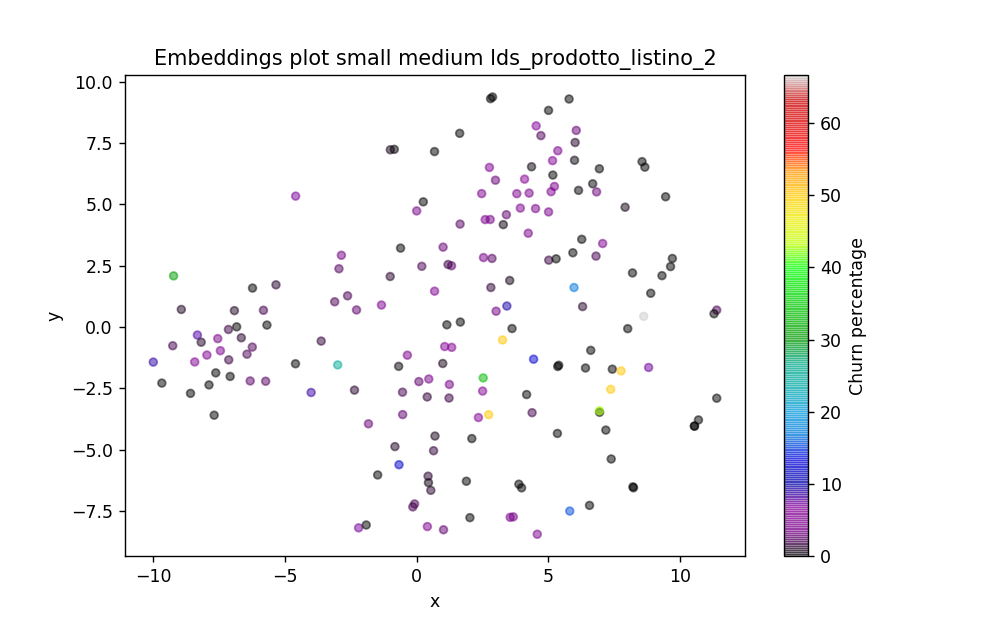

In [347]:
plot_embeddings_TSNE(8, 5, dict_of_embeddings_dicts_small_medium['lds_prodotto_listino_2'], 
                     churn_percentage_dict, supplies_number_dict, dimension = 8, label = False, cmap="nipy_spectral", 
                     title = "Embeddings plot small medium lds_prodotto_listino_2", sizeRatio=5000, fixedSizes = True, size = 20)#nipy_spectral RdPu_r

### Micro

In [358]:
df_percentage_churn = compute_churn_pencentages(column = 'lds_prodotto_listino_2', df = input_data_micro).toPandas()
churn_percentage_dict = df_percentage_churn.set_index('lds_prodotto_listino_2')['percentuale_churnanti'].to_dict()
supplies_number_dict = df_percentage_churn.set_index('lds_prodotto_listino_2')['numero_forniture'].to_dict()

<IPython.core.display.Javascript object>


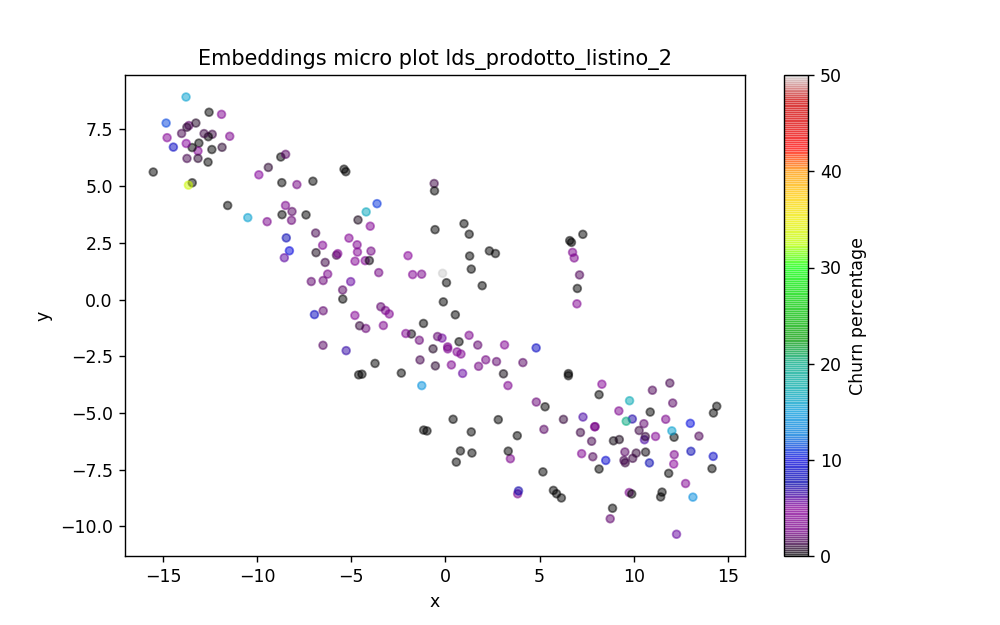

In [359]:
plot_embeddings_TSNE(8, 5, dict_of_embeddings_dicts_micro['lds_prodotto_listino_2'], 
                     churn_percentage_dict, supplies_number_dict, dimension = 8, label = False, cmap="nipy_spectral", 
                     title = "Embeddings micro plot lds_prodotto_listino_2", sizeRatio=5000, fixedSizes = True, size = 20)#nipy_spectral RdPu_r

## mds_canale_acquisizione

### Small and Medium

In [360]:
df_percentage_churn = compute_churn_pencentages(column = 'mds_canale_acquisizione', df = input_data_small_medium).toPandas()
churn_percentage_dict = df_percentage_churn.set_index('mds_canale_acquisizione')['percentuale_churnanti'].to_dict()
supplies_number_dict = df_percentage_churn.set_index('mds_canale_acquisizione')['numero_forniture'].to_dict()

<IPython.core.display.Javascript object>


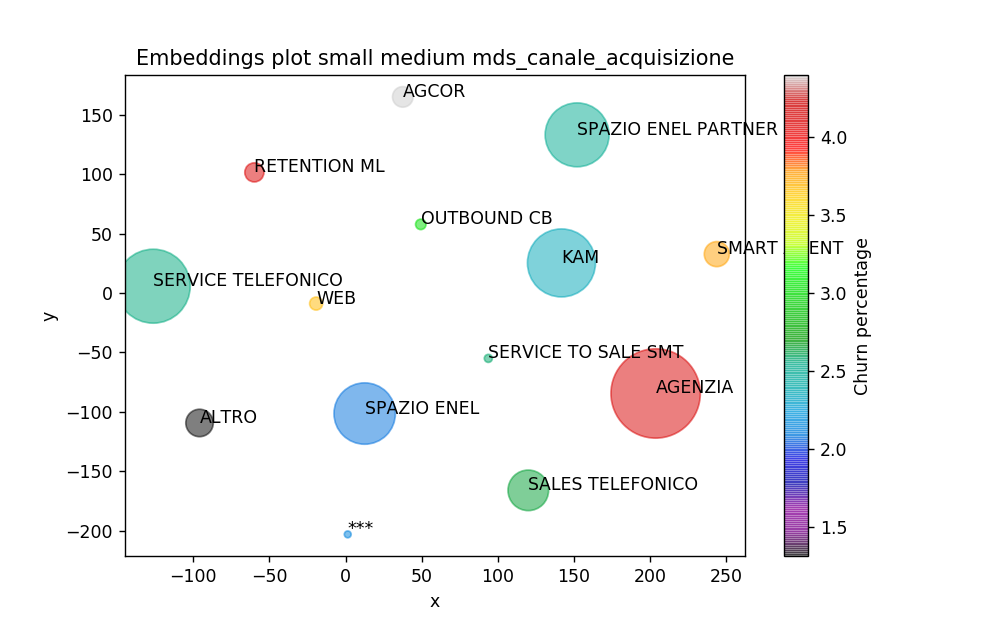

In [361]:
plot_embeddings_TSNE(8, 5, dict_of_embeddings_dicts_small_medium['mds_canale_acquisizione'], 
                     churn_percentage_dict, supplies_number_dict, dimension = 8, label = True, cmap="nipy_spectral", 
                     title = "Embeddings plot small medium mds_canale_acquisizione", sizeRatio=10000, fixedSizes = False, size = 20)#nipy_spectral RdPu_r

### Micro

In [362]:
df_percentage_churn = compute_churn_pencentages(column = 'mds_canale_acquisizione', df = input_data_micro).toPandas()
churn_percentage_dict = df_percentage_churn.set_index('mds_canale_acquisizione')['percentuale_churnanti'].to_dict()
supplies_number_dict = df_percentage_churn.set_index('mds_canale_acquisizione')['numero_forniture'].to_dict()

<IPython.core.display.Javascript object>


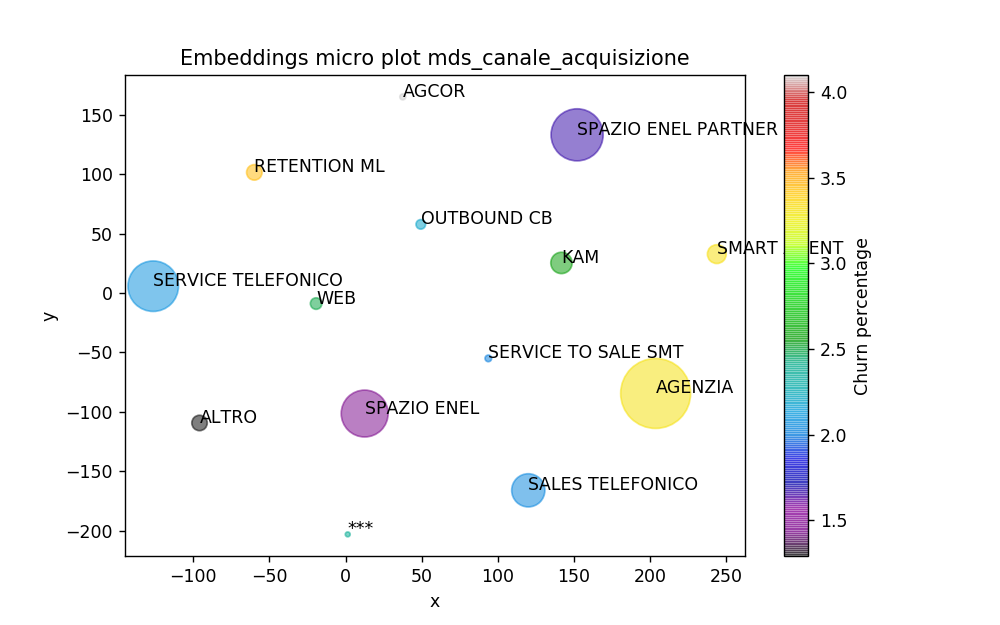

In [363]:
plot_embeddings_TSNE(8, 5, dict_of_embeddings_dicts_micro['mds_canale_acquisizione'], 
                     churn_percentage_dict, supplies_number_dict, dimension = 8, label = True, cmap="nipy_spectral", 
                     title = "Embeddings micro plot mds_canale_acquisizione", sizeRatio=5000, fixedSizes = False, size = 20)#nipy_spectral RdPu_r

## sds_macro_categoria_ateco

### Small and Medium

In [364]:
df_percentage_churn = compute_churn_pencentages(column = 'sds_macro_categoria_ateco', df = input_data_small_medium).toPandas()
churn_percentage_dict = df_percentage_churn.set_index('sds_macro_categoria_ateco')['percentuale_churnanti'].to_dict()
supplies_number_dict = df_percentage_churn.set_index('sds_macro_categoria_ateco')['numero_forniture'].to_dict()

<IPython.core.display.Javascript object>


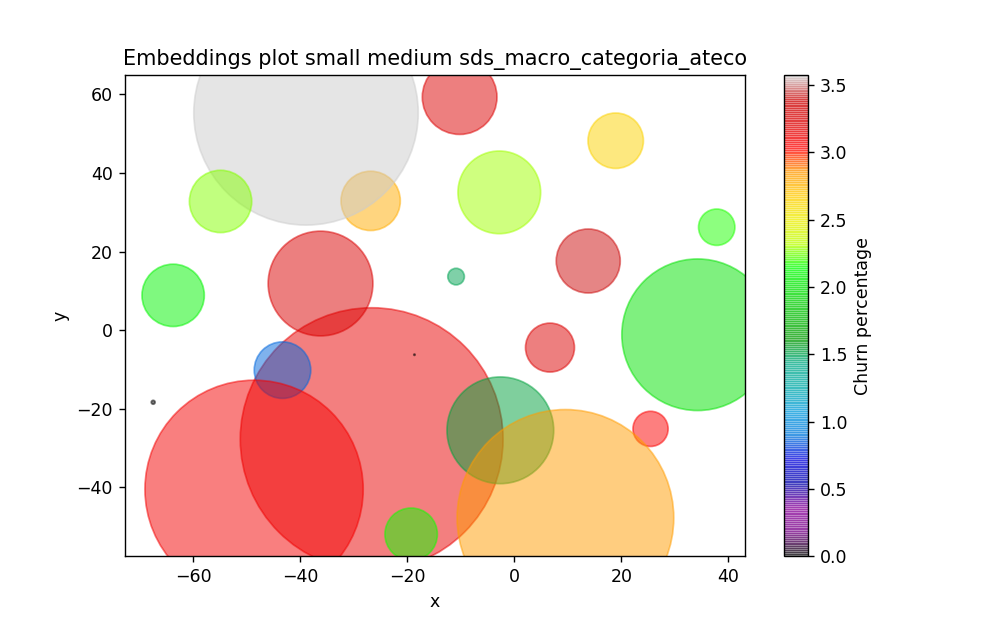

In [365]:
plot_embeddings_TSNE(8, 5, dict_of_embeddings_dicts_small_medium['sds_macro_categoria_ateco'], 
                     churn_percentage_dict, supplies_number_dict, dimension = 8, label = False, cmap="nipy_spectral", 
                     title = "Embeddings plot small medium sds_macro_categoria_ateco", sizeRatio=100000, fixedSizes = False, size = 20)#nipy_spectral RdPu_r

## mds_sottocanale

### Small and Medium

In [367]:
df_percentage_churn = compute_churn_pencentages(column = 'mds_sottocanale', df = input_data_small_medium).toPandas()
churn_percentage_dict = df_percentage_churn.set_index('mds_sottocanale')['percentuale_churnanti'].to_dict()
supplies_number_dict = df_percentage_churn.set_index('mds_sottocanale')['numero_forniture'].to_dict()

<IPython.core.display.Javascript object>


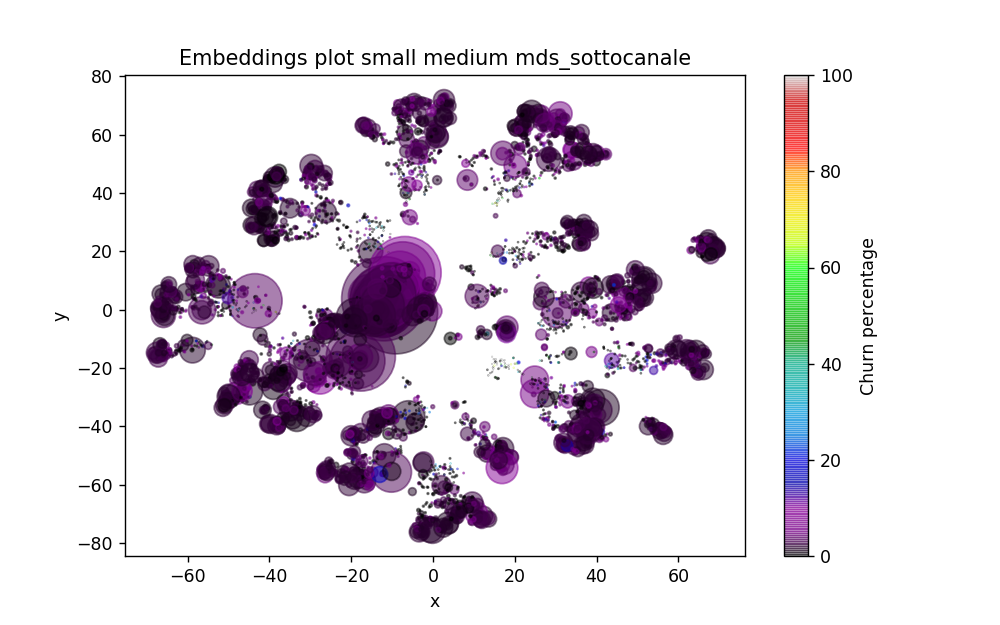

In [372]:
plot_embeddings_TSNE(8, 5, dict_of_embeddings_dicts_small_medium['mds_sottocanale'], 
                     churn_percentage_dict, supplies_number_dict, dimension = 8, label = False, cmap="nipy_spectral", 
                     title = "Embeddings plot small medium mds_sottocanale", sizeRatio=100000, fixedSizes = False, size = 20)#nipy_spectral RdPu_r

### Micro

In [373]:
df_percentage_churn = compute_churn_pencentages(column = 'mds_sottocanale', df = input_data_micro).toPandas()
churn_percentage_dict = df_percentage_churn.set_index('mds_sottocanale')['percentuale_churnanti'].to_dict()
supplies_number_dict = df_percentage_churn.set_index('mds_sottocanale')['numero_forniture'].to_dict()

<IPython.core.display.Javascript object>


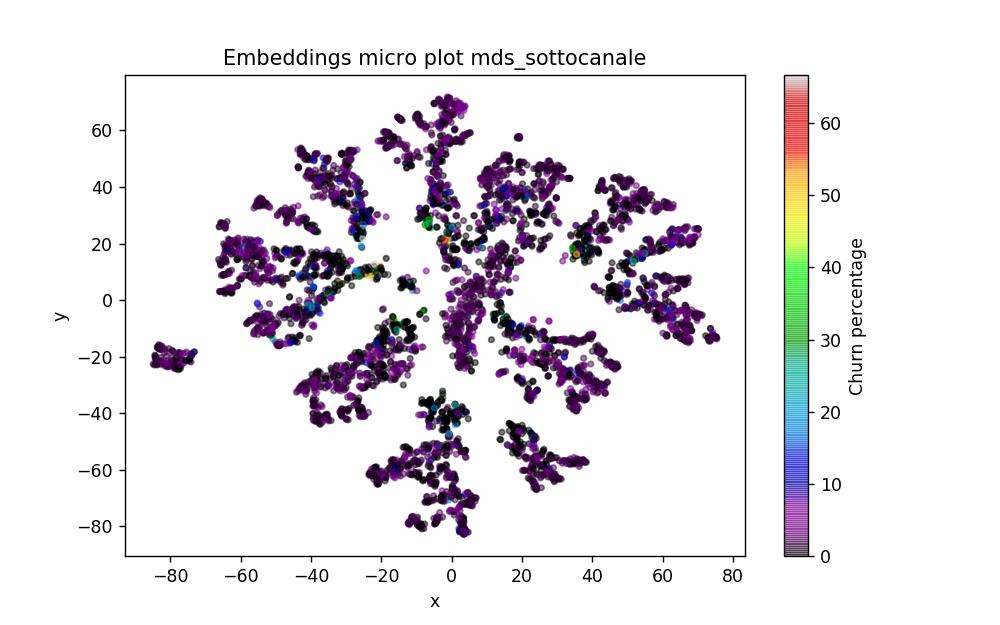

In [378]:
plot_embeddings_TSNE(8, 5, dict_of_embeddings_dicts_micro['mds_sottocanale'], 
                     churn_percentage_dict, supplies_number_dict, dimension = 8, label = False, cmap="nipy_spectral", 
                     title = "Embeddings micro plot mds_sottocanale", sizeRatio=100000, fixedSizes = True, size = 10)#nipy_spectral RdPu_r

## sds_provincia_fatturazione

### Small and Medium

In [379]:
df_percentage_churn = compute_churn_pencentages(column = 'sds_provincia_fatturazione', df = input_data_small_medium).toPandas()
churn_percentage_dict = df_percentage_churn.set_index('sds_provincia_fatturazione')['percentuale_churnanti'].to_dict()
supplies_number_dict = df_percentage_churn.set_index('sds_provincia_fatturazione')['numero_forniture'].to_dict()

<IPython.core.display.Javascript object>


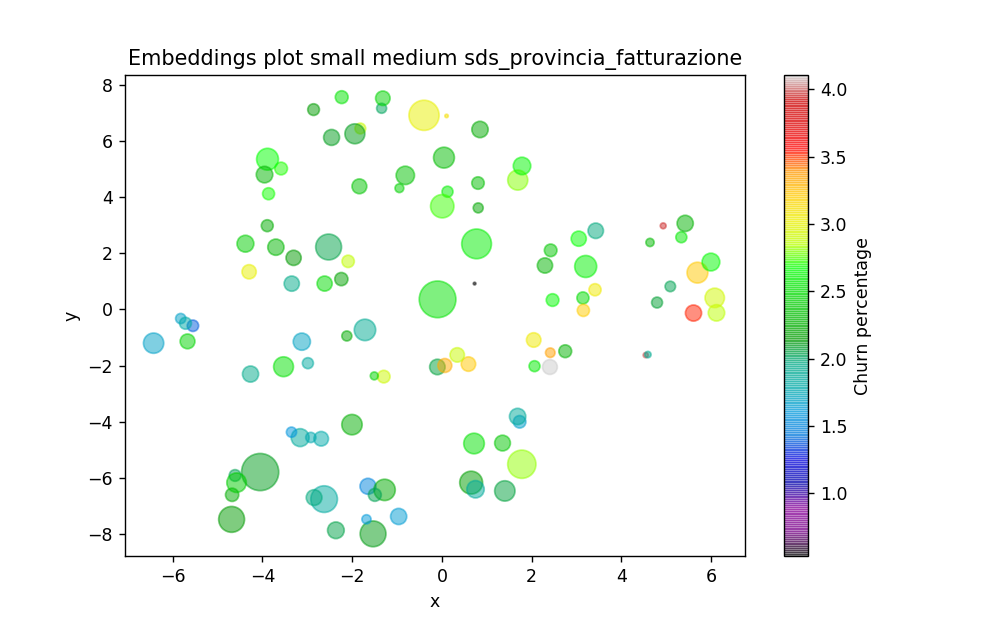

In [387]:
plot_embeddings_TSNE(8, 5, dict_of_embeddings_dicts_small_medium['sds_provincia_fatturazione'], 
                     churn_percentage_dict, supplies_number_dict, dimension = 8, label = False, cmap="nipy_spectral", 
                     title = "Embeddings plot small medium sds_provincia_fatturazione", sizeRatio=10000, fixedSizes = False, size = 20)#nipy_spectral RdPu_r

### Micro

In [389]:
df_percentage_churn = compute_churn_pencentages(column = 'sds_provincia_fatturazione', df = input_data_micro).toPandas()
churn_percentage_dict = df_percentage_churn.set_index('sds_provincia_fatturazione')['percentuale_churnanti'].to_dict()
supplies_number_dict = df_percentage_churn.set_index('sds_provincia_fatturazione')['numero_forniture'].to_dict()

<IPython.core.display.Javascript object>


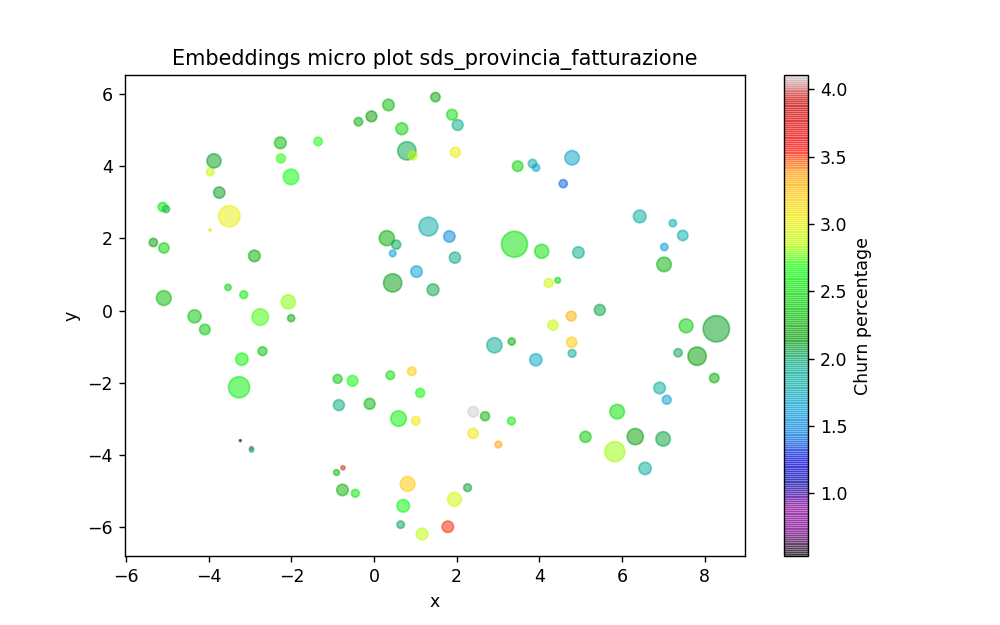

In [390]:
plot_embeddings_TSNE(8, 5, dict_of_embeddings_dicts_micro['sds_provincia_fatturazione'], 
                     churn_percentage_dict, supplies_number_dict, dimension = 8, label = False, cmap="nipy_spectral", 
                     title = "Embeddings micro plot sds_provincia_fatturazione", sizeRatio=5000, fixedSizes = False, size = 20)#nipy_spectral RdPu_r

In [391]:
session.stop()